### Library

In [ ]:
import numpy as np
import pandas as pd
import random
from collections import defaultdict
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

### Import Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df_batting_2024 = pd.read_csv('/content/drive/My Drive/Sports Analytics/Fantasy Draft Project/2024_Batting_Stats_Full.csv')
df_pitching_2024 = pd.read_csv('/content/drive/My Drive/Sports Analytics/Fantasy Draft Project/2024_Pitching_Stats_Full.csv')
df_pos_2024 = pd.read_csv('/content/drive/My Drive/Sports Analytics/Fantasy Draft Project/2024_Position.csv')

In [ ]:
# B+P
df_merged_2024 = pd.merge(df_batting_2024, df_pitching_2024, on=["Season", "Name", "playerId"], how="outer", suffixes=("_batter", "_pitcher"))

# B+P+Pos
df_pos_2024_cleaned = df_pos_2024.groupby(["NameASCII", "PlayerId"])["Pos"].apply(
    lambda x: ', '.join(sorted(set(x), key=lambda y: (y != "P", y)))
).reset_index()

df_merged_2024 = pd.merge(df_merged_2024, df_pos_2024_cleaned, left_on=["Name", "playerId"], right_on=["NameASCII", "PlayerId"], how="left")
df_merged_2024.drop(columns=["NameASCII", "PlayerId"], inplace=True)

display(df_merged_2024.head())

,Season,Name,playerId,GP,GS_batter,AVG,OBP,SLG,OPS,AB,...,OUT,H_pitcher,ER,BB_pitcher,K_pitcher,QS,CG,SHO,SV+H,Pos
0,2024,A.J. Minter,18655,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,103.0,24.0,10.0,11.0,35.0,0.0,0.0,0.0,10.0,P
1,2024,A.J. Puk,19343,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,214.0,51.0,25.0,28.0,88.0,0.0,0.0,0.0,17.0,P
2,2024,AJ Smith-Shawver,29960,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,13.0,3.0,0.0,2.0,4.0,0.0,0.0,0.0,0.0,P
3,2024,Aaron Ashby,23550,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,85.0,20.0,9.0,10.0,33.0,0.0,0.0,0.0,3.0,P
4,2024,Aaron Brooks,12272,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,80.0,33.0,15.0,8.0,12.0,2.0,0.0,0.0,0.0,P


In [ ]:
# Fill NAs (Assume = DH)
df_merged_2024["Pos"].fillna("DH", inplace=True)

# （LF, CF, RF → OF）
df_merged_2024["Pos"] = df_merged_2024["Pos"].apply(
    lambda pos: pos.replace("LF", "OF").replace("CF", "OF").replace("RF", "OF")
)

# No Repeat OFs (since LF, CF, RF may covert to OF, OF, OF)
df_merged_2024["Pos"] = df_merged_2024["Pos"].apply(
    lambda pos: ", ".join(sorted(set(pos.split(", ")))) if pos else pos
)

# P -> SP/RP
def assign_pitcher_position(row):
    if row["APP"] >= 5 and row["GP"] != 0:
      gs_ratio = row["GS_pitcher"] / row["APP"]
      if gs_ratio >= 0.9:
        return "SP"
      elif gs_ratio <= 0.5:
        return "RP"
      else:
        return "SP, RP"

df_merged_2024.loc[df_merged_2024["Pos"].str.contains("P", na=False), "Pos"] = df_merged_2024.apply(assign_pitcher_position, axis=1)


df_merged_2024["Pos"] = df_merged_2024["Pos"].apply(
    lambda pos: ", ".join(sorted(set(pos.split(", ")))) if pos else pos
)
print("Updated Positions:", df_merged_2024["Pos"].unique())
print(df_merged_2024[["Name", "playerId", "Pos"]].head(20))

Updated Positions: ['RP' None 'RP, SP' 'SP' 'OF' '2B, 3B, SS' '1B, 2B, 3B, OF' '2B' '3B, OF'
 'C' '1B, 3B' '1B, OF' '1B, 2B, 3B, OF, SS' '3B' '2B, SS' '2B, 3B, OF, SS'
 '1B' '2B, 3B, OF' 'SS' '2B, C' '2B, OF' '1B, C' '1B, 3B, OF' '1B, 2B, 3B'
 '1B, 2B' '2B, 3B' '1B, 3B, C' '1B, 2B, C, OF' 'DH' '1B, 3B, C, OF'
 '3B, C' '1B, 3B, SS' '1B, C, OF' '2B, OF, SS' '1B, 2B, 3B, SS' 'OF, SS'
 '3B, SS' '3B, OF, SS' '1B, 2B, OF, SS']
                 Name  playerId             Pos
0         A.J. Minter     18655              RP
1            A.J. Puk     19343              RP
2    AJ Smith-Shawver     29960            None
3         Aaron Ashby     23550              RP
4        Aaron Brooks     12272          RP, SP
5        Aaron Bummer     16258              RP
6        Aaron Civale     19479              SP
7         Aaron Hicks      5297            None
8         Aaron Judge     15640              OF
9          Aaron Nola     16149              SP
10       Aaron Schunk     25524      2B, 3B, SS

<ipython-input-5-d23b8c526804>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_merged_2024["Pos"].fillna("DH", inplace=True)


### PCA

In [ ]:
### Scoreboard Compostion
batting_stats = ["H_batter", "HR", "RBI", "SB", "BB_batter", "K_batter", "FPCT", "AVG", "OBP", "SLG"]
pitching_stats = ["W", "OUT", "H_pitcher", "ER", "BB_pitcher", "K_pitcher", "ERA", "WHIP", "QS", "SV+H"]

Reversed negative stat K_batter for PCA in Batters


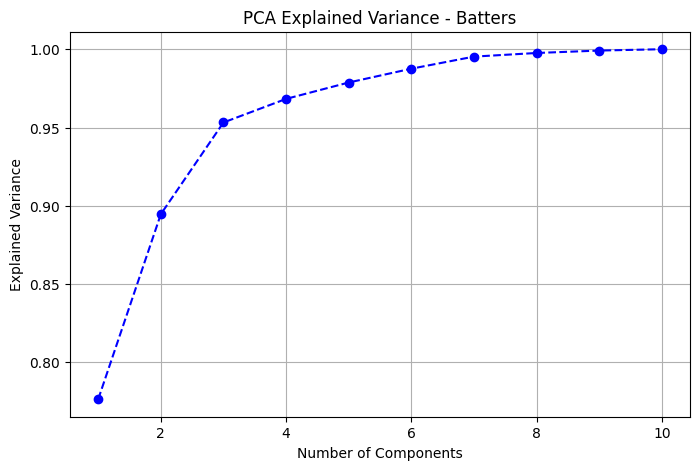

,PC1,PC2,PC3
H_batter,0.337726,-0.228249,-0.041411
HR,0.315297,-0.330819,-0.273902
RBI,0.334281,-0.273900,-0.179463
SB,0.232856,-0.251197,0.925770
BB_batter,0.325709,-0.259067,-0.153325
K_batter,-0.335213,0.199324,0.071729
FPCT,0.295435,0.450500,0.047989
AVG,0.322951,0.377420,0.034628
OBP,0.323354,0.380731,0.018594
SLG,0.325534,0.321159,-0.038781


Reversed negative stat H_pitcher for PCA in Pitchers
Reversed negative stat ER for PCA in Pitchers
Reversed negative stat BB_pitcher for PCA in Pitchers
Reversed negative stat ERA for PCA in Pitchers
Reversed negative stat WHIP for PCA in Pitchers


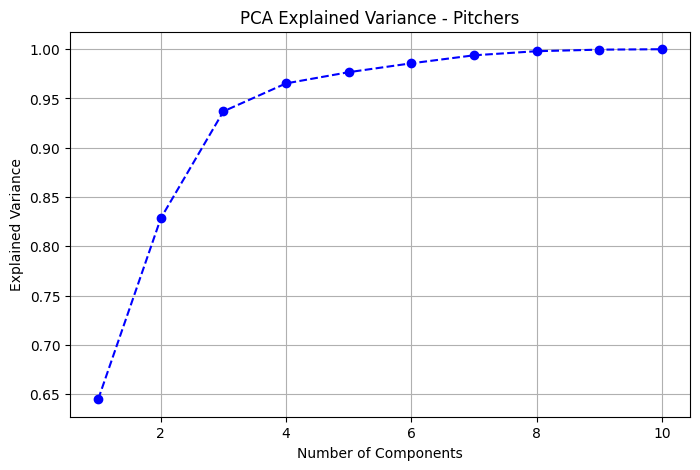

,PC1,PC2,PC3
W,0.362955,0.090832,0.068181
OUT,0.390759,0.056245,0.009598
H_pitcher,-0.385142,-0.029586,0.044636
ER,-0.377655,0.003862,0.057324
BB_pitcher,-0.371136,-0.005655,-0.071756
K_pitcher,0.384145,0.062907,0.067660
ERA,-0.068957,0.703410,0.101368
WHIP,-0.119788,0.684158,0.024283
QS,0.335344,0.132369,-0.339136
SV+H,0.088006,-0.057686,0.924325


In [ ]:
df_merged_2024.fillna(0, inplace=True)
df_batting = df_merged_2024[batting_stats].copy()
df_pitching = df_merged_2024[pitching_stats].copy()

negative_batting_stats = ["K_batter"]
negative_pitching_stats = ["H_pitcher", "ER", "BB_pitcher", "ERA", "WHIP"]

# Function to apply PCA
def perform_pca(df, stats, title):
    df_filtered = df[stats].copy()

    if negative_batting_stats or negative_pitching_stats:
        for stat in negative_batting_stats:
            if stat in df_filtered.columns:
                df_filtered[stat] = -df_filtered[stat]
                print(f"Reversed negative stat {stat} for PCA in {title}")
        for stat in negative_pitching_stats:
            if stat in df_filtered.columns:
                df_filtered[stat] = -df_filtered[stat]
                print(f"Reversed negative stat {stat} for PCA in {title}")

    # Standardize data
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df_filtered)

    # PCA transformation
    pca = PCA()
    df_pca = pca.fit_transform(df_scaled)

    # Explained variance
    explained_variance = np.cumsum(pca.explained_variance_ratio_)

    # Scree plot
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, len(stats) + 1), explained_variance, marker='o', linestyle='dashed', color='b')
    plt.xlabel("Number of Components")
    plt.ylabel("Explained Variance")
    plt.title(f"PCA Explained Variance - {title}")
    plt.grid(True)
    plt.show()

    # Choose Components that can explain >90% variance
    n_components = np.where(explained_variance >= 0.9)[0]
    n_components = n_components[0] + 1 if len(n_components) > 0 else min(5, len(stats))
    n_components = min(max(n_components, 2), 5)

    # Apply PCA with optimal components
    pca = PCA(n_components=n_components)
    df_pca_reduced = pca.fit_transform(df_scaled)

    # Show PCA loadings
    loadings = pd.DataFrame(pca.components_.T, index=stats, columns=[f'PC{i+1}' for i in range(n_components)])
    display(loadings)

    return df_pca_reduced, pca

# Perform PCA for batters
df_pca_batters, pca_batters = perform_pca(df_batting, batting_stats, "Batters")

# Perform PCA for pitchers
df_pca_pitchers, pca_pitchers = perform_pca(df_pitching, pitching_stats, "Pitchers")


In [ ]:
# Compute PCA scores for batters
df_merged_2024["PCA_Batter_Score"] = df_pca_batters[:, 0]  # First principal component

# Compute PCA scores for pitchers
df_merged_2024["PCA_Pitcher_Score"] = df_pca_pitchers[:, 0]  # First principal component

# Rank players based on PCA scores
top_batters = df_merged_2024.sort_values(by="PCA_Batter_Score", ascending=False)
top_pitchers = df_merged_2024.sort_values(by="PCA_Pitcher_Score", ascending=False)

# Display top-ranked batters and pitchers
print("Top Batters by PCA Score:")
display(top_batters[["Name", "PCA_Batter_Score","Pos"]].head(20))

print("Top Pitchers by PCA Score:")
display(top_pitchers[["Name", "PCA_Pitcher_Score","Pos"]].head(20))


Top Batters by PCA Score:


,Name,PCA_Batter_Score,Pos
8,Aaron Judge,11.248181,OF
1247,Shohei Ohtani,10.936978,DH
436,Elly De La Cruz,9.237627,SS
788,Juan Soto,8.990722,OF
142,Bobby Witt Jr.,8.512865,SS
763,Jose Ramirez,8.439161,3B
864,Kyle Schwarber,8.350335,OF
529,Gunnar Henderson,8.344019,SS
173,Brent Rooker,8.116786,OF
1404,Willy Adames,7.998571,SS


Top Pitchers by PCA Score:


,Name,PCA_Pitcher_Score,Pos
1451,Zack Wheeler,9.917323,SP
9,Aaron Nola,9.745073,SP
1237,Seth Lugo,9.727048,SP
890,Logan Webb,9.579909,SP
748,Jose Berrios,9.501161,SP
1094,Pablo Lopez,9.361254,SP
294,Cole Ragans,9.353583,SP
407,Dylan Cease,9.291748,SP
315,Corbin Burnes,9.283591,SP
1282,Tarik Skubal,9.240701,SP


Position Distribution:
RP    494
OF    299
SP    217
2B    156
3B    148
1B    147
SS    107
C      88
DH     11
Name: count, dtype: int64
Average PCA Scores:
Batters: -4.8901771215423276e-17
Pitchers: 2.4450885607711638e-17


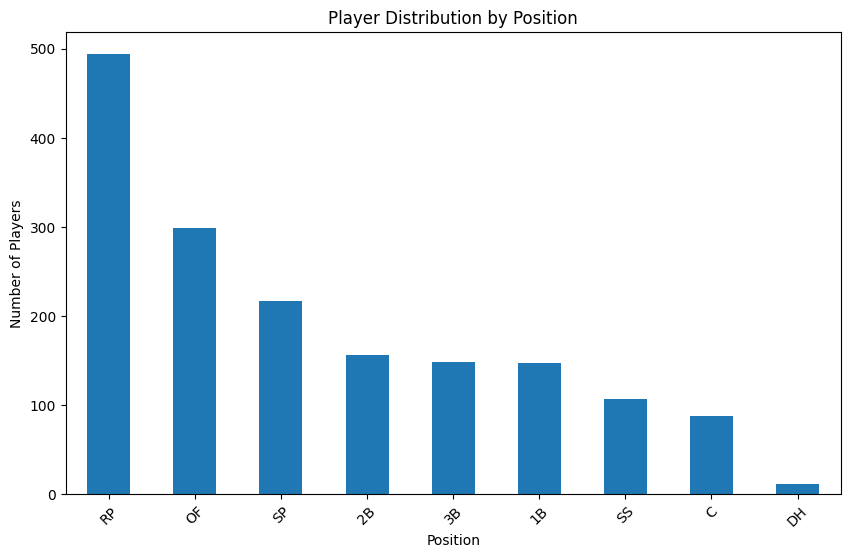

In [ ]:
# Player Numbers by Pos
position_counts = df_merged_2024["Pos"].str.split(", ", expand=True).stack().value_counts()
print("Position Distribution:")
print(position_counts)

# Batter & Pitcher AVG PCA
print("Average PCA Scores:")
print("Batters:", df_merged_2024[df_merged_2024["PCA_Batter_Score"] != 0]["PCA_Batter_Score"].mean())
print("Pitchers:", df_merged_2024[df_merged_2024["PCA_Pitcher_Score"] != 0]["PCA_Pitcher_Score"].mean())

plt.figure(figsize=(10, 6))
position_counts.plot(kind="bar")
plt.title("Player Distribution by Position")
plt.xlabel("Position")
plt.ylabel("Number of Players")
plt.xticks(rotation=45)
plt.show()

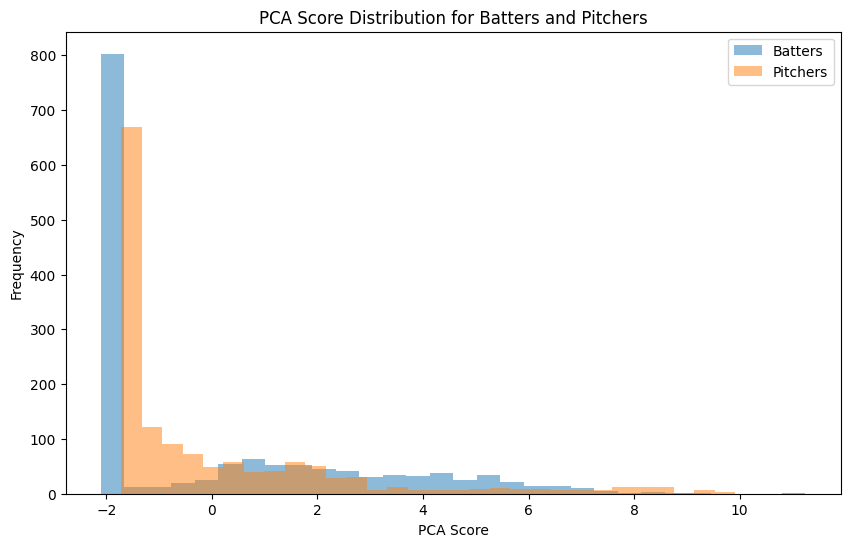

In [ ]:
# PCA Distribution
plt.figure(figsize=(10, 6))
plt.hist(df_merged_2024[df_merged_2024["PCA_Batter_Score"] != 0]["PCA_Batter_Score"], bins=30, alpha=0.5, label="Batters")
plt.hist(df_merged_2024[df_merged_2024["PCA_Pitcher_Score"] != 0]["PCA_Pitcher_Score"], bins=30, alpha=0.5, label="Pitchers")
plt.title("PCA Score Distribution for Batters and Pitchers")
plt.xlabel("PCA Score")
plt.ylabel("Frequency")
plt.legend()
plt.show()

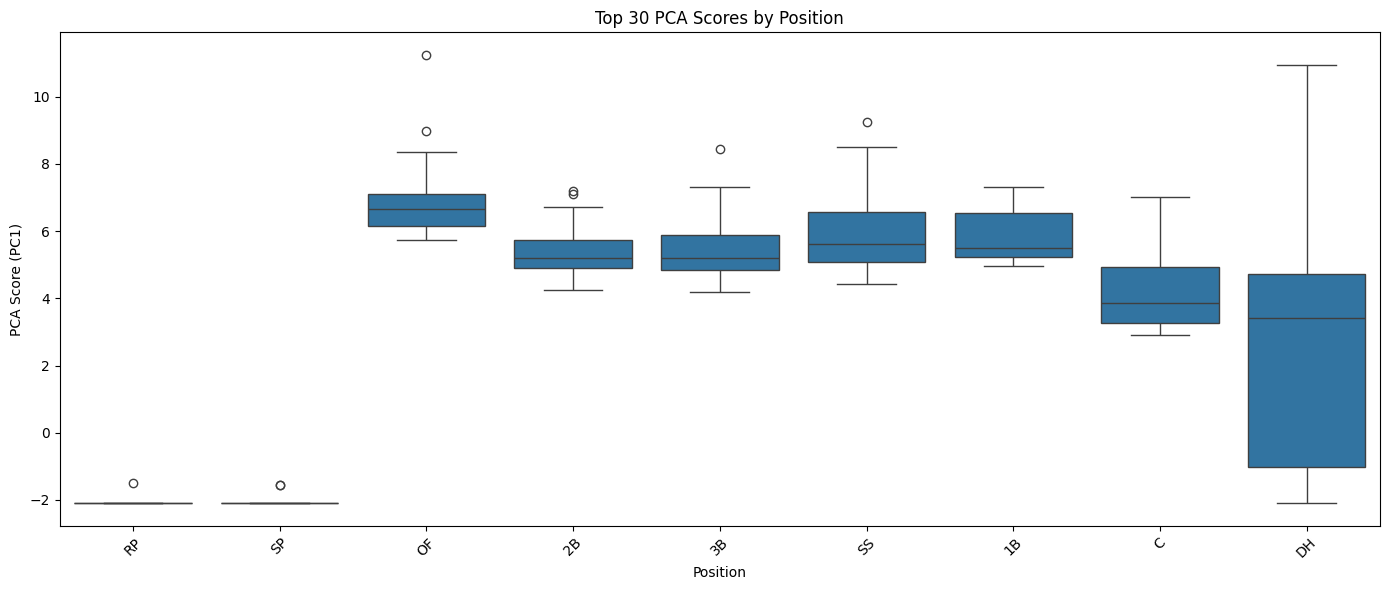

In [ ]:
import seaborn as sns

# 建立一個空的 DataFrame 來存每個位置 top 30 的 PCA 分數
top_30_by_pos = []

# 將所有位置拆開（多重位置用逗號分開）
df_exploded = df_merged_2024.copy()
df_exploded["Pos_List"] = df_exploded["Pos"].str.split(", ")
df_exploded = df_exploded.explode("Pos_List")

# 遍歷每個位置
for pos in df_exploded["Pos_List"].unique():
    df_pos_group = df_exploded[df_exploded["Pos_List"] == pos]
    top30 = df_pos_group.nlargest(30, "PCA_Batter_Score")  # 這邊是打者的 PCA 分數
    top30["Position"] = pos
    top_30_by_pos.append(top30[["Name", "PCA_Batter_Score", "Position"]])

# 合併所有資料
df_top30_all = pd.concat(top_30_by_pos, ignore_index=True)

# 畫出分佈圖（用 boxplot）
plt.figure(figsize=(14, 6))
sns.boxplot(data=df_top30_all, x="Position", y="PCA_Batter_Score")
plt.title("Top 30 PCA Scores by Position")
plt.xlabel("Position")
plt.ylabel("PCA Score (PC1)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


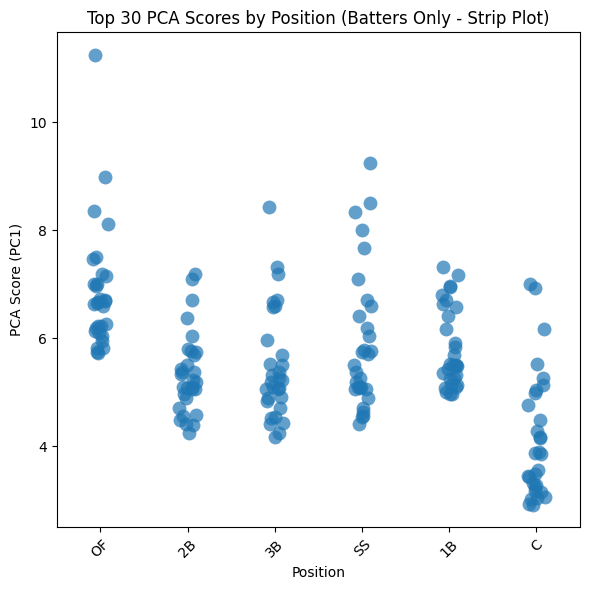

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# 過濾掉投手類型（只保留非 SP / RP 的位置）
df_hitters_only = df_top30_all[~df_top30_all["Position"].isin(["SP", "RP","DH"])]

# 畫 Strip Plot
plt.figure(figsize=(6, 6))
sns.stripplot(
    data=df_hitters_only,
    x="Position",
    y="PCA_Batter_Score",
    jitter=True,
    alpha=0.7,
    size=10
)
plt.title("Top 30 PCA Scores by Position (Batters Only - Strip Plot)")
plt.xlabel("Position")
plt.ylabel("PCA Score (PC1)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


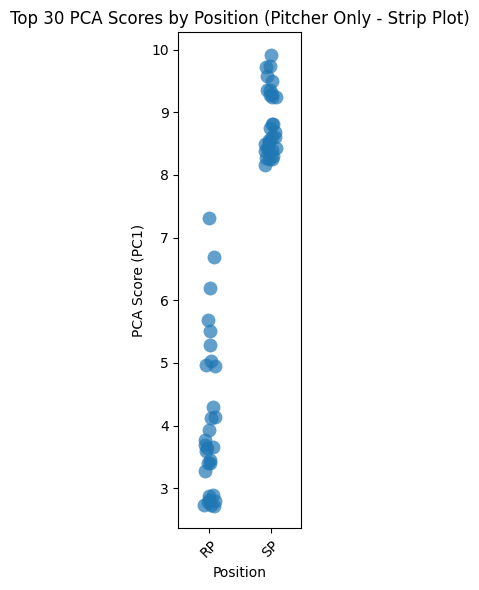

In [ ]:
import seaborn as sns

# 建立一個空的 DataFrame 來存每個位置 top 30 的 PCA 分數
top_30_by_pos = []

# 將所有位置拆開（多重位置用逗號分開）
df_exploded = df_merged_2024.copy()
df_exploded["Pos_List"] = df_exploded["Pos"].str.split(", ")
df_exploded = df_exploded.explode("Pos_List")

# 遍歷每個位置
for pos in df_exploded["Pos_List"].unique():
    df_pos_group = df_exploded[df_exploded["Pos_List"] == pos]
    top30 = df_pos_group.nlargest(30, "PCA_Pitcher_Score")  # 這邊是打者的 PCA 分數
    top30["Position"] = pos
    top_30_by_pos.append(top30[["Name", "PCA_Pitcher_Score", "Position"]])

# 合併所有資料
df_top30_all = pd.concat(top_30_by_pos, ignore_index=True)

import seaborn as sns
import matplotlib.pyplot as plt

# 投手類型（只保留 SP / RP 的位置）
df_pitcher_only = df_top30_all[df_top30_all["Position"].isin(["SP", "RP"])]

# 畫 Strip Plot
plt.figure(figsize=(2, 6))
sns.stripplot(
    data=df_pitcher_only,
    x="Position",
    y="PCA_Pitcher_Score",
    jitter=True,
    alpha=0.7,
    size=10
)
plt.title("Top 30 PCA Scores by Position (Pitcher Only - Strip Plot)")
plt.xlabel("Position")
plt.ylabel("PCA Score (PC1)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Model 1 - Brief Test

In [ ]:
import numpy as np
import pandas as pd
from collections import defaultdict
import random

# Number of Each Position
POSITION_LIMITS = {
    "C": 1, "1B": 1, "2B": 1, "3B": 1, "SS": 1, "OF": 3,
    "UTIL": 2, "SP": 2, "RP": 2, "P": 4, "BN": 5
}

class FantasyDraftEnv:
    def __init__(self, df_players, rounds=23, num_teams=10):
        df_players = df_players.copy()
        if all(col.startswith("is_") for col in df_players.columns if col not in ["playerId", "Name"]):
            pos_columns = [col for col in df_players.columns if col.startswith("is_")]
            df_players["Pos"] = df_players[pos_columns].idxmax(axis=1).str.replace("is_", "")
            df_players["Pos"] = df_players["Pos"].replace({"DH": "UTIL"})
        elif "Pos" not in df_players.columns:
            raise ValueError("No Pos Data！")

        #
        def parse_positions(pos):
            if isinstance(pos, str):
                return [p.strip() for p in pos.split("/")] if "/" in pos else [pos]
            return [pos]

        df_players["Pos_List"] = df_players["Pos"].apply(parse_positions)
        self.df_players = df_players
        self.rounds = rounds
        self.num_teams = num_teams
        self.current_round = 0
        self.current_pick = 0
        self.snake_order = list(range(num_teams)) + list(range(num_teams - 1, -1, -1))
        self.teams = {i: {"players": [], "position_counts": defaultdict(int)} for i in range(num_teams)}
        self.available_players = self.df_players.copy()
        self.team_picks = {i: 0 for i in range(num_teams)}


    def reset(self):
        self.current_round = 0
        self.current_pick = 0
        self.teams = {i: {"players": [], "position_counts": defaultdict(int)} for i in range(self.num_teams)}
        self.available_players = self.df_players.copy()
        self.team_picks = {i: 0 for i in range(self.num_teams)}

    def get_team_needs(self, team_id):
        pos_counts = self.teams[team_id]["position_counts"]

        # All Standard positions
        standard_positions = ["C", "1B", "2B", "3B", "SS", "OF", "SP", "RP"]
        needs = [pos for pos in standard_positions if pos_counts[pos] < POSITION_LIMITS[pos]]

        # UTIL
        batter_positions = ["C", "1B", "2B", "3B", "SS", "OF"]
        filled_batters = sum(pos_counts[pos] for pos in batter_positions)
        if filled_batters >= 4 and pos_counts["UTIL"] < POSITION_LIMITS["UTIL"]:
            needs.append("UTIL")

        # P
        if pos_counts["SP"] >= POSITION_LIMITS["SP"] and pos_counts["RP"] >= POSITION_LIMITS["RP"]:
            if pos_counts["P"] < POSITION_LIMITS["P"]:
                needs.append("P")

        # BN
        if all(pos_counts[pos] >= POSITION_LIMITS[pos] for pos in standard_positions + ["UTIL", "P"]):
            if pos_counts["BN"] < POSITION_LIMITS["BN"]:
                needs.append("BN")

        return random.choice(needs) if needs else None

    def pick_player(self, team_id):
        """A team should not pick more than 23 players"""
        if self.team_picks[team_id] >= 23:
            return None

        target_pos = self.get_team_needs(team_id)
        if not target_pos:
            return None

        pos_counts = self.teams[team_id]["position_counts"]

        # Elite UTIL/DH Threshold (e.g., for Shohei Ohtani)
        pca_threshold = self.available_players[["PCA_Batter_Score", "PCA_Pitcher_Score"]].max(axis=1).quantile(0.90)
        elite_util_threshold = max(8.0, pca_threshold)
        elite_util_players = self.available_players[
            (self.available_players["Pos"].str.contains("UTIL|DH", na=False)) &
            (self.available_players[["PCA_Batter_Score", "PCA_Pitcher_Score"]].max(axis=1) >= elite_util_threshold)
        ].copy()

        pick = None
        assigned_pos = target_pos

        # Calculate all available players' Max_PCA_Score
        self.available_players["Max_PCA_Score"] = self.available_players[["PCA_Batter_Score", "PCA_Pitcher_Score"]].max(axis=1)

        # Check elite UTIL/DH （e.g. Shohei）
        if not elite_util_players.empty and pos_counts["UTIL"] < POSITION_LIMITS["UTIL"]:
            elite_util_players["Max_PCA_Score"] = elite_util_players[["PCA_Batter_Score", "PCA_Pitcher_Score"]].max(axis=1)
            elite_best = elite_util_players.nlargest(1, "Max_PCA_Score").iloc[0]
            top_players = self.available_players.nlargest(5, "Max_PCA_Score")

            # Compare elite UTIL and other top players' PCA score
            max_non_elite_util_score = (
                top_players[top_players.index.isin(elite_util_players.index) == False]["Max_PCA_Score"].max()
                )
            elite_score = elite_best["Max_PCA_Score"]

            if max_non_elite_util_score > elite_score or random.random() < 0.3:  # 30% random pick
                available_top = top_players[
                    top_players["Pos_List"].apply(lambda x: any(pos in x for pos in POSITION_LIMITS if pos_counts[pos] < POSITION_LIMITS[pos]))
                ].copy()
                if not available_top.empty:
                    pick = available_top.sample(1).iloc[0]
                    player_positions = pick["Pos_List"]
                    remaining_positions = [pos for pos in POSITION_LIMITS if pos_counts[pos] < POSITION_LIMITS[pos] and pos in player_positions]
                    if remaining_positions:
                        assigned_pos = random.choice(remaining_positions)
                    elif "UTIL" in player_positions and pos_counts["UTIL"] < POSITION_LIMITS["UTIL"]:
                        assigned_pos = "UTIL"
                    elif pos_counts["BN"] < POSITION_LIMITS["BN"]:
                        assigned_pos = "BN"
                    else:
                        assigned_pos = target_pos
                else:
                    pick = elite_best
                    assigned_pos = "UTIL"
            else:
                pick = elite_best
                assigned_pos = "UTIL"
                print(f"Debug: Elite player {pick['Name']} assigned to UTIL at Round {self.current_round}")
        else:
            available = self.available_players.copy()
            available = available[
                available["Pos_List"].apply(lambda x: any(pos in x for pos in [target_pos] if target_pos in POSITION_LIMITS))
            ]

            if target_pos == "UTIL":
                standard_positions = ["C", "1B", "2B", "3B", "SS", "OF"]
                unfilled_positions = [pos for pos in standard_positions if pos_counts[pos] < POSITION_LIMITS[pos]]
                if unfilled_positions:
                    available = available[
                        available["Pos_List"].apply(lambda x: any(pos in x for pos in unfilled_positions))
                    ]
                    if not available.empty:
                        target_pos = random.choice(unfilled_positions)
                        assigned_pos = target_pos

            if available.empty:
                if target_pos in ["UTIL"]:
                    available = self.available_players[
                        self.available_players["Pos_List"].apply(lambda x: any(pos in x for pos in ["C", "1B", "2B", "3B", "SS", "OF"]))
                    ].copy()
                elif target_pos in ["P"]:
                    available = self.available_players[
                        self.available_players["Pos_List"].apply(lambda x: any(pos in x for pos in ["SP", "RP", "P"]))
                    ].copy()
                elif target_pos == "BN":
                    available = self.available_players.copy()
                if available.empty:
                    print(f"Team {team_id} cannot fill {target_pos} - no suitable players left!")
                    return None

            available["Max_PCA_Score"] = available[["PCA_Batter_Score", "PCA_Pitcher_Score"]].max(axis=1)
            pick = available.nlargest(1, "Max_PCA_Score").iloc[0]

            if len(pick["Pos_List"]) > 1:
                valid_positions = [pos for pos in pick["Pos_List"] if pos_counts[pos] < POSITION_LIMITS[pos]]
                if valid_positions:
                    assigned_pos = random.choice(valid_positions)
                else:
                    assigned_pos = target_pos

        if pick is not None:
            self.teams[team_id]["players"].append(pick)
            self.teams[team_id]["position_counts"][assigned_pos] += 1
            self.team_picks[team_id] += 1
            self.available_players = self.available_players[self.available_players["playerId"] != pick["playerId"]]
            return pick, assigned_pos
        return None, None

    def adjust_positions(self):
        """Adjust positions for players who can play multi position"""
        for team_id in range(self.num_teams):
            pos_counts = self.teams[team_id]["position_counts"]
            players = self.teams[team_id]["players"]

            for pos, limit in POSITION_LIMITS.items():
                if pos_counts[pos] < limit:
                    for i, player in enumerate(players):
                        if len(player["Pos_List"]) > 1 and pos in player["Pos_List"]:
                            if pos_counts[pos] < limit:
                                old_pos = [p for p in player["Pos_List"] if p in POSITION_LIMITS and pos_counts[p] > 0][0]
                                pos_counts[old_pos] -= 1
                                pos_counts[pos] += 1
                                print(f"Team {team_id}: Adjusted {player['Name']} from {old_pos} to {pos}")
                                break

    def check_position_limits(self):
        """Check if each team filled every position"""
        for team_id, team in self.teams.items():
            pos_counts = team["position_counts"]
            player_count = len(team["players"])
            if player_count != 23:
                print(f"Team {team_id} failed: Total players = {player_count} != 23")
                return False
            for pos, limit in POSITION_LIMITS.items():
                if pos_counts[pos] != limit:
                    print(f"Team {team_id} failed: {pos} = {pos_counts[pos]} != {limit}")
                    return False
        return True

# Player Data Source
df_players = df_merged_2024

# Check Data
missing_positions = []
required_positions = ["C", "1B", "2B", "3B", "SS", "OF", "UTIL", "SP", "RP", "P"]
for pos in required_positions:
    if not df_players["Pos"].str.contains(pos, na=False).any() and not (pos == "UTIL" and df_players["Pos"].str.contains("DH", na=False).any()):
        missing_positions.append(pos)

if missing_positions:
    print(f"Warning： Lack of position: {missing_positions}")

else:
    # Test > Draft Only One Time to Double Check if the Code can run the draft under the rule
    env = FantasyDraftEnv(df_players)
    env.reset()

    active_teams = list(range(env.num_teams))
    total_picks = 0

    while any(env.team_picks[t] < 23 for t in range(env.num_teams)):
        if not active_teams:
            break

        if env.current_pick % (2 * env.num_teams - 2) == 0:
            forward = [t for t in range(env.num_teams) if env.team_picks[t] < 23]
            backward = [t for t in range(env.num_teams - 1, -1, -1) if env.team_picks[t] < 23]
            env.snake_order = forward + backward

        team_id = env.snake_order[env.current_pick % len(env.snake_order)]
        pick_result = env.pick_player(team_id)

        if pick_result:
            pick, assigned_pos = pick_result
            print(f"Round {env.current_round}, Team {team_id}: Picked {pick['Name']} - Assigned {assigned_pos}")
            total_picks += 1
            if env.team_picks[team_id] >= 23:
                active_teams.remove(team_id)

        env.current_pick += 1
        if env.current_pick % env.num_teams == 0:
            env.current_round += 1

    # Adjust Player Positions Dynamically
    env.adjust_positions()

    # Check
    if env.check_position_limits():
        print("\n✅ Draft simulation complete! All teams filled 23 picks with exact positions.")
    else:
        print("\n❌ Position requirements not fully met.")

    for team_id in range(env.num_teams):
        print(f"Team {team_id}: {env.team_picks[team_id]} picks")

Round 0, Team 0: Picked Seth Lugo - Assigned SP
Round 0, Team 1: Picked Aaron Nola - Assigned SP
Round 0, Team 2: Picked Jose Berrios - Assigned SP
Round 0, Team 3: Picked Logan Webb - Assigned SP
Round 0, Team 4: Picked Zack Wheeler - Assigned SP
Round 0, Team 5: Picked Cole Ragans - Assigned SP
Round 0, Team 6: Picked Pablo Lopez - Assigned SP
Round 0, Team 7: Picked Aaron Judge - Assigned OF
Debug: Elite player Shohei Ohtani assigned to UTIL at Round 0
Round 0, Team 8: Picked Shohei Ohtani - Assigned UTIL
Round 0, Team 9: Picked Juan Soto - Assigned OF
Round 1, Team 9: Picked Elly De La Cruz - Assigned SS
Round 1, Team 8: Picked William Contreras - Assigned C
Round 1, Team 7: Picked Jose Ramirez - Assigned 3B
Round 1, Team 6: Picked Jose Altuve - Assigned 2B
Round 1, Team 5: Picked Bobby Witt Jr. - Assigned SS
Round 1, Team 4: Picked Bryce Harper - Assigned 1B
Round 1, Team 3: Picked Pete Alonso - Assigned 1B
Round 1, Team 2: Picked Kyle Schwarber - Assigned OF
Round 1, Team 1: Pick

### Model 2: Model 1 Slight Improvement + H2H Winning%

In [ ]:
import numpy as np
import pandas as pd
from collections import defaultdict
import random

# Number of Each Position
POSITION_LIMITS = {
    "C": 1, "1B": 1, "2B": 1, "3B": 1, "SS": 1, "OF": 3,
    "UTIL": 2, "SP": 2, "RP": 2, "P": 4, "BN": 5
}

class FantasyDraftEnv:
    def __init__(self, df_players, rounds=23, num_teams=10):
        df_players = df_players.copy()
        df_players = df_players.drop_duplicates(subset=["Name"], keep="first")
        if all(col.startswith("is_") for col in df_players.columns if col not in ["playerId", "Name"]):
            pos_columns = [col for col in df_players.columns if col.startswith("is_")]
            df_players["Pos"] = df_players[pos_columns].idxmax(axis=1).str.replace("is_", "")
            df_players["Pos"] = df_players["Pos"].replace({"DH": "UTIL"})
        elif "Pos" not in df_players.columns:
            raise ValueError("No Pos Data！")

        def parse_positions(pos):
            if isinstance(pos, str):
                return [p.strip() for p in pos.split("/")] if "/" in pos else [pos]
            return [pos]

        df_players["Pos_List"] = df_players["Pos"].apply(parse_positions)
        df_players = df_players.reset_index(drop=True) # ensure index is unique
        self.df_players = df_players
        self.rounds = rounds
        self.num_teams = num_teams
        self.current_round = 0
        self.current_pick = 0
        self.snake_order = list(range(num_teams)) + list(range(num_teams - 1, -1, -1))
        self.teams = {i: {"players": [], "position_counts": defaultdict(int)} for i in range(num_teams)}
        self.available_players = self.df_players.copy()
        self.team_picks = {i: 0 for i in range(num_teams)}


    def reset(self):
        self.current_round = 0
        self.current_pick = 0
        self.teams = {i: {"players": [], "position_counts": defaultdict(int)} for i in range(self.num_teams)}
        self.available_players = self.df_players.copy()
        self.team_picks = {i: 0 for i in range(self.num_teams)}

    def get_team_needs(self, team_id):
        pos_counts = self.teams[team_id]["position_counts"]

        # All Standard positions
        standard_positions = ["C", "1B", "2B", "3B", "SS", "OF", "SP", "RP"]
        needs = [pos for pos in standard_positions if pos_counts[pos] < POSITION_LIMITS[pos]]

        # UTIL
        batter_positions = ["C", "1B", "2B", "3B", "SS", "OF"]
        filled_batters = sum(pos_counts[pos] for pos in batter_positions)
        if filled_batters >= 4 and pos_counts["UTIL"] < POSITION_LIMITS["UTIL"]:
            needs.append("UTIL")

        # P
        if pos_counts["SP"] >= POSITION_LIMITS["SP"] and pos_counts["RP"] >= POSITION_LIMITS["RP"]:
            if pos_counts["P"] < POSITION_LIMITS["P"]:
                needs.append("P")

        # BN
        if all(pos_counts[pos] >= POSITION_LIMITS[pos] for pos in standard_positions + ["UTIL", "P"]):
            if pos_counts["BN"] < POSITION_LIMITS["BN"]:
                needs.append("BN")

        return random.choice(needs) if needs else None    ## = if not needs: ot needs: return None

        # Prioritize POS according to PCA score
        max_score_pos = None
        max_score = -float("inf")

        # If a player can play SP, RP, P, then use his pitching data
        self.available_players["Relevant_PCA_Score"] = self.available_players.apply(
            lambda row: row["PCA_Pitcher_Score"] if any(pos in ["SP", "RP", "P"] for pos in row["Pos_List"]) else row["PCA_Batter_Score"],
            axis=1
        )

        #Choose positions with higher avg PCA first
        top_n = 10
        for pos in needs:
            available_for_pos = self.available_players[
                self.available_players["Pos_List"].apply(lambda x: pos in x)
            ]
            if not available_for_pos.empty:
                top_n_players = available_for_pos.nlargest(top_n, "Relevant_PCA_Score")
                avg_score = available_for_pos["Relevant_PCA_Score"].mean()
                if avg_score > max_score:
                    max_score = avg_score
                    max_score_pos = pos

        return max_score_pos if max_score_pos else random.choice(needs)

    def pick_player(self, team_id):
        """A team should not pick more than 23 players"""
        if self.team_picks[team_id] >= 23:
            return None

        target_pos = self.get_team_needs(team_id)
        if not target_pos:
            return None

        pos_counts = self.teams[team_id]["position_counts"]

        # check if self.available_players' index is unique
        if not self.available_players.index.is_unique:
          print(f"Warning: self.available_players has non-unique index before picking for Team {team_id}")
          self.available_players = self.available_players.reset_index(drop=True)

        # Elite UTIL/DH Threshold (e.g., for Shohei Ohtani)
        pca_threshold = self.available_players[["PCA_Batter_Score", "PCA_Pitcher_Score"]].max(axis=1).quantile(0.90)
        elite_batter_threshold = max(8.0, pca_threshold)
        elite_batter_players = self.available_players[
            (self.available_players["Pos"].str.contains("UTIL|DH", na=False)) &
            (self.available_players["PCA_Batter_Score"] >= elite_batter_threshold)
        ].copy().reset_index(drop=True)

        # check elite_batter_players's index is unique'
        if not elite_batter_players.index.is_unique:
          print(f"Warning: elite_batter_players has non-unique index for Team {team_id}")
          elite_batter_players = elite_batter_players.reset_index(drop=True)

        pick = None
        assigned_pos = target_pos

        # Check elite UTIL/DH （e.g. Shohei）
        if not elite_batter_players.empty and pos_counts["UTIL"] < POSITION_LIMITS["UTIL"]:
            elite_batter_players["Relevant_PCA_Score"] = elite_batter_players["PCA_Batter_Score"]
            elite_best = elite_batter_players.nlargest(1, "Relevant_PCA_Score").iloc[0]

            # Calculate Relevant_PCA_Score according to target_po
            if target_pos in ["SP", "RP", "P"]:
              self.available_players["Relevant_PCA_Score"] = self.available_players["PCA_Pitcher_Score"]
            elif target_pos in ["C", "1B", "2B", "3B", "SS", "OF", "UTIL"]:
              self.available_players["Relevant_PCA_Score"] = self.available_players["PCA_Batter_Score"]
            else:  # BN or other cases
              self.available_players["Relevant_PCA_Score"] = self.available_players[["PCA_Batter_Score", "PCA_Pitcher_Score"]].max(axis=1)

            # Compare with top 5 non-elite players
            top_players = self.available_players.nlargest(5, "Relevant_PCA_Score")
            max_non_elite_batter_score = top_players[~top_players.index.isin(elite_batter_players.index)]["Relevant_PCA_Score"].max() if not top_players.empty else -float("inf")
            elite_score = elite_best["Relevant_PCA_Score"]

            if max_non_elite_batter_score > elite_score:
                available_top = top_players[
                    top_players["Pos_List"].apply(lambda x: any(pos in x for pos in POSITION_LIMITS if pos_counts[pos] < POSITION_LIMITS[pos]))
                ].copy().reset_index(drop=True)
                if not available_top.empty:
                    pick = available_top.nlargest(1, "Relevant_PCA_Score").iloc[0]
                    player_positions = pick["Pos_List"]
                    valid_positions = [pos for pos in player_positions if pos_counts[pos] < POSITION_LIMITS[pos]]
                    assigned_pos = valid_positions[0] if valid_positions else target_pos

                else:
                    pick = elite_best
                    assigned_pos = "UTIL"
            else:
                pick = elite_best
                assigned_pos = "UTIL"
                print(f"Debug: Elite batter {pick['Name']} assigned to UTIL at Round {self.current_round}")

        else:
            available = self.available_players.copy()
            available = available[
                available["Pos_List"].apply(lambda x: any(pos in x for pos in [target_pos] if target_pos in POSITION_LIMITS))
            ].reset_index(drop=True)  # Ensure unique index

            if target_pos == "UTIL":
                standard_positions = ["C", "1B", "2B", "3B", "SS", "OF"]
                unfilled_positions = [pos for pos in standard_positions if pos_counts[pos] < POSITION_LIMITS[pos]]
                if unfilled_positions:
                    available = available[
                        available["Pos_List"].apply(lambda x: any(pos in x for pos in unfilled_positions))
                    ].reset_index(drop=True)
                    if not available.empty:
                        target_pos = unfilled_positions[0]

            if available.empty:
                if target_pos in ["UTIL"]:
                    available = self.available_players[
                        self.available_players["Pos_List"].apply(lambda x: any(pos in x for pos in ["C", "1B", "2B", "3B", "SS", "OF"]))
                    ].copy().reset_index(drop=True)
                elif target_pos in ["P"]:
                    available = self.available_players[
                        self.available_players["Pos_List"].apply(lambda x: any(pos in x for pos in ["SP", "RP", "P"]))
                    ].copy().reset_index(drop=True)
                elif target_pos == "BN":
                    available = self.available_players.copy().reset_index(drop=True)
                if available.empty:
                    print(f"Team {team_id} cannot fill {target_pos} - no suitable players left!")
                    return None

            available["Relevant_PCA_Score"] = available.apply(
                lambda row: row["PCA_Pitcher_Score"] if any(pos in ["SP", "RP", "P"] for pos in row["Pos_List"]) else row["PCA_Batter_Score"],
                axis = 1
            )

            pick = available.nlargest(1, "Relevant_PCA_Score").iloc[0]

            if len(pick["Pos_List"]) > 1:
                valid_positions = [pos for pos in pick["Pos_List"] if pos_counts[pos] < POSITION_LIMITS[pos]]
                assigned_pos = valid_positions

        if pick is not None:
            # 簡化 pick_df 創建，直接轉為字典
            if isinstance(pick, pd.Series):
              pick_dict = pick.to_dict()
            else:
              raise ValueError(f"Unexpected pick type: {type(pick)}. Expected Series.")
            pick_dict["Assigned_Pos"] = assigned_pos
            self.teams[team_id]["players"].append(pick_dict)
            self.teams[team_id]["position_counts"][assigned_pos] += 1
            self.team_picks[team_id] += 1
            # remove picked player from the pool
            self.available_players = self.available_players[self.available_players["Name"] != pick["Name"]] # remove picked player from the pool
            return pick, assigned_pos
        return None, None

    def adjust_positions(self):
        """Adjust positions for players who can play multi position"""
        for team_id in range(self.num_teams):
            pos_counts = self.teams[team_id]["position_counts"]
            players = self.teams[team_id]["players"]

            for pos, limit in POSITION_LIMITS.items():
                if pos_counts[pos] < limit:
                    for i, player in enumerate(players):
                        if len(player["Pos_List"]) > 1 and pos in player["Pos_List"]:
                            if pos_counts[pos] < limit:
                                old_pos = [p for p in player["Pos_List"] if p in POSITION_LIMITS and pos_counts[p] > 0][0]
                                pos_counts[old_pos] -= 1
                                pos_counts[pos] += 1
                                print(f"Team {team_id}: Adjusted {player['Name']} from {old_pos} to {pos}")
                                break

    def check_position_limits(self):
        """Check if each team filled every position"""
        for team_id, team in self.teams.items():
            pos_counts = team["position_counts"]
            player_count = len(team["players"])
            if player_count != 23:
                print(f"Team {team_id} failed: Total players = {player_count} != 23")
                return False
            for pos, limit in POSITION_LIMITS.items():
                if pos_counts[pos] != limit:
                    print(f"Team {team_id} failed: {pos} = {pos_counts[pos]} != {limit}")
                    return False
        return True

    def print_team_rosters(self):
        for team_id, team in self.teams.items():
            print(f"\nTeam {team_id} Roster:")
            for player in team["players"]:
                print(f"  {player['Name']} - Assigned: {player.get('Assigned_Pos', 'N/A')}")

    def simulate_h2h_matchups(self):
        matchup_history = {f"team_{i}_vs_{j}": [0, 0, 0] for i in range(self.num_teams) for j in range(self.num_teams) if i != j}
        '''
        ### Scoreboard Compostion
        batting_stats = ["H_batter", "HR", "RBI", "SB", "BB_batter", "K_batter", "FPCT", "AVG", "OBP", "SLG"]
        pitching_stats = ["W", "OUT", "H_pitcher", "ER", "BB_pitcher", "K_pitcher", "ERA", "WHIP", "QS", "SV+H"]
        '''
        categories = {
            "H_batter": "higher", "HR": "higher", "RBI": "higher", "SB": "higher", "BB_batter": "higher", "K_batter": "lower","AVG": "higher", "OBP": "higher", "SLG": "higher", "FPCT": "higher",
            "W": "higher", "OUT": "higher", "H_pitcher": "lower", "ER": "lower",  "K_pitcher": "higher", "ERA": "lower", "WHIP": "lower", "QS": "higher", "SV+H": "higher"
        }
        # Allow categories with "_batter" or "_pitcher" suffix if they exist in df_players
        available_categories = [cat for cat in categories if cat in self.df_players.columns]

        category_stats = {team_id: {cat: {"wins": 0, "losses": 0, "ties": 0} for cat in available_categories} for team_id in range(self.num_teams)}

        for team_i in range(self.num_teams):
            for team_j in range(team_i + 1, self.num_teams):
                team_i_players = pd.DataFrame(self.teams[team_i]["players"]).reset_index(drop=True)
                team_j_players = pd.DataFrame(self.teams[team_j]["players"]).reset_index(drop=True)
                team_i_stats = team_i_players[available_categories].sum()
                team_j_stats = team_j_players[available_categories].sum()
                wins, losses, ties = 0, 0, 0

                # Calculate Every Category and versus other teams
                for cat in available_categories:
                    direction = categories[cat]
                    if direction == "higher":
                      if team_i_stats[cat] > team_j_stats[cat]:
                        wins += 1
                        category_stats[team_i][cat]["wins"] += 1
                        category_stats[team_j][cat]["losses"] += 1
                      elif team_i_stats[cat] < team_j_stats[cat]:
                        losses += 1
                        category_stats[team_i][cat]["losses"] += 1
                        category_stats[team_j][cat]["wins"] += 1
                      else:
                        ties += 1
                        category_stats[team_i][cat]["ties"] += 1
                        category_stats[team_j][cat]["ties"] += 1
                    elif direction == "lower":
                      if team_i_stats[cat] < team_j_stats[cat]:
                        wins += 1
                        category_stats[team_i][cat]["wins"] += 1
                        category_stats[team_j][cat]["losses"] += 1
                      elif team_i_stats[cat] > team_j_stats[cat]:
                        losses += 1
                        category_stats[team_i][cat]["losses"] += 1
                        category_stats[team_j][cat]["wins"] += 1
                      else:
                        ties += 1
                        category_stats[team_i][cat]["ties"] += 1
                        category_stats[team_j][cat]["ties"] += 1

                if wins > losses:
                    matchup_history[f"team_{team_i}_vs_{team_j}"][0] += 1
                    matchup_history[f"team_{team_j}_vs_{team_i}"][1] += 1
                elif wins < losses:
                    matchup_history[f"team_{team_i}_vs_{team_j}"][1] += 1
                    matchup_history[f"team_{team_j}_vs_{team_i}"][0] += 1
                else:
                    matchup_history[f"team_{team_i}_vs_{team_j}"][2] += 1
                    matchup_history[f"team_{team_j}_vs_{team_i}"][2] += 1

        # print all match up history
        print("\nMatchup History:")
        for matchup, result in matchup_history.items():
          wins, losses, ties = result
          print(f"{matchup}: Wins={wins}, Losses={losses}, Ties={ties}")

        # calculate all match-up w/l/t (i < j)
        total_wins = 0
        total_losses = 0
        total_ties = 0
        total_wins = sum(1 for i in range(self.num_teams) for j in range(i + 1, self.num_teams) if matchup_history[f"team_{i}_vs_{j}"][0] == 1)
        total_losses = sum(1 for i in range(self.num_teams) for j in range(i + 1, self.num_teams) if matchup_history[f"team_{i}_vs_{j}"][1] == 1)
        total_ties = sum(1 for i in range(self.num_teams) for j in range(i + 1, self.num_teams) if matchup_history[f"team_{i}_vs_{j}"][2] == 1)

        return matchup_history, total_wins, total_losses, total_ties


# Player Data Source
df_players = df_merged_2024

# Check Data
missing_positions = []
required_positions = ["C", "1B", "2B", "3B", "SS", "OF", "UTIL", "SP", "RP", "P"]
for pos in required_positions:
    if not df_players["Pos"].str.contains(pos, na=False).any() and not (pos == "UTIL" and df_players["Pos"].str.contains("DH", na=False).any()):
        missing_positions.append(pos)

if missing_positions:
    print(f"Warning： Lack of position: {missing_positions}")

else:
    # Test > Draft Only One Time to Double Check if the Code can run the draft under the rule
    env = FantasyDraftEnv(df_players)
    env.reset()

    active_teams = list(range(env.num_teams))
    total_picks = 0

    while any(env.team_picks[t] < 23 for t in range(env.num_teams)):
        if not active_teams:
            break

        if env.current_pick % (2 * env.num_teams - 2) == 0:
            forward = [t for t in range(env.num_teams) if env.team_picks[t] < 23]
            backward = [t for t in range(env.num_teams - 1, -1, -1) if env.team_picks[t] < 23]
            env.snake_order = forward + backward

        team_id = env.snake_order[env.current_pick % len(env.snake_order)]
        pick_result = env.pick_player(team_id)

        if pick_result:
            pick, assigned_pos = pick_result
            print(f"Round {env.current_round}, Team {team_id}: Picked {pick['Name']} - Assigned {assigned_pos}")
            total_picks += 1
            if env.team_picks[team_id] >= 23:
                active_teams.remove(team_id)

        env.current_pick += 1
        if env.current_pick % env.num_teams == 0:
            env.current_round += 1

    # Adjust Player Positions Dynamically
    env.adjust_positions()

    # Check
    if env.check_position_limits():
        print("\n✅ Draft simulation complete! All teams filled 23 picks with exact positions.")
    else:
        print("\n❌ Position requirements not fully met.")

    for team_id in range(env.num_teams):
        print(f"Team {team_id}: {env.team_picks[team_id]} picks")


    env.print_team_rosters()

    matchup_history, total_wins, total_losses, total_ties = env.simulate_h2h_matchups()
    print(f"H2H Win Rate: {total_wins}:{total_losses}:{total_ties}")
    for team_id in range(env.num_teams):
        wins = sum(matchup_history[f"team_{team_id}_vs_{j}"][0] for j in range(env.num_teams) if j != team_id)
        print(f"Team {team_id}: {wins} wins")

Debug: Elite batter Shohei Ohtani assigned to UTIL at Round 0
Round 0, Team 0: Picked Shohei Ohtani - Assigned UTIL
Round 0, Team 1: Picked William Contreras - Assigned C
Round 0, Team 2: Picked Aaron Judge - Assigned OF
Round 0, Team 3: Picked Juan Soto - Assigned OF
Round 0, Team 4: Picked Jose Ramirez - Assigned 3B
Round 0, Team 5: Picked Zack Wheeler - Assigned SP
Round 0, Team 6: Picked Jose Altuve - Assigned 2B
Round 0, Team 7: Picked Elly De La Cruz - Assigned SS
Round 0, Team 8: Picked Brice Turang - Assigned 2B
Round 0, Team 9: Picked Cal Raleigh - Assigned C
Round 1, Team 9: Picked Jonathan India - Assigned 2B
Round 1, Team 8: Picked Kyle Schwarber - Assigned OF
Round 1, Team 7: Picked Brent Rooker - Assigned OF
Round 1, Team 6: Picked Bobby Witt Jr. - Assigned SS
Round 1, Team 5: Picked Aaron Nola - Assigned SP
Round 1, Team 4: Picked Bryce Harper - Assigned 1B
Round 1, Team 3: Picked Shea Langeliers - Assigned C
Round 1, Team 2: Picked Pete Alonso - Assigned 1B
Round 1, Tea

### Model 3 -> Apply Different Strategies + One-time Simulation + Regression Design

In [ ]:
import numpy as np
import pandas as pd
from collections import defaultdict
import random
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

POSITION_LIMITS = {
    "C": 1, "1B": 1, "2B": 1, "3B": 1, "SS": 1, "OF": 3,
    "UTIL": 2, "SP": 2, "RP": 2, "P": 4, "BN": 5
}

class FantasyDraftEnv:
    def __init__(self, df_players, rounds=23, num_teams=10, team_strategies=None):
        df_players = df_players.copy().drop_duplicates(subset=["Name"], keep="first")

        # Check PCA and fill 0 if NA
        for col in ["PCA_Batter_Score", "PCA_Pitcher_Score"]:
            if col not in df_players.columns:
                df_players[col] = 0.0
                print(f"Warning: {col} not found, initialized to 0.")
        df_players["Max_PCA_Score"] = df_players[["PCA_Batter_Score", "PCA_Pitcher_Score"]].max(axis=1)

        # Check pos
        if all(col.startswith("is_") for col in df_players.columns if col not in ["playerId", "Name"]):
            pos_columns = [col for col in df_players.columns if col.startswith("is_")]
            df_players["Pos"] = df_players[pos_columns].idxmax(axis=1).str.replace("is_", "")
            df_players["Pos"] = df_players["Pos"].replace({"DH": "UTIL"})
        elif "Pos" not in df_players.columns:
            raise ValueError("No Pos Data！")

        # Iden pos
        def parse_positions(pos):
            if pd.isna(pos) or not isinstance(pos, str):
                return ["UTIL"]
            for sep in [", "]:
                if sep in pos:
                    return [p.strip() for p in pos.split(sep) if p.strip()]
            return [pos.strip()]

        df_players["Pos_List"] = df_players["Pos"].apply(parse_positions)

        self.df_players = df_players.reset_index(drop=True)
        self.rounds = rounds
        self.num_teams = num_teams
        self.team_strategies = team_strategies if team_strategies is not None else {i: "Random" for i in range(num_teams)}
        self.batter_positions = ["C", "1B", "2B", "3B", "SS", "OF"]

    def reset(self):
        self.current_round = 0
        self.current_pick = 0
        self.snake_order = list(range(self.num_teams)) + list(range(self.num_teams - 1, -1, -1))
        self.teams = {i: {"players": [], "position_counts": defaultdict(int)} for i in range(self.num_teams)}
        self.available_players = self.df_players.copy()
        self.team_picks = {i: 0 for i in range(self.num_teams)}

    def get_team_needs(self, team_id):
        pos_counts = self.teams[team_id]["position_counts"]
        standard_positions = ["C", "1B", "2B", "3B", "SS", "OF", "SP", "RP"]
        needs = [pos for pos in standard_positions if pos_counts[pos] < POSITION_LIMITS[pos]]

        # Basic needs -> apply to all strategies
        filled_batters = sum(pos_counts[pos] for pos in self.batter_positions)
        if filled_batters >= 4 and pos_counts["UTIL"] < POSITION_LIMITS["UTIL"]:
            needs.append("UTIL")

        if pos_counts["SP"] >= POSITION_LIMITS["SP"] and pos_counts["RP"] >= POSITION_LIMITS["RP"] and pos_counts["P"] < POSITION_LIMITS["P"]:
            needs.append("P")

        if all(pos_counts[pos] >= POSITION_LIMITS[pos] for pos in standard_positions + ["UTIL", "P"]) and pos_counts["BN"] < POSITION_LIMITS["BN"]:
            needs.append("BN")

        if not needs:
            return "BN"

        strategy = self.team_strategies[team_id]
        self.available_players["Relevant_PCA_Score"] = self.available_players.apply(
            lambda row: row["PCA_Pitcher_Score"] if any(pos in ["SP", "RP", "P"] for pos in row["Pos_List"]) else row["PCA_Batter_Score"],
            axis=1
        )


### Assistent Functions for Strategies
        # Assistent Function 1: Pure PCA Priority
        def find_max_pca_position(positions):
          max_pos = None
          max_score = -float("inf")
          for pos in positions:
            if pos in ["UTIL", "P", "BN"]:
                if pos == "UTIL":
                    available_for_pos = self.available_players[self.available_players["Pos_List"].apply(lambda x: any(p in self.batter_positions for p in x))]
                if pos == "P":
                    available_for_pos = self.available_players[self.available_players["Pos_List"].apply(lambda x: any(p in ["SP", "RP"] for p in x))]
                if pos == "BN":
                    available_for_pos = self.available_players
            else:
                available_for_pos = self.available_players[self.available_players["Pos_List"].apply(lambda x: pos in x)]
            if not available_for_pos.empty:
                pos_max_pca = available_for_pos["Relevant_PCA_Score"].max()
                if pos_max_pca > max_score:
                    max_score = pos_max_pca
                    max_pos = pos
          return max_pos if max_pos else "BN"

        # Assistent Function 2: PCA + Position Need Fixed Hybrid
        def find_max_weighted_position(positions):
          max_pos = None
          max_weighted_score = -float("inf")

          # Set Position Bonus = AVG(PCAs of TOP 20 PLAYERS Still IN THE POOL)
          if not self.available_players.empty:
              top_20_pca = self.available_players["Relevant_PCA_Score"].nlargest(20)
              base_bonus = top_20_pca.mean() if not top_20_pca.empty else 0
          else:
              base_bonus = 0

          # Calculate each position's remaining spots percentage (avoid choosing multi OF, SP, RP)
          remaining_ratios = {}
          for pos in POSITION_LIMITS:
              total_slots = POSITION_LIMITS[pos]
              remaining_slots = max(0, total_slots - pos_counts[pos])
              remaining_ratios[pos] = remaining_slots / total_slots if total_slots > 0 else 0

          for pos in positions:
            if pos in ["UTIL", "P", "BN"]:
                if pos == "UTIL":
                    available_for_pos = self.available_players[self.available_players["Pos_List"].apply(lambda x: any(p in self.batter_positions for p in x))]
                if pos == "P":
                    available_for_pos = self.available_players[self.available_players["Pos_List"].apply(lambda x: any(p in ["SP", "RP"] for p in x))]
                if pos == "BN":
                    available_for_pos = self.available_players
            else:
                available_for_pos = self.available_players[self.available_players["Pos_List"].apply(lambda x: pos in x)]

            if not available_for_pos.empty:
                for _, row in available_for_pos.iterrows():
                    pca_score = row["Relevant_PCA_Score"]
                    # POSITION BONUS
                    if pos in remaining_ratios:
                        remaining_ratio = remaining_ratios[pos]
                        position_bonus = base_bonus * remaining_ratio if pos in needs else 0
                    else:
                        position_bonus = 0

                    weighted_score = 0.7 * pca_score + 0.3 * position_bonus
                    if weighted_score > max_weighted_score:
                        max_weighted_score = weighted_score
                        max_pos = pos

          return max_pos if max_pos else "BN"

        # S3: Specific Category Focus + Weighted Category and Position Need
        def find_s3_position(positions):
            if self.current_round < 6:
                if self.current_round in [0, 2, 4]:  # （HR）
                    max_pos = None
                    max_hr = -float("inf")
                    for pos in positions:
                        if pos in ["UTIL", "BN"]:
                            if pos == "UTIL":
                                available_for_pos = self.available_players[self.available_players["Pos_List"].apply(lambda x: any(p in self.batter_positions for p in x))]
                            elif pos == "BN":
                                available_for_pos = self.available_players
                        else:
                            available_for_pos = self.available_players[self.available_players["Pos_List"].apply(lambda x: pos in x)]
                        if not available_for_pos.empty:
                            pos_max_hr = available_for_pos["HR"].max()
                            if pos_max_hr > max_hr:
                                max_hr = pos_max_hr
                                max_pos = pos
                    return max_pos if max_pos else "BN"
                elif self.current_round in [1, 3, 5]:  # （K_pitcher）
                    max_pos = None
                    max_k = -float("inf")
                    for pos in positions:
                        if pos in ["P", "BN"]:
                            if pos == "P":
                                available_for_pos = self.available_players[self.available_players["Pos_List"].apply(lambda x: any(p in ["SP", "RP"] for p in x))]
                            elif pos == "BN":
                                available_for_pos = self.available_players
                        else:
                            available_for_pos = self.available_players[self.available_players["Pos_List"].apply(lambda x: pos in x)]
                        if not available_for_pos.empty:
                            pos_max_k = available_for_pos["K_pitcher"].max()
                            if pos_max_k > max_k:
                                max_k = pos_max_k
                                max_pos = pos
                    return max_pos if max_pos else "BN"
            else:
                max_pos = None
                max_weighted_score = -float("inf")

                if not self.available_players.empty:
                    top_20_pca = self.available_players["Relevant_PCA_Score"].nlargest(20)
                    base_bonus = top_20_pca.mean() if not top_20_pca.empty else 0
                else:
                    base_bonus = 0

                remaining_ratios = {}
                for pos in POSITION_LIMITS:
                    total_slots = POSITION_LIMITS[pos]
                    remaining_slots = max(0, total_slots - pos_counts[pos])
                    remaining_ratios[pos] = remaining_slots / total_slots if total_slots > 0 else 0

                # standardize（HR, K_pitcher）
                if not self.available_players.empty:
                    hr_max = self.available_players["HR"].max()
                    hr_min = self.available_players["HR"].min()
                    k_max = self.available_players["K_pitcher"].max()
                    k_min = self.available_players["K_pitcher"].min()
                    hr_range = hr_max - hr_min if hr_max != hr_min else 1
                    k_range = k_max - k_min if k_max != k_min else 1
                    self.available_players["Category_Score"] = self.available_players.apply(
                        lambda row: ((row["HR"] - hr_min) / hr_range * 100 if any(p in self.batter_positions for p in row["Pos_List"])
                                     else (row["K_pitcher"] - k_min) / k_range * 100), axis=1)
                else:
                    self.available_players["Category_Score"] = 0

                if self.current_round < 10:
                    category_weight = 0.7
                    position_weight = 0.3
                elif self.current_round < 15:
                    category_weight = 0.5
                    position_weight = 0.5
                else:
                    category_weight = 0.3
                    position_weight = 0.7

                for pos in positions:
                    if pos in ["UTIL", "P", "BN"]:
                        if pos == "UTIL":
                            available_for_pos = self.available_players[self.available_players["Pos_List"].apply(lambda x: any(p in self.batter_positions for p in x))]
                        elif pos == "P":
                            available_for_pos = self.available_players[self.available_players["Pos_List"].apply(lambda x: any(p in ["SP", "RP"] for p in x))]
                        elif pos == "BN":
                            available_for_pos = self.available_players
                    else:
                        available_for_pos = self.available_players[self.available_players["Pos_List"].apply(lambda x: pos in x)]
                    if not available_for_pos.empty:
                        pos_max_category = available_for_pos["Category_Score"].max()
                        if pos in remaining_ratios:
                            remaining_ratio = remaining_ratios[pos]
                            position_bonus = base_bonus * remaining_ratio
                        else:
                            position_bonus = 0
                        weighted_score = category_weight * pos_max_category + position_weight * position_bonus
                        if weighted_score > max_weighted_score:
                            max_weighted_score = weighted_score
                            max_pos = pos
                return max_pos if max_pos else "BN"


        # Assistent Function 4: Elite Position Priority
        def find_s4_position(positions):
            # Calculate top_5_avg 和 mid_tier_avg by Positions
            pca_stats = {}
            for pos in positions:
                if pos in ["UTIL", "P", "BN"]:
                    if pos == "UTIL":
                        available_for_pos = self.available_players[self.available_players["Pos_List"].apply(lambda x: any(p in self.batter_positions for p in x))]
                    elif pos == "P":
                        available_for_pos = self.available_players[self.available_players["Pos_List"].apply(lambda x: any(p in ["SP", "RP"] for p in x))]
                    elif pos == "BN":
                        available_for_pos = self.available_players
                else:
                    available_for_pos = self.available_players[self.available_players["Pos_List"].apply(lambda x: pos in x)]

                if not available_for_pos.empty:
                    # Sort PCA Score by Player (DESC)
                    sorted_players = available_for_pos.sort_values(by="Relevant_PCA_Score", ascending=False)
                    # Top 5
                    top_5 = sorted_players.head(5)
                    top_5_avg = top_5["Relevant_PCA_Score"].mean() if not top_5.empty else 0
                    # Top 5 ~ 15
                    mid_tier = sorted_players.iloc[5:15]
                    mid_tier_avg = mid_tier["Relevant_PCA_Score"].mean() if not mid_tier.empty else 0
                    # Gap
                    if top_5_avg > 0 and mid_tier_avg > 0:  # Ensure if there is enough number of players
                        gap = top_5_avg - mid_tier_avg
                        relative_gap = gap / top_5_avg
                    else:
                        relative_gap = 0
                    pca_stats[pos] = {"relative_gap": relative_gap, "top_5_avg": top_5_avg}
                else:
                    pca_stats[pos] = {"relative_gap": 0, "top_5_avg": 0}

            top_5_avgs = [stats["top_5_avg"] for stats in pca_stats.values()]
            if top_5_avgs and max(top_5_avgs) > min(top_5_avgs):
                top_5_min = min(top_5_avgs)
                top_5_max = max(top_5_avgs)
                top_5_range = top_5_max - top_5_min
            else:
                top_5_min = 0
                top_5_max = 0
                top_5_range = 0


            # Weight (different by round)
            if self.current_round < 10:
                  weight_relative_gap = 0.3
                  weight_top_5 = 0.7
            elif self.current_round < 15:
                  weight_relative_gap = 0.5
                  weight_top_5 = 0.5
            else:
                  weight_relative_gap = 0.7
                  weight_top_5 = 0.3

            weighted_scores = {}
            for pos in pca_stats.keys():
                # standardize top 5 pca (0-1)
                top_5_avg = pca_stats[pos].get("top_5_avg", 0)
                normalized_top_5 = (top_5_avg - top_5_min) / top_5_range if top_5_range > 0 else 0
                pca_stats[pos]["normalized_top_5"] = normalized_top_5

                # Calculate Weight
                relative_gap = pca_stats[pos].get("relative_gap", 0)
                weighted_score = (weight_relative_gap * relative_gap) + (weight_top_5 * normalized_top_5)
                weighted_scores[pos] = weighted_score

            # Choose best weighted score
            if weighted_scores:
                max_score_pos = max(weighted_scores, key=weighted_scores.get)
                max_score = weighted_scores[max_score_pos]
                max_relative_gap = pca_stats[max_score_pos].get("relative_gap", 0)
                max_top_5_avg = pca_stats[max_score_pos].get("top_5_avg", 0)
                print(f"S4 selected position {max_score_pos} with weighted score {max_score:.2f} "
                      f"(relative gap: {max_relative_gap:.2%}, top_5_avg: {max_top_5_avg:.2f})")
                return max_score_pos
            else:
                # use s1 if no better pos
                print(f"S4 no valid PCA gaps, falling back to S1")
                return find_max_pca_position(positions)


### Apply Design Strategies
        if strategy == "S1":
            return find_max_pca_position(needs)
        elif strategy == "S2":
            return find_max_weighted_position(needs)
        elif strategy == "S3":
            return find_s3_position(needs)
        elif strategy == "S4":
            return find_s4_position(needs)
        else:  # Random
            remaining_ratios = {}
            for pos in POSITION_LIMITS:
                total_slots = POSITION_LIMITS[pos]
                remaining_slots = max(0, total_slots - pos_counts[pos])
                remaining_ratios[pos] = remaining_slots / total_slots if total_slots > 0 else 0

            weights = [remaining_ratios.get(pos, 0) for pos in needs]
            total_weight = sum(weights)
            if total_weight > 0:
                weights = [w / total_weight for w in weights]
                return random.choices(needs, weights=weights, k=1)[0]
            else:
                return random.choice(needs)
            return random.choice(needs)


    def pick_player(self, team_id):
        """A team should not pick more than 23 players"""
        if self.team_picks[team_id] >= 23:
            return None

        target_pos = self.get_team_needs(team_id)
        if not target_pos:
            return None

        pos_counts = self.teams[team_id]["position_counts"]
        strategy = self.team_strategies[team_id]

        # check if self.available_players' index is unique
        if not self.available_players.index.is_unique:
          print(f"Warning: self.available_players has non-unique index before picking for Team {team_id}")
          self.available_players = self.available_players.reset_index(drop=True)

        # Elite UTIL/DH Threshold (e.g., for Shohei Ohtani)
        pca_threshold = self.available_players[["PCA_Batter_Score", "PCA_Pitcher_Score"]].max(axis=1).quantile(0.90)
        elite_batter_threshold = max(8.0, pca_threshold)
        elite_batter_players = self.available_players[
            (self.available_players["Pos"].str.contains("UTIL|DH", na=False)) &
            (self.available_players["PCA_Batter_Score"] >= elite_batter_threshold)
        ].copy().reset_index(drop=True)

        # check elite_batter_players's index is unique'
        if not elite_batter_players.index.is_unique:
          print(f"Warning: elite_batter_players has non-unique index for Team {team_id}")
          elite_batter_players = elite_batter_players.reset_index(drop=True)

        pick = None
        assigned_pos = target_pos

        # Check elite UTIL/DH （e.g. Shohei）
        if not elite_batter_players.empty and pos_counts["UTIL"] < POSITION_LIMITS["UTIL"]:
            elite_batter_players["Relevant_PCA_Score"] = elite_batter_players["PCA_Batter_Score"]
            elite_best = elite_batter_players.nlargest(1, "Relevant_PCA_Score").iloc[0]

            # Calculate Relevant_PCA_Score according to target_po
            if target_pos in ["SP", "RP", "P"]:
              self.available_players["Relevant_PCA_Score"] = self.available_players["PCA_Pitcher_Score"]
            elif target_pos in ["C", "1B", "2B", "3B", "SS", "OF", "UTIL"]:
              self.available_players["Relevant_PCA_Score"] = self.available_players["PCA_Batter_Score"]
            else:  # BN or other cases
              self.available_players["Relevant_PCA_Score"] = self.available_players[["PCA_Batter_Score", "PCA_Pitcher_Score"]].max(axis=1)

            # Compare with top 5 non-elite players
            top_players = self.available_players.nlargest(5, "Relevant_PCA_Score")
            max_non_elite_batter_score = top_players[~top_players.index.isin(elite_batter_players.index)]["Relevant_PCA_Score"].max() if not top_players.empty else -float("inf")
            elite_score = elite_best["Relevant_PCA_Score"]

            if max_non_elite_batter_score > elite_score:
                available_top = top_players[
                    top_players["Pos_List"].apply(lambda x: any(pos in x for pos in POSITION_LIMITS if pos_counts[pos] < POSITION_LIMITS[pos]))
                ].copy().reset_index(drop=True)
                if not available_top.empty:
                    pick = available_top.nlargest(1, "Relevant_PCA_Score").iloc[0]
                    player_positions = pick["Pos_List"]
                    valid_positions = [pos for pos in player_positions if pos_counts[pos] < POSITION_LIMITS[pos]]
                    assigned_pos = valid_positions[0] if valid_positions else target_pos

                else:
                    pick = elite_best
                    assigned_pos = "UTIL"
            else:
                pick = elite_best
                assigned_pos = "UTIL"
                print(f"Debug: Elite batter {pick['Name']} assigned to UTIL at Round {self.current_round}")

        else:
            available = self.available_players.copy()
            available = available[
                available["Pos_List"].apply(lambda x: any(pos in x for pos in [target_pos] if target_pos in POSITION_LIMITS))
            ].reset_index(drop=True)  # Ensure unique index

            if available.empty:
                if target_pos in ["UTIL"]:
                    available = self.available_players[
                        self.available_players["Pos_List"].apply(lambda x: any(pos in x for pos in ["C", "1B", "2B", "3B", "SS", "OF"]))
                    ].copy().reset_index(drop=True)
                elif target_pos in ["P"]:
                    available = self.available_players[
                        self.available_players["Pos_List"].apply(lambda x: any(pos in x for pos in ["SP", "RP", "P"]))
                    ].copy().reset_index(drop=True)
                elif target_pos == "BN":
                    available = self.available_players.copy().reset_index(drop=True)
                if available.empty:
                    print(f"Team {team_id} cannot fill {target_pos} - no suitable players left!")
                    return None

            pick = available.nlargest(1, "Relevant_PCA_Score").iloc[0]

            if len(pick["Pos_List"]) > 1:
                valid_positions = [pos for pos in pick["Pos_List"] if pos_counts[pos] < POSITION_LIMITS[pos]]
                assigned_pos = valid_positions[0] if valid_positions else target_pos

        if pick is not None:
            if isinstance(pick, pd.Series):
              pick_dict = pick.to_dict()
            else:
              raise ValueError(f"Unexpected pick type: {type(pick)}. Expected Series.")
            pick_dict["Assigned_Pos"] = assigned_pos
            self.teams[team_id]["players"].append(pick_dict)
            self.teams[team_id]["position_counts"][assigned_pos] += 1
            self.team_picks[team_id] += 1
            # remove picked player from the pool
            self.available_players = self.available_players[self.available_players["Name"] != pick["Name"]] # remove picked player from the pool
            return pick, assigned_pos
        return None, None

    def adjust_positions(self):
        """Adjust positions for players who can play multi position"""
        for team_id in range(self.num_teams):
            pos_counts = self.teams[team_id]["position_counts"]
            players = self.teams[team_id]["players"]

            for pos, limit in POSITION_LIMITS.items():
                if pos_counts[pos] < limit:
                    for i, player in enumerate(players):
                        if len(player["Pos_List"]) > 1 and pos in player["Pos_List"]:
                            if pos_counts[pos] < limit:
                                possible_old_positions = [p for p in player["Pos_List"] if p in POSITION_LIMITS and pos_counts[p] > 0]
                                if possible_old_positions:
                                    old_pos = possible_old_positions[0]
                                    pos_counts[old_pos] -= 1
                                    pos_counts[pos] += 1
                                    print(f"Team {team_id}: Adjusted {player['Name']} from {old_pos} to {pos}")

    def check_position_limits(self):
        """Check if each team filled every position"""
        for team_id, team in self.teams.items():
            pos_counts = team["position_counts"]
            player_count = len(team["players"])
            if player_count != 23:
                print(f"Team {team_id} failed: Total players = {player_count} != 23")
                return False
            for pos, limit in POSITION_LIMITS.items():
                if pos_counts[pos] != limit:
                    print(f"Team {team_id} failed: {pos} = {pos_counts[pos]} != {limit}")
                    return False
        return True

    def print_team_rosters(self):
        for team_id, team in self.teams.items():
            print(f"\nTeam {team_id} Roster:")
            for player in team["players"]:
                print(f"  {player['Name']} - Assigned: {player.get('Assigned_Pos', 'N/A')}")

    def simulate_h2h_matchups(self):
        matchup_history = {f"team_{i}_vs_{j}": [0, 0, 0] for i in range(self.num_teams) for j in range(self.num_teams) if i != j}
        '''
        ### Scoreboard Compostion
        batting_stats = ["H_batter", "HR", "RBI", "SB", "BB_batter", "K_batter", "FPCT", "AVG", "OBP", "SLG"]
        pitching_stats = ["W", "OUT", "H_pitcher", "ER", "BB_pitcher", "K_pitcher", "ERA", "WHIP", "QS", "SV+H"]
        '''
        categories = {
            "H_batter": "higher", "HR": "higher", "RBI": "higher", "SB": "higher", "BB_batter": "higher", "K_batter": "lower","AVG": "higher", "OBP": "higher", "SLG": "higher", "FPCT": "higher",
            "W": "higher", "OUT": "higher", "H_pitcher": "lower", "ER": "lower",  "K_pitcher": "higher", "ERA": "lower", "WHIP": "lower", "QS": "higher", "SV+H": "higher"
        }
        # Allow categories with "_batter" or "_pitcher" suffix if they exist in df_players
        available_categories = [cat for cat in categories if cat in self.df_players.columns]

        category_stats = {team_id: {cat: {"wins": 0, "losses": 0, "ties": 0} for cat in available_categories} for team_id in range(self.num_teams)}

        for team_i in range(self.num_teams):
            for team_j in range(team_i + 1, self.num_teams):
                team_i_players = pd.DataFrame(self.teams[team_i]["players"]).reset_index(drop=True)
                team_j_players = pd.DataFrame(self.teams[team_j]["players"]).reset_index(drop=True)
                team_i_stats = team_i_players[available_categories].sum()
                team_j_stats = team_j_players[available_categories].sum()
                wins, losses, ties = 0, 0, 0

                # Calculate Every Category and versus other teams
                for cat in available_categories:
                    direction = categories[cat]
                    if direction == "higher":
                      if team_i_stats[cat] > team_j_stats[cat]:
                        wins += 1
                        category_stats[team_i][cat]["wins"] += 1
                        category_stats[team_j][cat]["losses"] += 1
                      elif team_i_stats[cat] < team_j_stats[cat]:
                        losses += 1
                        category_stats[team_i][cat]["losses"] += 1
                        category_stats[team_j][cat]["wins"] += 1
                      else:
                        ties += 1
                        category_stats[team_i][cat]["ties"] += 1
                        category_stats[team_j][cat]["ties"] += 1
                    elif direction == "lower":
                      if team_i_stats[cat] < team_j_stats[cat]:
                        wins += 1
                        category_stats[team_i][cat]["wins"] += 1
                        category_stats[team_j][cat]["losses"] += 1
                      elif team_i_stats[cat] > team_j_stats[cat]:
                        losses += 1
                        category_stats[team_i][cat]["losses"] += 1
                        category_stats[team_j][cat]["wins"] += 1
                      else:
                        ties += 1
                        category_stats[team_i][cat]["ties"] += 1
                        category_stats[team_j][cat]["ties"] += 1

                if wins > losses:
                    matchup_history[f"team_{team_i}_vs_{team_j}"][0] += 1
                    matchup_history[f"team_{team_j}_vs_{team_i}"][1] += 1
                elif wins < losses:
                    matchup_history[f"team_{team_i}_vs_{team_j}"][1] += 1
                    matchup_history[f"team_{team_j}_vs_{team_i}"][0] += 1
                else:
                    matchup_history[f"team_{team_i}_vs_{team_j}"][2] += 1
                    matchup_history[f"team_{team_j}_vs_{team_i}"][2] += 1

        # print all match up history
        print("\nMatchup History:")
        for matchup, result in matchup_history.items():
          wins, losses, ties = result
          print(f"{matchup}: Wins={wins}, Losses={losses}, Ties={ties}")

        # calculate all match-up w/l/t (i < j)
        total_wins = 0
        total_losses = 0
        total_ties = 0
        total_wins = sum(matchup_history[f"team_{i}_vs_{j}"][0] for i in range(env.num_teams) for j in range(env.num_teams) if i < j)
        total_losses = sum(matchup_history[f"team_{i}_vs_{j}"][1] for i in range(env.num_teams) for j in range(env.num_teams) if i < j)
        total_ties = sum(matchup_history[f"team_{i}_vs_{j}"][2] for i in range(env.num_teams) for j in range(env.num_teams) if i < j)

        return matchup_history, total_wins, total_losses, total_ties

def run_simulations(num_simulations, df_players):
    strategies = ["S1", "S2", "S3", "S4", "Random"]
    strategy_wins = {strategy: [] for strategy in strategies}
    regression_data = []

    for sim in range(num_simulations):
        print(f"Simulation {sim + 1}/{num_simulations}")
        # every strategy will be used in two teams
        team_strategies = {}
        teams_per_strategy = 2
        all_teams = list(range(10))
        random.shuffle(all_teams)
        for i, strategy in enumerate(strategies):
            for j in range(teams_per_strategy):
                team_id = all_teams[i * teams_per_strategy + j]
                team_strategies[team_id] = strategy

        strategy_counts = {strategy: list(team_strategies.values()).count(strategy) for strategy in strategies}
        print("Strategy assignments:", strategy_counts)

        env = FantasyDraftEnv(df_players, team_strategies=team_strategies)
        env.reset()

        print("Team Strategy Assignments:")
        for team_id in range(10):
            strategy = team_strategies.get(team_id, "Not Assigned")
            print(f"Team {team_id}: {strategy}")

        active_teams = list(range(env.num_teams))
        total_picks = 0

        while any(env.team_picks[t] < 23 for t in range(env.num_teams)):
            if not active_teams:
                break

            if env.current_pick % (2 * env.num_teams - 2) == 0:
                forward = [t for t in range(env.num_teams) if env.team_picks[t] < 23]
                backward = [t for t in range(env.num_teams - 1, -1, -1) if env.team_picks[t] < 23]
                env.snake_order = forward + backward

            team_id = env.snake_order[env.current_pick % len(env.snake_order)]
            pick_result = env.pick_player(team_id)

            if pick_result:
                pick, assigned_pos = pick_result
                total_picks += 1
                if env.team_picks[team_id] >= 23:
                    active_teams.remove(team_id)

            env.current_pick += 1
            if env.current_pick % env.num_teams == 0:
                env.current_round += 1

        env.adjust_positions()
        if not env.check_position_limits():
            print("Simulation failed: Position requirements not met.")
            continue

        matchup_history, total_wins, total_losses, total_ties = env.simulate_h2h_matchups()

        team_records = {team_id: {"W": 0, "L": 0, "TIE": 0} for team_id in range(env.num_teams)}
        for team_i in range(env.num_teams):
            for team_j in range(env.num_teams):
                if team_i != team_j:
                    w, l, t = matchup_history[f"team_{team_i}_vs_{team_j}"]
                    team_records[team_i]["W"] += w
                    team_records[team_i]["L"] += l
                    team_records[team_i]["TIE"] += t

        print("\n=== Team Records (W-L-TIE) ===")
        for team_id in range(env.num_teams):
            record = team_records[team_id]
            strategy = team_strategies[team_id]
            print(f"Team {team_id} (Strategy {strategy}): {record['W']}-{record['L']}-{record['TIE']}")

        for team_id in range(env.num_teams):
            wins = sum(matchup_history[f"team_{team_id}_vs_{j}"][0] for j in range(env.num_teams) if j != team_id)
            total_games = env.num_teams - 1
            win_rate = float(wins / total_games) if total_games > 0 else 0.0
            strategy = team_strategies[team_id]
            strategy_wins[strategy].append(win_rate)

            draft_order = team_id
            regression_data.append({
                "Simulation": int(sim),
                "Team": int(team_id),
                "Strategy": str(strategy),
                "WinRate": win_rate,
                "DraftOrder": draft_order
            })

    print("\n=== Strategy Win Rates (Before Adjusting for Draft Order) ===")
    for strategy, win_rates in strategy_wins.items():
        mean_win_rate = np.mean(win_rates) if win_rates else 0.0
        std_win_rate = np.std(win_rates) if win_rates else 0.0
        print(f"{strategy}: Mean Win Rate = {mean_win_rate:.3f}, Std Dev = {std_win_rate:.3f}")

    return regression_data, strategy_wins

def run_regression(regression_data):
    if not regression_data:
        print("Error: regression_data is empty. Simulation may have failed.")
        return None, None

    df_regression = pd.DataFrame(regression_data)

    print("\n=== Checking regression_data ===")
    print(df_regression.dtypes)
    print(df_regression)

    df_regression["WinRate"] = pd.to_numeric(df_regression["WinRate"], errors="coerce").fillna(0.0)
    df_regression["DraftOrder"] = pd.to_numeric(df_regression["DraftOrder"], errors="coerce").fillna(0.0)

    if df_regression[["WinRate", "DraftOrder"]].isna().any().any():
        print("Warning: NaN values found in regression data. Replacing with 0.")
        df_regression.fillna(0, inplace=True)

    # DraftOrder -> dummy
    df_regression["DraftOrder"] = df_regression["DraftOrder"].astype(int)
    df_regression = pd.get_dummies(df_regression, columns=["DraftOrder"], prefix="DraftOrder", dtype=int)
    draft_order_columns = [col for col in df_regression.columns if col.startswith("DraftOrder_")]
    # remove base（DraftOrder_0）
    if "DraftOrder_0" in draft_order_columns:
        df_regression = df_regression.drop(columns=["DraftOrder_0"])
        draft_order_columns.remove("DraftOrder_0")

    df_regression = pd.get_dummies(df_regression, columns=["Strategy"], prefix="Strategy", dtype=int)
    strategy_columns = [col for col in df_regression.columns if col.startswith("Strategy_")]
    # remove base（Strategy_Random）
    if "Strategy_Random" in strategy_columns:
        df_regression = df_regression.drop(columns=["Strategy_Random"])
        strategy_columns.remove("Strategy_Random")

    if not strategy_columns:
        print("Error: No strategy columns found for regression.")
        return None, None

    X = df_regression[draft_order_columns + strategy_columns]
    X = sm.add_constant(X)

    for col in X.columns:
        X[col] = X[col].astype(float)

    y = df_regression["WinRate"].astype(float)

    print("\n=== Checking X and y data types ===")
    print("X dtypes:\n", X.dtypes)
    print("y dtype:", y.dtype)

    try:
        model = sm.OLS(y, X).fit()
        print("\n=== Regression Results (Adjusting for Draft Order) ===")
        print(model.summary())

        adjusted_win_rates = {}
        for strategy in [col.replace("Strategy_", "") for col in strategy_columns]:
            X_adjusted = X.copy()
            for col in strategy_columns:
                X_adjusted[col] = 1.0 if col == f"Strategy_{strategy}" else 0.0
            for col in draft_order_columns:
                X_adjusted[col] = 0.0
            predicted_win_rate = model.predict(X_adjusted).mean()
            adjusted_win_rates[strategy] = predicted_win_rate

        X_adjusted = X.copy()
        for col in strategy_columns:
            X_adjusted[col] = 0.0  # No strategy, Random pick（base）
        for col in draft_order_columns:
            X_adjusted[col] = 0.0  # the first pick team（base）
        random_win_rate = model.predict(X_adjusted).mean()
        adjusted_win_rates["Random"] = random_win_rate

        print("\n=== Adjusted Win Rates (After Controlling for Draft Order) ===")
        for strategy, win_rate in adjusted_win_rates.items():
            print(f"{strategy}: Adjusted Win Rate = {win_rate:.3f}")

        return model, adjusted_win_rates
    except Exception as e:
        print(f"Regression failed: {e}")
        return None, None


# Player Data Source
df_players = df_merged_2024

# Check Data
missing_positions = []
required_positions = ["C", "1B", "2B", "3B", "SS", "OF", "UTIL", "SP", "RP", "P"]
for pos in required_positions:
    if not df_players["Pos"].str.contains(pos, na=False).any() and not (pos == "UTIL" and df_players["Pos"].str.contains("DH", na=False).any()):
        missing_positions.append(pos)

if missing_positions:
    print(f"Warning： Lack of position: {missing_positions}")

else:
    num_simulations = 1
    regression_data, strategy_wins = run_simulations(num_simulations, df_players)

    if regression_data:
        model, adjusted_win_rates = run_regression(regression_data)
    else:
        print("Error: regression_data is empty. Simulation may have failed.")

Simulation 1/1
Strategy assignments: {'S1': 2, 'S2': 2, 'S3': 2, 'S4': 2, 'Random': 2}
Team Strategy Assignments:
Team 0: S4
Team 1: S1
Team 2: Random
Team 3: Random
Team 4: S3
Team 5: S3
Team 6: S2
Team 7: S4
Team 8: S2
Team 9: S1
S4 selected position SP with weighted score 0.72 (relative gap: 6.29%, top_5_avg: 9.69)
Debug: Elite batter Shohei Ohtani assigned to UTIL at Round 0
S4 selected position SP with weighted score 0.72 (relative gap: 5.99%, top_5_avg: 9.58)
S4 selected position SP with weighted score 0.72 (relative gap: 6.39%, top_5_avg: 9.31)
S4 selected position SP with weighted score 0.72 (relative gap: 5.06%, top_5_avg: 8.97)
S4 selected position SP with weighted score 0.71 (relative gap: 4.23%, top_5_avg: 8.86)
S4 selected position SS with weighted score 0.77 (relative gap: 21.81%, top_5_avg: 7.56)
S4 selected position OF with weighted score 0.72 (relative gap: 7.02%, top_5_avg: 6.92)
S4 selected position 1B with weighted score 0.73 (relative gap: 14.61%, top_5_avg: 6.74)


<ipython-input-27-cd87533c2369>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.available_players["Relevant_PCA_Score"] = self.available_players.apply(
<ipython-input-27-cd87533c2369>:213: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.available_players["Category_Score"] = self.available_players.apply(


S4 selected position RP with weighted score 0.07 (relative gap: 13.79%, top_5_avg: 3.17)
S4 selected position P with weighted score 0.02 (relative gap: 3.00%, top_5_avg: 8.41)
S4 selected position P with weighted score 0.01 (relative gap: 2.64%, top_5_avg: 8.19)
S4 selected position P with weighted score 0.01 (relative gap: 1.82%, top_5_avg: 8.01)
S4 selected position P with weighted score 0.02 (relative gap: 3.17%, top_5_avg: 7.87)
S4 selected position P with weighted score 0.02 (relative gap: 3.47%, top_5_avg: 7.86)
S4 selected position P with weighted score 0.03 (relative gap: 4.98%, top_5_avg: 7.60)
S4 selected position P with weighted score 0.04 (relative gap: 5.98%, top_5_avg: 7.36)
S4 selected position P with weighted score 0.05 (relative gap: 6.85%, top_5_avg: 6.95)
S4 selected position BN with weighted score 0.05 (relative gap: 7.79%, top_5_avg: 7.02)


<ipython-input-27-cd87533c2369>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.available_players["Relevant_PCA_Score"] = self.available_players.apply(
<ipython-input-27-cd87533c2369>:213: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.available_players["Category_Score"] = self.available_players.apply(


S4 selected position BN with weighted score 0.04 (relative gap: 6.09%, top_5_avg: 6.49)
S4 selected position BN with weighted score 0.04 (relative gap: 5.44%, top_5_avg: 6.21)
S4 selected position BN with weighted score 0.03 (relative gap: 4.97%, top_5_avg: 5.89)
S4 selected position BN with weighted score 0.03 (relative gap: 4.67%, top_5_avg: 5.84)
S4 selected position BN with weighted score 0.02 (relative gap: 2.76%, top_5_avg: 5.57)
S4 selected position BN with weighted score 0.01 (relative gap: 1.97%, top_5_avg: 5.45)
S4 selected position BN with weighted score 0.01 (relative gap: 1.25%, top_5_avg: 5.34)
S4 selected position BN with weighted score 0.01 (relative gap: 1.23%, top_5_avg: 5.33)
S4 selected position BN with weighted score 0.01 (relative gap: 2.12%, top_5_avg: 5.27)

Matchup History:
team_0_vs_1: Wins=1, Losses=0, Ties=0
team_0_vs_2: Wins=1, Losses=0, Ties=0
team_0_vs_3: Wins=1, Losses=0, Ties=0
team_0_vs_4: Wins=1, Losses=0, Ties=0
team_0_vs_5: Wins=1, Losses=0, Ties=0


/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:418: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=10 observations were given.
  return hypotest_fun_in(*args, **kwds)
/usr/local/lib/python3.11/dist-packages/statsmodels/regression/linear_model.py:1795: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/usr/local/lib/python3.11/dist-packages/statsmodels/regression/linear_model.py:1795: RuntimeWarning: invalid value encountered in scalar multiply
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/usr/local/lib/python3.11/dist-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: divide by zero encountered in scalar divide
  return np.dot(wresid, wresid) / self.df_resid


### Model 3, but run multi times

In [ ]:
import numpy as np
import pandas as pd
from collections import defaultdict
import random
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

POSITION_LIMITS = {
    "C": 1, "1B": 1, "2B": 1, "3B": 1, "SS": 1, "OF": 3,
    "UTIL": 2, "SP": 2, "RP": 2, "P": 4, "BN": 5
}

class FantasyDraftEnv:
    def __init__(self, df_players, rounds=23, num_teams=10, team_strategies=None):
        df_players = df_players.copy().drop_duplicates(subset=["Name"], keep="first")

        # Check PCA and fill 0 if NA
        for col in ["PCA_Batter_Score", "PCA_Pitcher_Score"]:
            if col not in df_players.columns:
                df_players[col] = 0.0
                print(f"Warning: {col} not found, initialized to 0.")
        df_players["Max_PCA_Score"] = df_players[["PCA_Batter_Score", "PCA_Pitcher_Score"]].max(axis=1)

        # Check pos
        if all(col.startswith("is_") for col in df_players.columns if col not in ["playerId", "Name"]):
            pos_columns = [col for col in df_players.columns if col.startswith("is_")]
            df_players["Pos"] = df_players[pos_columns].idxmax(axis=1).str.replace("is_", "")
            df_players["Pos"] = df_players["Pos"].replace({"DH": "UTIL"})
        elif "Pos" not in df_players.columns:
            raise ValueError("No Pos Data！")

        # Iden pos
        def parse_positions(pos):
            if pd.isna(pos) or not isinstance(pos, str):
                return ["UTIL"]
            for sep in [", "]:
                if sep in pos:
                    return [p.strip() for p in pos.split(sep) if p.strip()]
            return [pos.strip()]

        df_players["Pos_List"] = df_players["Pos"].apply(parse_positions)

        self.df_players = df_players.reset_index(drop=True)
        self.rounds = rounds
        self.num_teams = num_teams
        self.team_strategies = team_strategies if team_strategies is not None else {i: "Random" for i in range(num_teams)}
        self.batter_positions = ["C", "1B", "2B", "3B", "SS", "OF"]

    def reset(self):
        self.current_round = 0
        self.current_pick = 0
        self.snake_order = list(range(self.num_teams)) + list(range(self.num_teams - 1, -1, -1))
        self.teams = {i: {"players": [], "position_counts": defaultdict(int)} for i in range(self.num_teams)}
        self.available_players = self.df_players.copy()
        self.team_picks = {i: 0 for i in range(self.num_teams)}

    def get_team_needs(self, team_id):
        pos_counts = self.teams[team_id]["position_counts"]
        standard_positions = ["C", "1B", "2B", "3B", "SS", "OF", "SP", "RP"]
        needs = [pos for pos in standard_positions if pos_counts[pos] < POSITION_LIMITS[pos]]

        # Basic needs -> apply to all strategies
        filled_batters = sum(pos_counts[pos] for pos in self.batter_positions)
        if filled_batters >= 4 and pos_counts["UTIL"] < POSITION_LIMITS["UTIL"]:
            needs.append("UTIL")

        if pos_counts["SP"] >= POSITION_LIMITS["SP"] and pos_counts["RP"] >= POSITION_LIMITS["RP"] and pos_counts["P"] < POSITION_LIMITS["P"]:
            needs.append("P")

        if all(pos_counts[pos] >= POSITION_LIMITS[pos] for pos in standard_positions + ["UTIL", "P"]) and pos_counts["BN"] < POSITION_LIMITS["BN"]:
            needs.append("BN")

        if not needs:
            return "BN"

        strategy = self.team_strategies[team_id]
        self.available_players["Relevant_PCA_Score"] = self.available_players.apply(
            lambda row: row["PCA_Pitcher_Score"] if any(pos in ["SP", "RP", "P"] for pos in row["Pos_List"]) else row["PCA_Batter_Score"],
            axis=1
        )


### Assistent Functions for Strategies
        # Assistent Function 1: Pure PCA Priority
        def find_max_pca_position(positions):
          max_pos = None
          max_score = -float("inf")
          for pos in positions:
            if pos in ["UTIL", "P", "BN"]:
                if pos == "UTIL":
                    available_for_pos = self.available_players[self.available_players["Pos_List"].apply(lambda x: any(p in self.batter_positions for p in x))]
                if pos == "P":
                    available_for_pos = self.available_players[self.available_players["Pos_List"].apply(lambda x: any(p in ["SP", "RP"] for p in x))]
                if pos == "BN":
                    available_for_pos = self.available_players
            else:
                available_for_pos = self.available_players[self.available_players["Pos_List"].apply(lambda x: pos in x)]
            if not available_for_pos.empty:
                pos_max_pca = available_for_pos["Relevant_PCA_Score"].max()
                if pos_max_pca > max_score:
                    max_score = pos_max_pca
                    max_pos = pos
          return max_pos if max_pos else "BN"

        # Assistent Function 2: PCA + Position Need Fixed Hybrid
        def find_max_weighted_position(positions):
          max_pos = None
          max_weighted_score = -float("inf")

          # Set Position Bonus = AVG(PCAs of TOP 20 PLAYERS Still IN THE POOL)
          if not self.available_players.empty:
              top_20_pca = self.available_players["Relevant_PCA_Score"].nlargest(20)
              base_bonus = top_20_pca.mean() if not top_20_pca.empty else 0
          else:
              base_bonus = 0

          # Calculate each position's remaining spots percentage (avoid choosing multi OF, SP, RP)
          remaining_ratios = {}
          for pos in POSITION_LIMITS:
              total_slots = POSITION_LIMITS[pos]
              remaining_slots = max(0, total_slots - pos_counts[pos])
              remaining_ratios[pos] = remaining_slots / total_slots if total_slots > 0 else 0

          for pos in positions:
            if pos in ["UTIL", "P", "BN"]:
                if pos == "UTIL":
                    available_for_pos = self.available_players[self.available_players["Pos_List"].apply(lambda x: any(p in self.batter_positions for p in x))]
                if pos == "P":
                    available_for_pos = self.available_players[self.available_players["Pos_List"].apply(lambda x: any(p in ["SP", "RP"] for p in x))]
                if pos == "BN":
                    available_for_pos = self.available_players
            else:
                available_for_pos = self.available_players[self.available_players["Pos_List"].apply(lambda x: pos in x)]

            if not available_for_pos.empty:
                for _, row in available_for_pos.iterrows():
                    pca_score = row["Relevant_PCA_Score"]
                    # POSITION BONUS
                    if pos in remaining_ratios:
                        remaining_ratio = remaining_ratios[pos]
                        position_bonus = base_bonus * remaining_ratio if pos in needs else 0
                    else:
                        position_bonus = 0

                    weighted_score = 0.7 * pca_score + 0.3 * position_bonus
                    if weighted_score > max_weighted_score:
                        max_weighted_score = weighted_score
                        max_pos = pos

          return max_pos if max_pos else "BN"

        # S3: Specific Category Focus + Weighted Category and Position Need
        def find_s3_position(positions):
            if self.current_round < 6:
                if self.current_round in [0, 2, 4]:  # （HR）
                    max_pos = None
                    max_hr = -float("inf")
                    for pos in positions:
                        if pos in ["UTIL", "BN"]:
                            if pos == "UTIL":
                                available_for_pos = self.available_players[self.available_players["Pos_List"].apply(lambda x: any(p in self.batter_positions for p in x))]
                            elif pos == "BN":
                                available_for_pos = self.available_players
                        else:
                            available_for_pos = self.available_players[self.available_players["Pos_List"].apply(lambda x: pos in x)]
                        if not available_for_pos.empty:
                            pos_max_hr = available_for_pos["HR"].max()
                            if pos_max_hr > max_hr:
                                max_hr = pos_max_hr
                                max_pos = pos
                    return max_pos if max_pos else "BN"
                elif self.current_round in [1, 3, 5]:  # （K_pitcher）
                    max_pos = None
                    max_k = -float("inf")
                    for pos in positions:
                        if pos in ["P", "BN"]:
                            if pos == "P":
                                available_for_pos = self.available_players[self.available_players["Pos_List"].apply(lambda x: any(p in ["SP", "RP"] for p in x))]
                            elif pos == "BN":
                                available_for_pos = self.available_players
                        else:
                            available_for_pos = self.available_players[self.available_players["Pos_List"].apply(lambda x: pos in x)]
                        if not available_for_pos.empty:
                            pos_max_k = available_for_pos["K_pitcher"].max()
                            if pos_max_k > max_k:
                                max_k = pos_max_k
                                max_pos = pos
                    return max_pos if max_pos else "BN"
            else:
                max_pos = None
                max_weighted_score = -float("inf")

                if not self.available_players.empty:
                    top_20_pca = self.available_players["Relevant_PCA_Score"].nlargest(20)
                    base_bonus = top_20_pca.mean() if not top_20_pca.empty else 0
                else:
                    base_bonus = 0

                remaining_ratios = {}
                for pos in POSITION_LIMITS:
                    total_slots = POSITION_LIMITS[pos]
                    remaining_slots = max(0, total_slots - pos_counts[pos])
                    remaining_ratios[pos] = remaining_slots / total_slots if total_slots > 0 else 0

                # standardize（HR, K_pitcher）
                if not self.available_players.empty:
                    hr_max = self.available_players["HR"].max()
                    hr_min = self.available_players["HR"].min()
                    k_max = self.available_players["K_pitcher"].max()
                    k_min = self.available_players["K_pitcher"].min()
                    hr_range = hr_max - hr_min if hr_max != hr_min else 1
                    k_range = k_max - k_min if k_max != k_min else 1
                    self.available_players["Category_Score"] = self.available_players.apply(
                        lambda row: ((row["HR"] - hr_min) / hr_range * 100 if any(p in self.batter_positions for p in row["Pos_List"])
                                     else (row["K_pitcher"] - k_min) / k_range * 100), axis=1)
                else:
                    self.available_players["Category_Score"] = 0

                if self.current_round < 10:
                    category_weight = 0.7
                    position_weight = 0.3
                elif self.current_round < 15:
                    category_weight = 0.5
                    position_weight = 0.5
                else:
                    category_weight = 0.3
                    position_weight = 0.7

                for pos in positions:
                    if pos in ["UTIL", "P", "BN"]:
                        if pos == "UTIL":
                            available_for_pos = self.available_players[self.available_players["Pos_List"].apply(lambda x: any(p in self.batter_positions for p in x))]
                        elif pos == "P":
                            available_for_pos = self.available_players[self.available_players["Pos_List"].apply(lambda x: any(p in ["SP", "RP"] for p in x))]
                        elif pos == "BN":
                            available_for_pos = self.available_players
                    else:
                        available_for_pos = self.available_players[self.available_players["Pos_List"].apply(lambda x: pos in x)]
                    if not available_for_pos.empty:
                        pos_max_category = available_for_pos["Category_Score"].max()
                        if pos in remaining_ratios:
                            remaining_ratio = remaining_ratios[pos]
                            position_bonus = base_bonus * remaining_ratio
                        else:
                            position_bonus = 0
                        weighted_score = category_weight * pos_max_category + position_weight * position_bonus
                        if weighted_score > max_weighted_score:
                            max_weighted_score = weighted_score
                            max_pos = pos
                return max_pos if max_pos else "BN"


        # Assistent Function 4: Elite Position Priority
        def find_s4_position(positions):
            # Calculate top_5_avg 和 mid_tier_avg by Positions
            pca_stats = {}
            for pos in positions:
                if pos in ["UTIL", "P", "BN"]:
                    if pos == "UTIL":
                        available_for_pos = self.available_players[self.available_players["Pos_List"].apply(lambda x: any(p in self.batter_positions for p in x))]
                    elif pos == "P":
                        available_for_pos = self.available_players[self.available_players["Pos_List"].apply(lambda x: any(p in ["SP", "RP"] for p in x))]
                    elif pos == "BN":
                        available_for_pos = self.available_players
                else:
                    available_for_pos = self.available_players[self.available_players["Pos_List"].apply(lambda x: pos in x)]

                if not available_for_pos.empty:
                    # Sort PCA Score by Player (DESC)
                    sorted_players = available_for_pos.sort_values(by="Relevant_PCA_Score", ascending=False)
                    # Top 5
                    top_5 = sorted_players.head(5)
                    top_5_avg = top_5["Relevant_PCA_Score"].mean() if not top_5.empty else 0
                    # Top 5 ~ 15
                    mid_tier = sorted_players.iloc[5:15]
                    mid_tier_avg = mid_tier["Relevant_PCA_Score"].mean() if not mid_tier.empty else 0
                    # Gap
                    if top_5_avg > 0 and mid_tier_avg > 0:  # Ensure if there is enough number of players
                        gap = top_5_avg - mid_tier_avg
                        relative_gap = gap / top_5_avg
                    else:
                        relative_gap = 0
                    pca_stats[pos] = {"relative_gap": relative_gap, "top_5_avg": top_5_avg}
                else:
                    pca_stats[pos] = {"relative_gap": 0, "top_5_avg": 0}

            top_5_avgs = [stats["top_5_avg"] for stats in pca_stats.values()]
            if top_5_avgs and max(top_5_avgs) > min(top_5_avgs):
                top_5_min = min(top_5_avgs)
                top_5_max = max(top_5_avgs)
                top_5_range = top_5_max - top_5_min
            else:
                top_5_min = 0
                top_5_max = 0
                top_5_range = 0


            # Weight (different by round)
            if self.current_round < 10:
                  weight_relative_gap = 0.3
                  weight_top_5 = 0.7
            elif self.current_round < 15:
                  weight_relative_gap = 0.5
                  weight_top_5 = 0.5
            else:
                  weight_relative_gap = 0.7
                  weight_top_5 = 0.3

            weighted_scores = {}
            for pos in pca_stats.keys():
                # standardize top 5 pca (0-1)
                top_5_avg = pca_stats[pos].get("top_5_avg", 0)
                normalized_top_5 = (top_5_avg - top_5_min) / top_5_range if top_5_range > 0 else 0
                pca_stats[pos]["normalized_top_5"] = normalized_top_5

                # Calculate Weight
                relative_gap = pca_stats[pos].get("relative_gap", 0)
                weighted_score = (weight_relative_gap * relative_gap) + (weight_top_5 * normalized_top_5)
                weighted_scores[pos] = weighted_score

            # Choose best weighted score
            if weighted_scores:
                max_score_pos = max(weighted_scores, key=weighted_scores.get)
                max_score = weighted_scores[max_score_pos]
                max_relative_gap = pca_stats[max_score_pos].get("relative_gap", 0)
                max_top_5_avg = pca_stats[max_score_pos].get("top_5_avg", 0)
                '''print(f"S4 selected position {max_score_pos} with weighted score {max_score:.2f} "
                      f"(relative gap: {max_relative_gap:.2%}, top_5_avg: {max_top_5_avg:.2f})")'''
                return max_score_pos
            else:
                # use s1 if no better pos
                # print(f"S4 no valid PCA gaps, falling back to S1")
                return find_max_pca_position(positions)


### Apply Design Strategies
        if strategy == "S1":
            return find_max_pca_position(needs)
        elif strategy == "S2":
            return find_max_weighted_position(needs)
        elif strategy == "S3":
            return find_s3_position(needs)
        elif strategy == "S4":
            return find_s4_position(needs)
        else:  # Random
            remaining_ratios = {}
            for pos in POSITION_LIMITS:
                total_slots = POSITION_LIMITS[pos]
                remaining_slots = max(0, total_slots - pos_counts[pos])
                remaining_ratios[pos] = remaining_slots / total_slots if total_slots > 0 else 0

            weights = [remaining_ratios.get(pos, 0) for pos in needs]
            total_weight = sum(weights)
            if total_weight > 0:
                weights = [w / total_weight for w in weights]
                return random.choices(needs, weights=weights, k=1)[0]
            else:
                return random.choice(needs)
            return random.choice(needs)


    def pick_player(self, team_id):
        """A team should not pick more than 23 players"""
        if self.team_picks[team_id] >= 23:
            return None

        target_pos = self.get_team_needs(team_id)
        if not target_pos:
            return None

        pos_counts = self.teams[team_id]["position_counts"]
        strategy = self.team_strategies[team_id]

        # check if self.available_players' index is unique
        if not self.available_players.index.is_unique:
          print(f"Warning: self.available_players has non-unique index before picking for Team {team_id}")
          self.available_players = self.available_players.reset_index(drop=True)

        # Elite UTIL/DH Threshold (e.g., for Shohei Ohtani)
        pca_threshold = self.available_players[["PCA_Batter_Score", "PCA_Pitcher_Score"]].max(axis=1).quantile(0.90)
        elite_batter_threshold = max(8.0, pca_threshold)
        elite_batter_players = self.available_players[
            (self.available_players["Pos"].str.contains("UTIL|DH", na=False)) &
            (self.available_players["PCA_Batter_Score"] >= elite_batter_threshold)
        ].copy().reset_index(drop=True)

        # check elite_batter_players's index is unique'
        if not elite_batter_players.index.is_unique:
          print(f"Warning: elite_batter_players has non-unique index for Team {team_id}")
          elite_batter_players = elite_batter_players.reset_index(drop=True)

        pick = None
        assigned_pos = target_pos

        # Check elite UTIL/DH （e.g. Shohei）
        if not elite_batter_players.empty and pos_counts["UTIL"] < POSITION_LIMITS["UTIL"]:
            elite_batter_players["Relevant_PCA_Score"] = elite_batter_players["PCA_Batter_Score"]
            elite_best = elite_batter_players.nlargest(1, "Relevant_PCA_Score").iloc[0]

            # Calculate Relevant_PCA_Score according to target_po
            if target_pos in ["SP", "RP", "P"]:
              self.available_players["Relevant_PCA_Score"] = self.available_players["PCA_Pitcher_Score"]
            elif target_pos in ["C", "1B", "2B", "3B", "SS", "OF", "UTIL"]:
              self.available_players["Relevant_PCA_Score"] = self.available_players["PCA_Batter_Score"]
            else:  # BN or other cases
              self.available_players["Relevant_PCA_Score"] = self.available_players[["PCA_Batter_Score", "PCA_Pitcher_Score"]].max(axis=1)

            # Compare with top 5 non-elite players
            top_players = self.available_players.nlargest(5, "Relevant_PCA_Score")
            max_non_elite_batter_score = top_players[~top_players.index.isin(elite_batter_players.index)]["Relevant_PCA_Score"].max() if not top_players.empty else -float("inf")
            elite_score = elite_best["Relevant_PCA_Score"]

            if max_non_elite_batter_score > elite_score:
                available_top = top_players[
                    top_players["Pos_List"].apply(lambda x: any(pos in x for pos in POSITION_LIMITS if pos_counts[pos] < POSITION_LIMITS[pos]))
                ].copy().reset_index(drop=True)
                if not available_top.empty:
                    pick = available_top.nlargest(1, "Relevant_PCA_Score").iloc[0]
                    player_positions = pick["Pos_List"]
                    valid_positions = [pos for pos in player_positions if pos_counts[pos] < POSITION_LIMITS[pos]]
                    assigned_pos = valid_positions[0] if valid_positions else target_pos

                else:
                    pick = elite_best
                    assigned_pos = "UTIL"
            else:
                pick = elite_best
                assigned_pos = "UTIL"
                print(f"Debug: Elite batter {pick['Name']} assigned to UTIL at Round {self.current_round}")

        else:
            available = self.available_players.copy()
            available = available[
                available["Pos_List"].apply(lambda x: any(pos in x for pos in [target_pos] if target_pos in POSITION_LIMITS))
            ].reset_index(drop=True)  # Ensure unique index

            if available.empty:
                if target_pos in ["UTIL"]:
                    available = self.available_players[
                        self.available_players["Pos_List"].apply(lambda x: any(pos in x for pos in ["C", "1B", "2B", "3B", "SS", "OF"]))
                    ].copy().reset_index(drop=True)
                elif target_pos in ["P"]:
                    available = self.available_players[
                        self.available_players["Pos_List"].apply(lambda x: any(pos in x for pos in ["SP", "RP", "P"]))
                    ].copy().reset_index(drop=True)
                elif target_pos == "BN":
                    available = self.available_players.copy().reset_index(drop=True)
                if available.empty:
                    print(f"Team {team_id} cannot fill {target_pos} - no suitable players left!")
                    return None

            pick = available.nlargest(1, "Relevant_PCA_Score").iloc[0]

            if len(pick["Pos_List"]) > 1:
                valid_positions = [pos for pos in pick["Pos_List"] if pos_counts[pos] < POSITION_LIMITS[pos]]
                assigned_pos = valid_positions[0] if valid_positions else target_pos

        if pick is not None:
            if isinstance(pick, pd.Series):
              pick_dict = pick.to_dict()
            else:
              raise ValueError(f"Unexpected pick type: {type(pick)}. Expected Series.")
            pick_dict["Assigned_Pos"] = assigned_pos
            self.teams[team_id]["players"].append(pick_dict)
            self.teams[team_id]["position_counts"][assigned_pos] += 1
            self.team_picks[team_id] += 1
            # remove picked player from the pool
            self.available_players = self.available_players[self.available_players["Name"] != pick["Name"]] # remove picked player from the pool
            return pick, assigned_pos
        return None, None

    def adjust_positions(self):
        """Adjust positions for players who can play multi position"""
        for team_id in range(self.num_teams):
            pos_counts = self.teams[team_id]["position_counts"]
            players = self.teams[team_id]["players"]

            for pos, limit in POSITION_LIMITS.items():
                if pos_counts[pos] < limit:
                    for i, player in enumerate(players):
                        if len(player["Pos_List"]) > 1 and pos in player["Pos_List"]:
                            if pos_counts[pos] < limit:
                                possible_old_positions = [p for p in player["Pos_List"] if p in POSITION_LIMITS and pos_counts[p] > 0]
                                if possible_old_positions:
                                    old_pos = possible_old_positions[0]
                                    pos_counts[old_pos] -= 1
                                    pos_counts[pos] += 1
                                    print(f"Team {team_id}: Adjusted {player['Name']} from {old_pos} to {pos}")

    def check_position_limits(self):
        """Check if each team filled every position"""
        for team_id, team in self.teams.items():
            pos_counts = team["position_counts"]
            player_count = len(team["players"])
            if player_count != 23:
                print(f"Team {team_id} failed: Total players = {player_count} != 23")
                return False
            for pos, limit in POSITION_LIMITS.items():
                if pos_counts[pos] != limit:
                    print(f"Team {team_id} failed: {pos} = {pos_counts[pos]} != {limit}")
                    return False
        return True

    def print_team_rosters(self):
        for team_id, team in self.teams.items():
            print(f"\nTeam {team_id} Roster:")
            for player in team["players"]:
                print(f"  {player['Name']} - Assigned: {player.get('Assigned_Pos', 'N/A')}")

    def simulate_h2h_matchups(self):
        matchup_history = {f"team_{i}_vs_{j}": [0, 0, 0] for i in range(self.num_teams) for j in range(self.num_teams) if i != j}
        '''
        ### Scoreboard Compostion
        batting_stats = ["H_batter", "HR", "RBI", "SB", "BB_batter", "K_batter", "FPCT", "AVG", "OBP", "SLG"]
        pitching_stats = ["W", "OUT", "H_pitcher", "ER", "BB_pitcher", "K_pitcher", "ERA", "WHIP", "QS", "SV+H"]
        '''
        categories = {
            "H_batter": "higher", "HR": "higher", "RBI": "higher", "SB": "higher", "BB_batter": "higher", "K_batter": "lower","AVG": "higher", "OBP": "higher", "SLG": "higher", "FPCT": "higher",
            "W": "higher", "OUT": "higher", "H_pitcher": "lower", "ER": "lower",  "K_pitcher": "higher", "ERA": "lower", "WHIP": "lower", "QS": "higher", "SV+H": "higher"
        }
        # Allow categories with "_batter" or "_pitcher" suffix if they exist in df_players
        available_categories = [cat for cat in categories if cat in self.df_players.columns]

        category_stats = {team_id: {cat: {"wins": 0, "losses": 0, "ties": 0} for cat in available_categories} for team_id in range(self.num_teams)}

        for team_i in range(self.num_teams):
            for team_j in range(team_i + 1, self.num_teams):
                team_i_players = pd.DataFrame(self.teams[team_i]["players"]).reset_index(drop=True)
                team_j_players = pd.DataFrame(self.teams[team_j]["players"]).reset_index(drop=True)
                team_i_stats = team_i_players[available_categories].sum()
                team_j_stats = team_j_players[available_categories].sum()
                wins, losses, ties = 0, 0, 0

                # Calculate Every Category and versus other teams
                for cat in available_categories:
                    direction = categories[cat]
                    if direction == "higher":
                      if team_i_stats[cat] > team_j_stats[cat]:
                        wins += 1
                        category_stats[team_i][cat]["wins"] += 1
                        category_stats[team_j][cat]["losses"] += 1
                      elif team_i_stats[cat] < team_j_stats[cat]:
                        losses += 1
                        category_stats[team_i][cat]["losses"] += 1
                        category_stats[team_j][cat]["wins"] += 1
                      else:
                        ties += 1
                        category_stats[team_i][cat]["ties"] += 1
                        category_stats[team_j][cat]["ties"] += 1
                    elif direction == "lower":
                      if team_i_stats[cat] < team_j_stats[cat]:
                        wins += 1
                        category_stats[team_i][cat]["wins"] += 1
                        category_stats[team_j][cat]["losses"] += 1
                      elif team_i_stats[cat] > team_j_stats[cat]:
                        losses += 1
                        category_stats[team_i][cat]["losses"] += 1
                        category_stats[team_j][cat]["wins"] += 1
                      else:
                        ties += 1
                        category_stats[team_i][cat]["ties"] += 1
                        category_stats[team_j][cat]["ties"] += 1

                if wins > losses:
                    matchup_history[f"team_{team_i}_vs_{team_j}"][0] += 1
                    matchup_history[f"team_{team_j}_vs_{team_i}"][1] += 1
                elif wins < losses:
                    matchup_history[f"team_{team_i}_vs_{team_j}"][1] += 1
                    matchup_history[f"team_{team_j}_vs_{team_i}"][0] += 1
                else:
                    matchup_history[f"team_{team_i}_vs_{team_j}"][2] += 1
                    matchup_history[f"team_{team_j}_vs_{team_i}"][2] += 1

        # print all match up history
        print("\nMatchup History:")
        for matchup, result in matchup_history.items():
          wins, losses, ties = result
          print(f"{matchup}: Wins={wins}, Losses={losses}, Ties={ties}")

        # calculate all match-up w/l/t (i < j)
        total_wins = 0
        total_losses = 0
        total_ties = 0
        total_wins = sum(matchup_history[f"team_{i}_vs_{j}"][0] for i in range(env.num_teams) for j in range(env.num_teams) if i < j)
        total_losses = sum(matchup_history[f"team_{i}_vs_{j}"][1] for i in range(env.num_teams) for j in range(env.num_teams) if i < j)
        total_ties = sum(matchup_history[f"team_{i}_vs_{j}"][2] for i in range(env.num_teams) for j in range(env.num_teams) if i < j)

        return matchup_history, total_wins, total_losses, total_ties

def run_simulations(num_simulations, df_players, window_size=10, stability_threshold=0.01, min_simulations=20):
    strategies = ["S1", "S2", "S3", "S4", "Random"]
    strategy_wins = {strategy: [] for strategy in strategies}
    regression_data = []

    # window for history check
    strategy_wins_history = {strategy: [] for strategy in strategies}
    simulation_count = 0

    for sim in range(num_simulations):
        print(f"Simulation {sim + 1}/{num_simulations}")
        # every strategy will be used in two teams
        team_strategies = {}
        teams_per_strategy = 2
        all_teams = list(range(10))
        random.shuffle(all_teams)
        for i, strategy in enumerate(strategies):
            for j in range(teams_per_strategy):
                team_id = all_teams[i * teams_per_strategy + j]
                team_strategies[team_id] = strategy

        strategy_counts = {strategy: list(team_strategies.values()).count(strategy) for strategy in strategies}
        # print("Strategy assignments:", strategy_counts)

        env = FantasyDraftEnv(df_players, team_strategies=team_strategies)
        env.reset()

        # print("Team Strategy Assignments:")
        for team_id in range(10):
            strategy = team_strategies.get(team_id, "Not Assigned")
            # print(f"Team {team_id}: {strategy}")

        active_teams = list(range(env.num_teams))
        total_picks = 0

        while any(env.team_picks[t] < 23 for t in range(env.num_teams)):
            if not active_teams:
                break

            if env.current_pick % (2 * env.num_teams - 2) == 0:
                forward = [t for t in range(env.num_teams) if env.team_picks[t] < 23]
                backward = [t for t in range(env.num_teams - 1, -1, -1) if env.team_picks[t] < 23]
                env.snake_order = forward + backward

            team_id = env.snake_order[env.current_pick % len(env.snake_order)]
            pick_result = env.pick_player(team_id)

            if pick_result:
                pick, assigned_pos = pick_result
                total_picks += 1
                if env.team_picks[team_id] >= 23:
                    active_teams.remove(team_id)

            env.current_pick += 1
            if env.current_pick % env.num_teams == 0:
                env.current_round += 1

        env.adjust_positions()
        if not env.check_position_limits():
            print("Simulation failed: Position requirements not met.")
            continue

        matchup_history, total_wins, total_losses, total_ties = env.simulate_h2h_matchups()

        team_records = {team_id: {"W": 0, "L": 0, "TIE": 0} for team_id in range(env.num_teams)}
        for team_i in range(env.num_teams):
            for team_j in range(env.num_teams):
                if team_i != team_j:
                    w, l, t = matchup_history[f"team_{team_i}_vs_{team_j}"]
                    team_records[team_i]["W"] += w
                    team_records[team_i]["L"] += l
                    team_records[team_i]["TIE"] += t

        # print("\n=== Team Records (W-L-TIE) ===")
        for team_id in range(env.num_teams):
            record = team_records[team_id]
            strategy = team_strategies[team_id]
            # print(f"Team {team_id} (Strategy {strategy}): {record['W']}-{record['L']}-{record['TIE']}")

        for team_id in range(env.num_teams):
            wins = sum(matchup_history[f"team_{team_id}_vs_{j}"][0] for j in range(env.num_teams) if j != team_id)
            total_games = env.num_teams - 1
            win_rate = float(wins / total_games) if total_games > 0 else 0.0
            strategy = team_strategies[team_id]
            strategy_wins[strategy].append(win_rate)
            strategy_wins_history[strategy].append(win_rate)

            draft_order = team_id
            regression_data.append({
                "Simulation": int(sim),
                "Team": int(team_id),
                "Strategy": str(strategy),
                "WinRate": win_rate,
                "DraftOrder": draft_order
            })
        simulation_count += 1

    # print current win%
    print("\n=== Current Strategy Win Rates (After Simulation {}) ===".format(simulation_count))
    all_stable = True
    for strategy, win_rates in strategy_wins.items():
        mean_win_rate = np.mean(win_rates) if win_rates else 0.0
        if len(win_rates) >= window_size:
            recent_win_rates = win_rates[-window_size:]
            std_dev = np.std(recent_win_rates)
            print(f"{strategy}: Mean Win Rate = {mean_win_rate:.3f}, Recent {window_size} Sims Std Dev = {std_dev:.3f}")
            # check if stable
            if simulation_count >= min_simulations and std_dev > stability_threshold:
                    all_stable = False
        else:
            print(f"{strategy}: Mean Win Rate = {mean_win_rate:.3f} (Not enough data for stability check)")
            all_stable = False

        # if stable + reach min simulation then stop
        if all_stable and simulation_count >= min_simulations:
            print(f"\nAll strategies have stabilized after {simulation_count} simulations. Stopping early.")
            break

    print("\n=== Final Strategy Win Rates (Before Adjusting for Draft Order) ===")
    for strategy, win_rates in strategy_wins.items():
        mean_win_rate = np.mean(win_rates) if win_rates else 0.0
        std_win_rate = np.std(win_rates) if win_rates else 0.0
        print(f"{strategy}: Mean Win Rate = {mean_win_rate:.3f}, Std Dev = {std_win_rate:.3f}")

    return regression_data, strategy_wins

def run_regression(regression_data):
    if not regression_data:
        print("Error: regression_data is empty. Simulation may have failed.")
        return None, None

    df_regression = pd.DataFrame(regression_data)

    print("\n=== Checking regression_data ===")
    print(df_regression.dtypes)
    print(df_regression)

    df_regression["WinRate"] = pd.to_numeric(df_regression["WinRate"], errors="coerce").fillna(0.0)
    df_regression["DraftOrder"] = pd.to_numeric(df_regression["DraftOrder"], errors="coerce").fillna(0.0)

    if df_regression[["WinRate", "DraftOrder"]].isna().any().any():
        print("Warning: NaN values found in regression data. Replacing with 0.")
        df_regression.fillna(0, inplace=True)

    # DraftOrder -> dummy
    df_regression["DraftOrder"] = df_regression["DraftOrder"].apply(lambda x: int(x * 10))
    df_regression = pd.get_dummies(df_regression, columns=["DraftOrder"], prefix="DraftOrder", dtype=int)
    draft_order_columns = [col for col in df_regression.columns if col.startswith("DraftOrder_")]
    # remove base（DraftOrder_0）
    if "DraftOrder_0" in draft_order_columns:
        df_regression = df_regression.drop(columns=["DraftOrder_0"])
        draft_order_columns.remove("DraftOrder_0")

    df_regression = pd.get_dummies(df_regression, columns=["Strategy"], prefix="Strategy", dtype=int)
    strategy_columns = [col for col in df_regression.columns if col.startswith("Strategy_")]
    # remove base（Strategy_Random）
    if "Strategy_Random" in strategy_columns:
        df_regression = df_regression.drop(columns=["Strategy_Random"])
        strategy_columns.remove("Strategy_Random")

    if not strategy_columns:
        print("Error: No strategy columns found for regression.")
        return None, None

    X = df_regression[draft_order_columns + strategy_columns]
    X = sm.add_constant(X)

    for col in X.columns:
        X[col] = X[col].astype(float)

    y = df_regression["WinRate"].astype(float)

    print("\n=== Checking X and y data types ===")
    print("X dtypes:\n", X.dtypes)
    print("y dtype:", y.dtype)

    try:
        model = sm.OLS(y, X).fit()
        print("\n=== Regression Results (Adjusting for Draft Order) ===")
        print(model.summary())

        adjusted_win_rates = {}
        for strategy in [col.replace("Strategy_", "") for col in strategy_columns]:
            X_adjusted = X.copy()
            for col in strategy_columns:
                X_adjusted[col] = 1.0 if col == f"Strategy_{strategy}" else 0.0
            for col in draft_order_columns:
                X_adjusted[col] = 0.0
            predicted_win_rate = model.predict(X_adjusted).mean()
            adjusted_win_rates[strategy] = predicted_win_rate

        X_adjusted = X.copy()
        for col in strategy_columns:
            X_adjusted[col] = 0.0  # No strategy, Random pick（base）
        for col in draft_order_columns:
            X_adjusted[col] = 0.0  # the first pick team（base）
        random_win_rate = model.predict(X_adjusted).mean()
        adjusted_win_rates["Random"] = random_win_rate

        print("\n=== Adjusted Win Rates (After Controlling for Draft Order) ===")
        for strategy, win_rate in adjusted_win_rates.items():
            print(f"{strategy}: Adjusted Win Rate = {win_rate:.3f}")

        return model, adjusted_win_rates
    except Exception as e:
        print(f"Regression failed: {e}")
        return None, None


# Player Data Source
df_players = df_merged_2024

# Check Data
missing_positions = []
required_positions = ["C", "1B", "2B", "3B", "SS", "OF", "UTIL", "SP", "RP", "P"]
for pos in required_positions:
    if not df_players["Pos"].str.contains(pos, na=False).any() and not (pos == "UTIL" and df_players["Pos"].str.contains("DH", na=False).any()):
        missing_positions.append(pos)

if missing_positions:
    print(f"Warning： Lack of position: {missing_positions}")

else:
    num_simulations = 100
    regression_data, strategy_wins = run_simulations(
        num_simulations,
        df_players,
        window_size=10,
        stability_threshold=0.01,
        min_simulations=20
    )

    if regression_data:
        model, adjusted_win_rates = run_regression(regression_data)
    else:
        print("Error: regression_data is empty. Simulation may have failed.")

Simulation 1/100
Debug: Elite batter Shohei Ohtani assigned to UTIL at Round 0

Matchup History:
team_0_vs_1: Wins=1, Losses=0, Ties=0
team_0_vs_2: Wins=1, Losses=0, Ties=0
team_0_vs_3: Wins=1, Losses=0, Ties=0
team_0_vs_4: Wins=1, Losses=0, Ties=0
team_0_vs_5: Wins=1, Losses=0, Ties=0
team_0_vs_6: Wins=1, Losses=0, Ties=0
team_0_vs_7: Wins=1, Losses=0, Ties=0
team_0_vs_8: Wins=1, Losses=0, Ties=0
team_0_vs_9: Wins=1, Losses=0, Ties=0
team_1_vs_0: Wins=0, Losses=1, Ties=0
team_1_vs_2: Wins=1, Losses=0, Ties=0
team_1_vs_3: Wins=1, Losses=0, Ties=0
team_1_vs_4: Wins=1, Losses=0, Ties=0
team_1_vs_5: Wins=1, Losses=0, Ties=0
team_1_vs_6: Wins=1, Losses=0, Ties=0
team_1_vs_7: Wins=1, Losses=0, Ties=0
team_1_vs_8: Wins=1, Losses=0, Ties=0
team_1_vs_9: Wins=1, Losses=0, Ties=0
team_2_vs_0: Wins=0, Losses=1, Ties=0
team_2_vs_1: Wins=0, Losses=1, Ties=0
team_2_vs_3: Wins=1, Losses=0, Ties=0
team_2_vs_4: Wins=0, Losses=1, Ties=0
team_2_vs_5: Wins=0, Losses=1, Ties=0
team_2_vs_6: Wins=1, Losses=0

<ipython-input-27-40b8ade822c5>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.available_players["Relevant_PCA_Score"] = self.available_players.apply(



Matchup History:
team_0_vs_1: Wins=1, Losses=0, Ties=0
team_0_vs_2: Wins=1, Losses=0, Ties=0
team_0_vs_3: Wins=1, Losses=0, Ties=0
team_0_vs_4: Wins=1, Losses=0, Ties=0
team_0_vs_5: Wins=1, Losses=0, Ties=0
team_0_vs_6: Wins=1, Losses=0, Ties=0
team_0_vs_7: Wins=1, Losses=0, Ties=0
team_0_vs_8: Wins=1, Losses=0, Ties=0
team_0_vs_9: Wins=1, Losses=0, Ties=0
team_1_vs_0: Wins=0, Losses=1, Ties=0
team_1_vs_2: Wins=1, Losses=0, Ties=0
team_1_vs_3: Wins=1, Losses=0, Ties=0
team_1_vs_4: Wins=1, Losses=0, Ties=0
team_1_vs_5: Wins=1, Losses=0, Ties=0
team_1_vs_6: Wins=0, Losses=1, Ties=0
team_1_vs_7: Wins=1, Losses=0, Ties=0
team_1_vs_8: Wins=1, Losses=0, Ties=0
team_1_vs_9: Wins=1, Losses=0, Ties=0
team_2_vs_0: Wins=0, Losses=1, Ties=0
team_2_vs_1: Wins=0, Losses=1, Ties=0
team_2_vs_3: Wins=1, Losses=0, Ties=0
team_2_vs_4: Wins=1, Losses=0, Ties=0
team_2_vs_5: Wins=1, Losses=0, Ties=0
team_2_vs_6: Wins=0, Losses=1, Ties=0
team_2_vs_7: Wins=1, Losses=0, Ties=0
team_2_vs_8: Wins=1, Losses=0, T

<ipython-input-27-40b8ade822c5>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.available_players["Relevant_PCA_Score"] = self.available_players.apply(



Matchup History:
team_0_vs_1: Wins=1, Losses=0, Ties=0
team_0_vs_2: Wins=1, Losses=0, Ties=0
team_0_vs_3: Wins=1, Losses=0, Ties=0
team_0_vs_4: Wins=1, Losses=0, Ties=0
team_0_vs_5: Wins=1, Losses=0, Ties=0
team_0_vs_6: Wins=1, Losses=0, Ties=0
team_0_vs_7: Wins=1, Losses=0, Ties=0
team_0_vs_8: Wins=1, Losses=0, Ties=0
team_0_vs_9: Wins=1, Losses=0, Ties=0
team_1_vs_0: Wins=0, Losses=1, Ties=0
team_1_vs_2: Wins=1, Losses=0, Ties=0
team_1_vs_3: Wins=1, Losses=0, Ties=0
team_1_vs_4: Wins=1, Losses=0, Ties=0
team_1_vs_5: Wins=1, Losses=0, Ties=0
team_1_vs_6: Wins=1, Losses=0, Ties=0
team_1_vs_7: Wins=1, Losses=0, Ties=0
team_1_vs_8: Wins=1, Losses=0, Ties=0
team_1_vs_9: Wins=1, Losses=0, Ties=0
team_2_vs_0: Wins=0, Losses=1, Ties=0
team_2_vs_1: Wins=0, Losses=1, Ties=0
team_2_vs_3: Wins=0, Losses=1, Ties=0
team_2_vs_4: Wins=1, Losses=0, Ties=0
team_2_vs_5: Wins=0, Losses=1, Ties=0
team_2_vs_6: Wins=0, Losses=1, Ties=0
team_2_vs_7: Wins=1, Losses=0, Ties=0
team_2_vs_8: Wins=0, Losses=1, T

<ipython-input-27-40b8ade822c5>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.available_players["Relevant_PCA_Score"] = self.available_players.apply(



Matchup History:
team_0_vs_1: Wins=1, Losses=0, Ties=0
team_0_vs_2: Wins=1, Losses=0, Ties=0
team_0_vs_3: Wins=1, Losses=0, Ties=0
team_0_vs_4: Wins=1, Losses=0, Ties=0
team_0_vs_5: Wins=1, Losses=0, Ties=0
team_0_vs_6: Wins=1, Losses=0, Ties=0
team_0_vs_7: Wins=1, Losses=0, Ties=0
team_0_vs_8: Wins=1, Losses=0, Ties=0
team_0_vs_9: Wins=1, Losses=0, Ties=0
team_1_vs_0: Wins=0, Losses=1, Ties=0
team_1_vs_2: Wins=0, Losses=1, Ties=0
team_1_vs_3: Wins=0, Losses=1, Ties=0
team_1_vs_4: Wins=1, Losses=0, Ties=0
team_1_vs_5: Wins=1, Losses=0, Ties=0
team_1_vs_6: Wins=0, Losses=1, Ties=0
team_1_vs_7: Wins=1, Losses=0, Ties=0
team_1_vs_8: Wins=1, Losses=0, Ties=0
team_1_vs_9: Wins=0, Losses=0, Ties=1
team_2_vs_0: Wins=0, Losses=1, Ties=0
team_2_vs_1: Wins=1, Losses=0, Ties=0
team_2_vs_3: Wins=0, Losses=0, Ties=1
team_2_vs_4: Wins=1, Losses=0, Ties=0
team_2_vs_5: Wins=1, Losses=0, Ties=0
team_2_vs_6: Wins=0, Losses=1, Ties=0
team_2_vs_7: Wins=1, Losses=0, Ties=0
team_2_vs_8: Wins=1, Losses=0, T

<ipython-input-27-40b8ade822c5>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.available_players["Relevant_PCA_Score"] = self.available_players.apply(
<ipython-input-27-40b8ade822c5>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.available_players["Relevant_PCA_Score"] = self.available_players.apply(



Matchup History:
team_0_vs_1: Wins=1, Losses=0, Ties=0
team_0_vs_2: Wins=1, Losses=0, Ties=0
team_0_vs_3: Wins=1, Losses=0, Ties=0
team_0_vs_4: Wins=1, Losses=0, Ties=0
team_0_vs_5: Wins=1, Losses=0, Ties=0
team_0_vs_6: Wins=1, Losses=0, Ties=0
team_0_vs_7: Wins=1, Losses=0, Ties=0
team_0_vs_8: Wins=1, Losses=0, Ties=0
team_0_vs_9: Wins=1, Losses=0, Ties=0
team_1_vs_0: Wins=0, Losses=1, Ties=0
team_1_vs_2: Wins=1, Losses=0, Ties=0
team_1_vs_3: Wins=1, Losses=0, Ties=0
team_1_vs_4: Wins=1, Losses=0, Ties=0
team_1_vs_5: Wins=1, Losses=0, Ties=0
team_1_vs_6: Wins=1, Losses=0, Ties=0
team_1_vs_7: Wins=1, Losses=0, Ties=0
team_1_vs_8: Wins=1, Losses=0, Ties=0
team_1_vs_9: Wins=1, Losses=0, Ties=0
team_2_vs_0: Wins=0, Losses=1, Ties=0
team_2_vs_1: Wins=0, Losses=1, Ties=0
team_2_vs_3: Wins=0, Losses=1, Ties=0
team_2_vs_4: Wins=1, Losses=0, Ties=0
team_2_vs_5: Wins=1, Losses=0, Ties=0
team_2_vs_6: Wins=0, Losses=0, Ties=1
team_2_vs_7: Wins=1, Losses=0, Ties=0
team_2_vs_8: Wins=1, Losses=0, T

<ipython-input-27-40b8ade822c5>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.available_players["Relevant_PCA_Score"] = self.available_players.apply(



Matchup History:
team_0_vs_1: Wins=1, Losses=0, Ties=0
team_0_vs_2: Wins=1, Losses=0, Ties=0
team_0_vs_3: Wins=1, Losses=0, Ties=0
team_0_vs_4: Wins=1, Losses=0, Ties=0
team_0_vs_5: Wins=1, Losses=0, Ties=0
team_0_vs_6: Wins=1, Losses=0, Ties=0
team_0_vs_7: Wins=1, Losses=0, Ties=0
team_0_vs_8: Wins=1, Losses=0, Ties=0
team_0_vs_9: Wins=1, Losses=0, Ties=0
team_1_vs_0: Wins=0, Losses=1, Ties=0
team_1_vs_2: Wins=1, Losses=0, Ties=0
team_1_vs_3: Wins=1, Losses=0, Ties=0
team_1_vs_4: Wins=1, Losses=0, Ties=0
team_1_vs_5: Wins=1, Losses=0, Ties=0
team_1_vs_6: Wins=1, Losses=0, Ties=0
team_1_vs_7: Wins=1, Losses=0, Ties=0
team_1_vs_8: Wins=1, Losses=0, Ties=0
team_1_vs_9: Wins=1, Losses=0, Ties=0
team_2_vs_0: Wins=0, Losses=1, Ties=0
team_2_vs_1: Wins=0, Losses=1, Ties=0
team_2_vs_3: Wins=1, Losses=0, Ties=0
team_2_vs_4: Wins=1, Losses=0, Ties=0
team_2_vs_5: Wins=1, Losses=0, Ties=0
team_2_vs_6: Wins=1, Losses=0, Ties=0
team_2_vs_7: Wins=0, Losses=1, Ties=0
team_2_vs_8: Wins=1, Losses=0, T

<ipython-input-27-40b8ade822c5>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.available_players["Relevant_PCA_Score"] = self.available_players.apply(
<ipython-input-27-40b8ade822c5>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.available_players["Relevant_PCA_Score"] = self.available_players.apply(
<ipython-input-27-40b8ade822c5>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c


Matchup History:
team_0_vs_1: Wins=1, Losses=0, Ties=0
team_0_vs_2: Wins=1, Losses=0, Ties=0
team_0_vs_3: Wins=1, Losses=0, Ties=0
team_0_vs_4: Wins=1, Losses=0, Ties=0
team_0_vs_5: Wins=1, Losses=0, Ties=0
team_0_vs_6: Wins=1, Losses=0, Ties=0
team_0_vs_7: Wins=1, Losses=0, Ties=0
team_0_vs_8: Wins=1, Losses=0, Ties=0
team_0_vs_9: Wins=1, Losses=0, Ties=0
team_1_vs_0: Wins=0, Losses=1, Ties=0
team_1_vs_2: Wins=1, Losses=0, Ties=0
team_1_vs_3: Wins=1, Losses=0, Ties=0
team_1_vs_4: Wins=1, Losses=0, Ties=0
team_1_vs_5: Wins=0, Losses=1, Ties=0
team_1_vs_6: Wins=1, Losses=0, Ties=0
team_1_vs_7: Wins=1, Losses=0, Ties=0
team_1_vs_8: Wins=1, Losses=0, Ties=0
team_1_vs_9: Wins=1, Losses=0, Ties=0
team_2_vs_0: Wins=0, Losses=1, Ties=0
team_2_vs_1: Wins=0, Losses=1, Ties=0
team_2_vs_3: Wins=0, Losses=1, Ties=0
team_2_vs_4: Wins=1, Losses=0, Ties=0
team_2_vs_5: Wins=0, Losses=1, Ties=0
team_2_vs_6: Wins=0, Losses=1, Ties=0
team_2_vs_7: Wins=1, Losses=0, Ties=0
team_2_vs_8: Wins=1, Losses=0, T

<ipython-input-27-40b8ade822c5>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.available_players["Relevant_PCA_Score"] = self.available_players.apply(



Matchup History:
team_0_vs_1: Wins=1, Losses=0, Ties=0
team_0_vs_2: Wins=1, Losses=0, Ties=0
team_0_vs_3: Wins=1, Losses=0, Ties=0
team_0_vs_4: Wins=1, Losses=0, Ties=0
team_0_vs_5: Wins=1, Losses=0, Ties=0
team_0_vs_6: Wins=1, Losses=0, Ties=0
team_0_vs_7: Wins=1, Losses=0, Ties=0
team_0_vs_8: Wins=1, Losses=0, Ties=0
team_0_vs_9: Wins=1, Losses=0, Ties=0
team_1_vs_0: Wins=0, Losses=1, Ties=0
team_1_vs_2: Wins=1, Losses=0, Ties=0
team_1_vs_3: Wins=1, Losses=0, Ties=0
team_1_vs_4: Wins=1, Losses=0, Ties=0
team_1_vs_5: Wins=0, Losses=1, Ties=0
team_1_vs_6: Wins=1, Losses=0, Ties=0
team_1_vs_7: Wins=1, Losses=0, Ties=0
team_1_vs_8: Wins=1, Losses=0, Ties=0
team_1_vs_9: Wins=1, Losses=0, Ties=0
team_2_vs_0: Wins=0, Losses=1, Ties=0
team_2_vs_1: Wins=0, Losses=1, Ties=0
team_2_vs_3: Wins=1, Losses=0, Ties=0
team_2_vs_4: Wins=1, Losses=0, Ties=0
team_2_vs_5: Wins=0, Losses=1, Ties=0
team_2_vs_6: Wins=1, Losses=0, Ties=0
team_2_vs_7: Wins=1, Losses=0, Ties=0
team_2_vs_8: Wins=1, Losses=0, T

<ipython-input-27-40b8ade822c5>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.available_players["Relevant_PCA_Score"] = self.available_players.apply(
<ipython-input-27-40b8ade822c5>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.available_players["Relevant_PCA_Score"] = self.available_players.apply(



Matchup History:
team_0_vs_1: Wins=1, Losses=0, Ties=0
team_0_vs_2: Wins=1, Losses=0, Ties=0
team_0_vs_3: Wins=1, Losses=0, Ties=0
team_0_vs_4: Wins=1, Losses=0, Ties=0
team_0_vs_5: Wins=1, Losses=0, Ties=0
team_0_vs_6: Wins=1, Losses=0, Ties=0
team_0_vs_7: Wins=1, Losses=0, Ties=0
team_0_vs_8: Wins=1, Losses=0, Ties=0
team_0_vs_9: Wins=1, Losses=0, Ties=0
team_1_vs_0: Wins=0, Losses=1, Ties=0
team_1_vs_2: Wins=1, Losses=0, Ties=0
team_1_vs_3: Wins=1, Losses=0, Ties=0
team_1_vs_4: Wins=1, Losses=0, Ties=0
team_1_vs_5: Wins=1, Losses=0, Ties=0
team_1_vs_6: Wins=0, Losses=0, Ties=1
team_1_vs_7: Wins=1, Losses=0, Ties=0
team_1_vs_8: Wins=1, Losses=0, Ties=0
team_1_vs_9: Wins=1, Losses=0, Ties=0
team_2_vs_0: Wins=0, Losses=1, Ties=0
team_2_vs_1: Wins=0, Losses=1, Ties=0
team_2_vs_3: Wins=1, Losses=0, Ties=0
team_2_vs_4: Wins=1, Losses=0, Ties=0
team_2_vs_5: Wins=1, Losses=0, Ties=0
team_2_vs_6: Wins=0, Losses=1, Ties=0
team_2_vs_7: Wins=1, Losses=0, Ties=0
team_2_vs_8: Wins=1, Losses=0, T

<ipython-input-27-40b8ade822c5>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.available_players["Relevant_PCA_Score"] = self.available_players.apply(



Matchup History:
team_0_vs_1: Wins=1, Losses=0, Ties=0
team_0_vs_2: Wins=1, Losses=0, Ties=0
team_0_vs_3: Wins=1, Losses=0, Ties=0
team_0_vs_4: Wins=1, Losses=0, Ties=0
team_0_vs_5: Wins=1, Losses=0, Ties=0
team_0_vs_6: Wins=1, Losses=0, Ties=0
team_0_vs_7: Wins=1, Losses=0, Ties=0
team_0_vs_8: Wins=1, Losses=0, Ties=0
team_0_vs_9: Wins=1, Losses=0, Ties=0
team_1_vs_0: Wins=0, Losses=1, Ties=0
team_1_vs_2: Wins=1, Losses=0, Ties=0
team_1_vs_3: Wins=1, Losses=0, Ties=0
team_1_vs_4: Wins=1, Losses=0, Ties=0
team_1_vs_5: Wins=1, Losses=0, Ties=0
team_1_vs_6: Wins=1, Losses=0, Ties=0
team_1_vs_7: Wins=1, Losses=0, Ties=0
team_1_vs_8: Wins=1, Losses=0, Ties=0
team_1_vs_9: Wins=1, Losses=0, Ties=0
team_2_vs_0: Wins=0, Losses=1, Ties=0
team_2_vs_1: Wins=0, Losses=1, Ties=0
team_2_vs_3: Wins=1, Losses=0, Ties=0
team_2_vs_4: Wins=1, Losses=0, Ties=0
team_2_vs_5: Wins=1, Losses=0, Ties=0
team_2_vs_6: Wins=1, Losses=0, Ties=0
team_2_vs_7: Wins=1, Losses=0, Ties=0
team_2_vs_8: Wins=1, Losses=0, T

<ipython-input-27-40b8ade822c5>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.available_players["Relevant_PCA_Score"] = self.available_players.apply(



Matchup History:
team_0_vs_1: Wins=1, Losses=0, Ties=0
team_0_vs_2: Wins=1, Losses=0, Ties=0
team_0_vs_3: Wins=1, Losses=0, Ties=0
team_0_vs_4: Wins=1, Losses=0, Ties=0
team_0_vs_5: Wins=1, Losses=0, Ties=0
team_0_vs_6: Wins=1, Losses=0, Ties=0
team_0_vs_7: Wins=1, Losses=0, Ties=0
team_0_vs_8: Wins=1, Losses=0, Ties=0
team_0_vs_9: Wins=1, Losses=0, Ties=0
team_1_vs_0: Wins=0, Losses=1, Ties=0
team_1_vs_2: Wins=0, Losses=1, Ties=0
team_1_vs_3: Wins=1, Losses=0, Ties=0
team_1_vs_4: Wins=1, Losses=0, Ties=0
team_1_vs_5: Wins=1, Losses=0, Ties=0
team_1_vs_6: Wins=1, Losses=0, Ties=0
team_1_vs_7: Wins=1, Losses=0, Ties=0
team_1_vs_8: Wins=1, Losses=0, Ties=0
team_1_vs_9: Wins=1, Losses=0, Ties=0
team_2_vs_0: Wins=0, Losses=1, Ties=0
team_2_vs_1: Wins=1, Losses=0, Ties=0
team_2_vs_3: Wins=1, Losses=0, Ties=0
team_2_vs_4: Wins=1, Losses=0, Ties=0
team_2_vs_5: Wins=1, Losses=0, Ties=0
team_2_vs_6: Wins=1, Losses=0, Ties=0
team_2_vs_7: Wins=1, Losses=0, Ties=0
team_2_vs_8: Wins=1, Losses=0, T

<ipython-input-27-40b8ade822c5>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.available_players["Relevant_PCA_Score"] = self.available_players.apply(
<ipython-input-27-40b8ade822c5>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.available_players["Relevant_PCA_Score"] = self.available_players.apply(
<ipython-input-27-40b8ade822c5>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c


Matchup History:
team_0_vs_1: Wins=1, Losses=0, Ties=0
team_0_vs_2: Wins=0, Losses=0, Ties=1
team_0_vs_3: Wins=1, Losses=0, Ties=0
team_0_vs_4: Wins=1, Losses=0, Ties=0
team_0_vs_5: Wins=1, Losses=0, Ties=0
team_0_vs_6: Wins=1, Losses=0, Ties=0
team_0_vs_7: Wins=1, Losses=0, Ties=0
team_0_vs_8: Wins=1, Losses=0, Ties=0
team_0_vs_9: Wins=1, Losses=0, Ties=0
team_1_vs_0: Wins=0, Losses=1, Ties=0
team_1_vs_2: Wins=0, Losses=1, Ties=0
team_1_vs_3: Wins=1, Losses=0, Ties=0
team_1_vs_4: Wins=1, Losses=0, Ties=0
team_1_vs_5: Wins=1, Losses=0, Ties=0
team_1_vs_6: Wins=0, Losses=1, Ties=0
team_1_vs_7: Wins=1, Losses=0, Ties=0
team_1_vs_8: Wins=1, Losses=0, Ties=0
team_1_vs_9: Wins=1, Losses=0, Ties=0
team_2_vs_0: Wins=0, Losses=0, Ties=1
team_2_vs_1: Wins=1, Losses=0, Ties=0
team_2_vs_3: Wins=1, Losses=0, Ties=0
team_2_vs_4: Wins=1, Losses=0, Ties=0
team_2_vs_5: Wins=1, Losses=0, Ties=0
team_2_vs_6: Wins=1, Losses=0, Ties=0
team_2_vs_7: Wins=1, Losses=0, Ties=0
team_2_vs_8: Wins=1, Losses=0, T

<ipython-input-27-40b8ade822c5>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.available_players["Relevant_PCA_Score"] = self.available_players.apply(
<ipython-input-27-40b8ade822c5>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.available_players["Relevant_PCA_Score"] = self.available_players.apply(



Matchup History:
team_0_vs_1: Wins=1, Losses=0, Ties=0
team_0_vs_2: Wins=1, Losses=0, Ties=0
team_0_vs_3: Wins=1, Losses=0, Ties=0
team_0_vs_4: Wins=1, Losses=0, Ties=0
team_0_vs_5: Wins=1, Losses=0, Ties=0
team_0_vs_6: Wins=1, Losses=0, Ties=0
team_0_vs_7: Wins=1, Losses=0, Ties=0
team_0_vs_8: Wins=1, Losses=0, Ties=0
team_0_vs_9: Wins=1, Losses=0, Ties=0
team_1_vs_0: Wins=0, Losses=1, Ties=0
team_1_vs_2: Wins=1, Losses=0, Ties=0
team_1_vs_3: Wins=1, Losses=0, Ties=0
team_1_vs_4: Wins=1, Losses=0, Ties=0
team_1_vs_5: Wins=1, Losses=0, Ties=0
team_1_vs_6: Wins=1, Losses=0, Ties=0
team_1_vs_7: Wins=1, Losses=0, Ties=0
team_1_vs_8: Wins=1, Losses=0, Ties=0
team_1_vs_9: Wins=1, Losses=0, Ties=0
team_2_vs_0: Wins=0, Losses=1, Ties=0
team_2_vs_1: Wins=0, Losses=1, Ties=0
team_2_vs_3: Wins=1, Losses=0, Ties=0
team_2_vs_4: Wins=1, Losses=0, Ties=0
team_2_vs_5: Wins=1, Losses=0, Ties=0
team_2_vs_6: Wins=0, Losses=1, Ties=0
team_2_vs_7: Wins=1, Losses=0, Ties=0
team_2_vs_8: Wins=1, Losses=0, T

<ipython-input-27-40b8ade822c5>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.available_players["Relevant_PCA_Score"] = self.available_players.apply(
<ipython-input-27-40b8ade822c5>:213: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.available_players["Category_Score"] = self.available_players.apply(



Matchup History:
team_0_vs_1: Wins=1, Losses=0, Ties=0
team_0_vs_2: Wins=1, Losses=0, Ties=0
team_0_vs_3: Wins=1, Losses=0, Ties=0
team_0_vs_4: Wins=1, Losses=0, Ties=0
team_0_vs_5: Wins=1, Losses=0, Ties=0
team_0_vs_6: Wins=1, Losses=0, Ties=0
team_0_vs_7: Wins=1, Losses=0, Ties=0
team_0_vs_8: Wins=1, Losses=0, Ties=0
team_0_vs_9: Wins=1, Losses=0, Ties=0
team_1_vs_0: Wins=0, Losses=1, Ties=0
team_1_vs_2: Wins=1, Losses=0, Ties=0
team_1_vs_3: Wins=1, Losses=0, Ties=0
team_1_vs_4: Wins=1, Losses=0, Ties=0
team_1_vs_5: Wins=1, Losses=0, Ties=0
team_1_vs_6: Wins=0, Losses=1, Ties=0
team_1_vs_7: Wins=1, Losses=0, Ties=0
team_1_vs_8: Wins=1, Losses=0, Ties=0
team_1_vs_9: Wins=0, Losses=1, Ties=0
team_2_vs_0: Wins=0, Losses=1, Ties=0
team_2_vs_1: Wins=0, Losses=1, Ties=0
team_2_vs_3: Wins=1, Losses=0, Ties=0
team_2_vs_4: Wins=1, Losses=0, Ties=0
team_2_vs_5: Wins=1, Losses=0, Ties=0
team_2_vs_6: Wins=0, Losses=1, Ties=0
team_2_vs_7: Wins=1, Losses=0, Ties=0
team_2_vs_8: Wins=1, Losses=0, T

<ipython-input-27-40b8ade822c5>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.available_players["Relevant_PCA_Score"] = self.available_players.apply(



Matchup History:
team_0_vs_1: Wins=1, Losses=0, Ties=0
team_0_vs_2: Wins=1, Losses=0, Ties=0
team_0_vs_3: Wins=1, Losses=0, Ties=0
team_0_vs_4: Wins=1, Losses=0, Ties=0
team_0_vs_5: Wins=1, Losses=0, Ties=0
team_0_vs_6: Wins=1, Losses=0, Ties=0
team_0_vs_7: Wins=1, Losses=0, Ties=0
team_0_vs_8: Wins=1, Losses=0, Ties=0
team_0_vs_9: Wins=1, Losses=0, Ties=0
team_1_vs_0: Wins=0, Losses=1, Ties=0
team_1_vs_2: Wins=1, Losses=0, Ties=0
team_1_vs_3: Wins=1, Losses=0, Ties=0
team_1_vs_4: Wins=1, Losses=0, Ties=0
team_1_vs_5: Wins=1, Losses=0, Ties=0
team_1_vs_6: Wins=1, Losses=0, Ties=0
team_1_vs_7: Wins=1, Losses=0, Ties=0
team_1_vs_8: Wins=1, Losses=0, Ties=0
team_1_vs_9: Wins=1, Losses=0, Ties=0
team_2_vs_0: Wins=0, Losses=1, Ties=0
team_2_vs_1: Wins=0, Losses=1, Ties=0
team_2_vs_3: Wins=1, Losses=0, Ties=0
team_2_vs_4: Wins=0, Losses=1, Ties=0
team_2_vs_5: Wins=1, Losses=0, Ties=0
team_2_vs_6: Wins=1, Losses=0, Ties=0
team_2_vs_7: Wins=0, Losses=1, Ties=0
team_2_vs_8: Wins=1, Losses=0, T

<ipython-input-27-40b8ade822c5>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.available_players["Relevant_PCA_Score"] = self.available_players.apply(



Matchup History:
team_0_vs_1: Wins=1, Losses=0, Ties=0
team_0_vs_2: Wins=1, Losses=0, Ties=0
team_0_vs_3: Wins=1, Losses=0, Ties=0
team_0_vs_4: Wins=1, Losses=0, Ties=0
team_0_vs_5: Wins=1, Losses=0, Ties=0
team_0_vs_6: Wins=1, Losses=0, Ties=0
team_0_vs_7: Wins=1, Losses=0, Ties=0
team_0_vs_8: Wins=1, Losses=0, Ties=0
team_0_vs_9: Wins=1, Losses=0, Ties=0
team_1_vs_0: Wins=0, Losses=1, Ties=0
team_1_vs_2: Wins=1, Losses=0, Ties=0
team_1_vs_3: Wins=1, Losses=0, Ties=0
team_1_vs_4: Wins=1, Losses=0, Ties=0
team_1_vs_5: Wins=1, Losses=0, Ties=0
team_1_vs_6: Wins=1, Losses=0, Ties=0
team_1_vs_7: Wins=1, Losses=0, Ties=0
team_1_vs_8: Wins=1, Losses=0, Ties=0
team_1_vs_9: Wins=1, Losses=0, Ties=0
team_2_vs_0: Wins=0, Losses=1, Ties=0
team_2_vs_1: Wins=0, Losses=1, Ties=0
team_2_vs_3: Wins=0, Losses=1, Ties=0
team_2_vs_4: Wins=1, Losses=0, Ties=0
team_2_vs_5: Wins=0, Losses=1, Ties=0
team_2_vs_6: Wins=0, Losses=1, Ties=0
team_2_vs_7: Wins=1, Losses=0, Ties=0
team_2_vs_8: Wins=0, Losses=0, T

<ipython-input-27-40b8ade822c5>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.available_players["Relevant_PCA_Score"] = self.available_players.apply(



Matchup History:
team_0_vs_1: Wins=1, Losses=0, Ties=0
team_0_vs_2: Wins=1, Losses=0, Ties=0
team_0_vs_3: Wins=1, Losses=0, Ties=0
team_0_vs_4: Wins=1, Losses=0, Ties=0
team_0_vs_5: Wins=1, Losses=0, Ties=0
team_0_vs_6: Wins=1, Losses=0, Ties=0
team_0_vs_7: Wins=1, Losses=0, Ties=0
team_0_vs_8: Wins=1, Losses=0, Ties=0
team_0_vs_9: Wins=1, Losses=0, Ties=0
team_1_vs_0: Wins=0, Losses=1, Ties=0
team_1_vs_2: Wins=1, Losses=0, Ties=0
team_1_vs_3: Wins=1, Losses=0, Ties=0
team_1_vs_4: Wins=1, Losses=0, Ties=0
team_1_vs_5: Wins=1, Losses=0, Ties=0
team_1_vs_6: Wins=1, Losses=0, Ties=0
team_1_vs_7: Wins=1, Losses=0, Ties=0
team_1_vs_8: Wins=1, Losses=0, Ties=0
team_1_vs_9: Wins=1, Losses=0, Ties=0
team_2_vs_0: Wins=0, Losses=1, Ties=0
team_2_vs_1: Wins=0, Losses=1, Ties=0
team_2_vs_3: Wins=1, Losses=0, Ties=0
team_2_vs_4: Wins=1, Losses=0, Ties=0
team_2_vs_5: Wins=1, Losses=0, Ties=0
team_2_vs_6: Wins=1, Losses=0, Ties=0
team_2_vs_7: Wins=1, Losses=0, Ties=0
team_2_vs_8: Wins=1, Losses=0, T

<ipython-input-27-40b8ade822c5>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.available_players["Relevant_PCA_Score"] = self.available_players.apply(



Matchup History:
team_0_vs_1: Wins=1, Losses=0, Ties=0
team_0_vs_2: Wins=1, Losses=0, Ties=0
team_0_vs_3: Wins=1, Losses=0, Ties=0
team_0_vs_4: Wins=1, Losses=0, Ties=0
team_0_vs_5: Wins=1, Losses=0, Ties=0
team_0_vs_6: Wins=1, Losses=0, Ties=0
team_0_vs_7: Wins=1, Losses=0, Ties=0
team_0_vs_8: Wins=1, Losses=0, Ties=0
team_0_vs_9: Wins=1, Losses=0, Ties=0
team_1_vs_0: Wins=0, Losses=1, Ties=0
team_1_vs_2: Wins=1, Losses=0, Ties=0
team_1_vs_3: Wins=1, Losses=0, Ties=0
team_1_vs_4: Wins=1, Losses=0, Ties=0
team_1_vs_5: Wins=1, Losses=0, Ties=0
team_1_vs_6: Wins=1, Losses=0, Ties=0
team_1_vs_7: Wins=1, Losses=0, Ties=0
team_1_vs_8: Wins=0, Losses=0, Ties=1
team_1_vs_9: Wins=1, Losses=0, Ties=0
team_2_vs_0: Wins=0, Losses=1, Ties=0
team_2_vs_1: Wins=0, Losses=1, Ties=0
team_2_vs_3: Wins=0, Losses=1, Ties=0
team_2_vs_4: Wins=0, Losses=1, Ties=0
team_2_vs_5: Wins=0, Losses=1, Ties=0
team_2_vs_6: Wins=1, Losses=0, Ties=0
team_2_vs_7: Wins=1, Losses=0, Ties=0
team_2_vs_8: Wins=0, Losses=1, T

<ipython-input-27-40b8ade822c5>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.available_players["Relevant_PCA_Score"] = self.available_players.apply(



Matchup History:
team_0_vs_1: Wins=1, Losses=0, Ties=0
team_0_vs_2: Wins=1, Losses=0, Ties=0
team_0_vs_3: Wins=1, Losses=0, Ties=0
team_0_vs_4: Wins=1, Losses=0, Ties=0
team_0_vs_5: Wins=1, Losses=0, Ties=0
team_0_vs_6: Wins=1, Losses=0, Ties=0
team_0_vs_7: Wins=1, Losses=0, Ties=0
team_0_vs_8: Wins=1, Losses=0, Ties=0
team_0_vs_9: Wins=1, Losses=0, Ties=0
team_1_vs_0: Wins=0, Losses=1, Ties=0
team_1_vs_2: Wins=0, Losses=1, Ties=0
team_1_vs_3: Wins=1, Losses=0, Ties=0
team_1_vs_4: Wins=1, Losses=0, Ties=0
team_1_vs_5: Wins=1, Losses=0, Ties=0
team_1_vs_6: Wins=1, Losses=0, Ties=0
team_1_vs_7: Wins=1, Losses=0, Ties=0
team_1_vs_8: Wins=1, Losses=0, Ties=0
team_1_vs_9: Wins=1, Losses=0, Ties=0
team_2_vs_0: Wins=0, Losses=1, Ties=0
team_2_vs_1: Wins=1, Losses=0, Ties=0
team_2_vs_3: Wins=1, Losses=0, Ties=0
team_2_vs_4: Wins=1, Losses=0, Ties=0
team_2_vs_5: Wins=1, Losses=0, Ties=0
team_2_vs_6: Wins=1, Losses=0, Ties=0
team_2_vs_7: Wins=1, Losses=0, Ties=0
team_2_vs_8: Wins=1, Losses=0, T

<ipython-input-27-40b8ade822c5>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.available_players["Relevant_PCA_Score"] = self.available_players.apply(



Matchup History:
team_0_vs_1: Wins=1, Losses=0, Ties=0
team_0_vs_2: Wins=1, Losses=0, Ties=0
team_0_vs_3: Wins=1, Losses=0, Ties=0
team_0_vs_4: Wins=1, Losses=0, Ties=0
team_0_vs_5: Wins=1, Losses=0, Ties=0
team_0_vs_6: Wins=1, Losses=0, Ties=0
team_0_vs_7: Wins=1, Losses=0, Ties=0
team_0_vs_8: Wins=1, Losses=0, Ties=0
team_0_vs_9: Wins=1, Losses=0, Ties=0
team_1_vs_0: Wins=0, Losses=1, Ties=0
team_1_vs_2: Wins=1, Losses=0, Ties=0
team_1_vs_3: Wins=1, Losses=0, Ties=0
team_1_vs_4: Wins=1, Losses=0, Ties=0
team_1_vs_5: Wins=1, Losses=0, Ties=0
team_1_vs_6: Wins=0, Losses=1, Ties=0
team_1_vs_7: Wins=1, Losses=0, Ties=0
team_1_vs_8: Wins=1, Losses=0, Ties=0
team_1_vs_9: Wins=1, Losses=0, Ties=0
team_2_vs_0: Wins=0, Losses=1, Ties=0
team_2_vs_1: Wins=0, Losses=1, Ties=0
team_2_vs_3: Wins=1, Losses=0, Ties=0
team_2_vs_4: Wins=1, Losses=0, Ties=0
team_2_vs_5: Wins=1, Losses=0, Ties=0
team_2_vs_6: Wins=0, Losses=1, Ties=0
team_2_vs_7: Wins=1, Losses=0, Ties=0
team_2_vs_8: Wins=1, Losses=0, T

<ipython-input-27-40b8ade822c5>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.available_players["Relevant_PCA_Score"] = self.available_players.apply(
<ipython-input-27-40b8ade822c5>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.available_players["Relevant_PCA_Score"] = self.available_players.apply(



Matchup History:
team_0_vs_1: Wins=1, Losses=0, Ties=0
team_0_vs_2: Wins=1, Losses=0, Ties=0
team_0_vs_3: Wins=1, Losses=0, Ties=0
team_0_vs_4: Wins=1, Losses=0, Ties=0
team_0_vs_5: Wins=1, Losses=0, Ties=0
team_0_vs_6: Wins=1, Losses=0, Ties=0
team_0_vs_7: Wins=1, Losses=0, Ties=0
team_0_vs_8: Wins=1, Losses=0, Ties=0
team_0_vs_9: Wins=1, Losses=0, Ties=0
team_1_vs_0: Wins=0, Losses=1, Ties=0
team_1_vs_2: Wins=1, Losses=0, Ties=0
team_1_vs_3: Wins=1, Losses=0, Ties=0
team_1_vs_4: Wins=1, Losses=0, Ties=0
team_1_vs_5: Wins=1, Losses=0, Ties=0
team_1_vs_6: Wins=0, Losses=1, Ties=0
team_1_vs_7: Wins=1, Losses=0, Ties=0
team_1_vs_8: Wins=1, Losses=0, Ties=0
team_1_vs_9: Wins=0, Losses=1, Ties=0
team_2_vs_0: Wins=0, Losses=1, Ties=0
team_2_vs_1: Wins=0, Losses=1, Ties=0
team_2_vs_3: Wins=0, Losses=1, Ties=0
team_2_vs_4: Wins=1, Losses=0, Ties=0
team_2_vs_5: Wins=0, Losses=1, Ties=0
team_2_vs_6: Wins=0, Losses=1, Ties=0
team_2_vs_7: Wins=0, Losses=1, Ties=0
team_2_vs_8: Wins=0, Losses=1, T

<ipython-input-27-40b8ade822c5>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.available_players["Relevant_PCA_Score"] = self.available_players.apply(



Matchup History:
team_0_vs_1: Wins=1, Losses=0, Ties=0
team_0_vs_2: Wins=0, Losses=1, Ties=0
team_0_vs_3: Wins=1, Losses=0, Ties=0
team_0_vs_4: Wins=1, Losses=0, Ties=0
team_0_vs_5: Wins=1, Losses=0, Ties=0
team_0_vs_6: Wins=1, Losses=0, Ties=0
team_0_vs_7: Wins=1, Losses=0, Ties=0
team_0_vs_8: Wins=1, Losses=0, Ties=0
team_0_vs_9: Wins=1, Losses=0, Ties=0
team_1_vs_0: Wins=0, Losses=1, Ties=0
team_1_vs_2: Wins=1, Losses=0, Ties=0
team_1_vs_3: Wins=1, Losses=0, Ties=0
team_1_vs_4: Wins=1, Losses=0, Ties=0
team_1_vs_5: Wins=1, Losses=0, Ties=0
team_1_vs_6: Wins=1, Losses=0, Ties=0
team_1_vs_7: Wins=1, Losses=0, Ties=0
team_1_vs_8: Wins=1, Losses=0, Ties=0
team_1_vs_9: Wins=1, Losses=0, Ties=0
team_2_vs_0: Wins=1, Losses=0, Ties=0
team_2_vs_1: Wins=0, Losses=1, Ties=0
team_2_vs_3: Wins=1, Losses=0, Ties=0
team_2_vs_4: Wins=1, Losses=0, Ties=0
team_2_vs_5: Wins=1, Losses=0, Ties=0
team_2_vs_6: Wins=0, Losses=1, Ties=0
team_2_vs_7: Wins=1, Losses=0, Ties=0
team_2_vs_8: Wins=1, Losses=0, T

<ipython-input-27-40b8ade822c5>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.available_players["Relevant_PCA_Score"] = self.available_players.apply(



Matchup History:
team_0_vs_1: Wins=1, Losses=0, Ties=0
team_0_vs_2: Wins=1, Losses=0, Ties=0
team_0_vs_3: Wins=1, Losses=0, Ties=0
team_0_vs_4: Wins=1, Losses=0, Ties=0
team_0_vs_5: Wins=1, Losses=0, Ties=0
team_0_vs_6: Wins=1, Losses=0, Ties=0
team_0_vs_7: Wins=1, Losses=0, Ties=0
team_0_vs_8: Wins=1, Losses=0, Ties=0
team_0_vs_9: Wins=1, Losses=0, Ties=0
team_1_vs_0: Wins=0, Losses=1, Ties=0
team_1_vs_2: Wins=1, Losses=0, Ties=0
team_1_vs_3: Wins=1, Losses=0, Ties=0
team_1_vs_4: Wins=1, Losses=0, Ties=0
team_1_vs_5: Wins=1, Losses=0, Ties=0
team_1_vs_6: Wins=1, Losses=0, Ties=0
team_1_vs_7: Wins=1, Losses=0, Ties=0
team_1_vs_8: Wins=1, Losses=0, Ties=0
team_1_vs_9: Wins=0, Losses=1, Ties=0
team_2_vs_0: Wins=0, Losses=1, Ties=0
team_2_vs_1: Wins=0, Losses=1, Ties=0
team_2_vs_3: Wins=1, Losses=0, Ties=0
team_2_vs_4: Wins=1, Losses=0, Ties=0
team_2_vs_5: Wins=1, Losses=0, Ties=0
team_2_vs_6: Wins=1, Losses=0, Ties=0
team_2_vs_7: Wins=1, Losses=0, Ties=0
team_2_vs_8: Wins=1, Losses=0, T

<ipython-input-27-40b8ade822c5>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.available_players["Relevant_PCA_Score"] = self.available_players.apply(



Matchup History:
team_0_vs_1: Wins=1, Losses=0, Ties=0
team_0_vs_2: Wins=1, Losses=0, Ties=0
team_0_vs_3: Wins=1, Losses=0, Ties=0
team_0_vs_4: Wins=1, Losses=0, Ties=0
team_0_vs_5: Wins=1, Losses=0, Ties=0
team_0_vs_6: Wins=1, Losses=0, Ties=0
team_0_vs_7: Wins=1, Losses=0, Ties=0
team_0_vs_8: Wins=1, Losses=0, Ties=0
team_0_vs_9: Wins=1, Losses=0, Ties=0
team_1_vs_0: Wins=0, Losses=1, Ties=0
team_1_vs_2: Wins=0, Losses=1, Ties=0
team_1_vs_3: Wins=1, Losses=0, Ties=0
team_1_vs_4: Wins=1, Losses=0, Ties=0
team_1_vs_5: Wins=1, Losses=0, Ties=0
team_1_vs_6: Wins=1, Losses=0, Ties=0
team_1_vs_7: Wins=1, Losses=0, Ties=0
team_1_vs_8: Wins=1, Losses=0, Ties=0
team_1_vs_9: Wins=1, Losses=0, Ties=0
team_2_vs_0: Wins=0, Losses=1, Ties=0
team_2_vs_1: Wins=1, Losses=0, Ties=0
team_2_vs_3: Wins=1, Losses=0, Ties=0
team_2_vs_4: Wins=1, Losses=0, Ties=0
team_2_vs_5: Wins=1, Losses=0, Ties=0
team_2_vs_6: Wins=0, Losses=1, Ties=0
team_2_vs_7: Wins=1, Losses=0, Ties=0
team_2_vs_8: Wins=1, Losses=0, T

<ipython-input-27-40b8ade822c5>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.available_players["Relevant_PCA_Score"] = self.available_players.apply(
<ipython-input-27-40b8ade822c5>:213: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.available_players["Category_Score"] = self.available_players.apply(



Matchup History:
team_0_vs_1: Wins=1, Losses=0, Ties=0
team_0_vs_2: Wins=1, Losses=0, Ties=0
team_0_vs_3: Wins=1, Losses=0, Ties=0
team_0_vs_4: Wins=1, Losses=0, Ties=0
team_0_vs_5: Wins=1, Losses=0, Ties=0
team_0_vs_6: Wins=1, Losses=0, Ties=0
team_0_vs_7: Wins=1, Losses=0, Ties=0
team_0_vs_8: Wins=1, Losses=0, Ties=0
team_0_vs_9: Wins=1, Losses=0, Ties=0
team_1_vs_0: Wins=0, Losses=1, Ties=0
team_1_vs_2: Wins=1, Losses=0, Ties=0
team_1_vs_3: Wins=1, Losses=0, Ties=0
team_1_vs_4: Wins=1, Losses=0, Ties=0
team_1_vs_5: Wins=1, Losses=0, Ties=0
team_1_vs_6: Wins=0, Losses=1, Ties=0
team_1_vs_7: Wins=1, Losses=0, Ties=0
team_1_vs_8: Wins=1, Losses=0, Ties=0
team_1_vs_9: Wins=1, Losses=0, Ties=0
team_2_vs_0: Wins=0, Losses=1, Ties=0
team_2_vs_1: Wins=0, Losses=1, Ties=0
team_2_vs_3: Wins=1, Losses=0, Ties=0
team_2_vs_4: Wins=1, Losses=0, Ties=0
team_2_vs_5: Wins=1, Losses=0, Ties=0
team_2_vs_6: Wins=0, Losses=1, Ties=0
team_2_vs_7: Wins=1, Losses=0, Ties=0
team_2_vs_8: Wins=1, Losses=0, T

<ipython-input-27-40b8ade822c5>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.available_players["Relevant_PCA_Score"] = self.available_players.apply(
<ipython-input-27-40b8ade822c5>:213: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.available_players["Category_Score"] = self.available_players.apply(



Matchup History:
team_0_vs_1: Wins=1, Losses=0, Ties=0
team_0_vs_2: Wins=1, Losses=0, Ties=0
team_0_vs_3: Wins=1, Losses=0, Ties=0
team_0_vs_4: Wins=1, Losses=0, Ties=0
team_0_vs_5: Wins=1, Losses=0, Ties=0
team_0_vs_6: Wins=1, Losses=0, Ties=0
team_0_vs_7: Wins=1, Losses=0, Ties=0
team_0_vs_8: Wins=1, Losses=0, Ties=0
team_0_vs_9: Wins=1, Losses=0, Ties=0
team_1_vs_0: Wins=0, Losses=1, Ties=0
team_1_vs_2: Wins=1, Losses=0, Ties=0
team_1_vs_3: Wins=1, Losses=0, Ties=0
team_1_vs_4: Wins=1, Losses=0, Ties=0
team_1_vs_5: Wins=1, Losses=0, Ties=0
team_1_vs_6: Wins=1, Losses=0, Ties=0
team_1_vs_7: Wins=1, Losses=0, Ties=0
team_1_vs_8: Wins=1, Losses=0, Ties=0
team_1_vs_9: Wins=1, Losses=0, Ties=0
team_2_vs_0: Wins=0, Losses=1, Ties=0
team_2_vs_1: Wins=0, Losses=1, Ties=0
team_2_vs_3: Wins=1, Losses=0, Ties=0
team_2_vs_4: Wins=1, Losses=0, Ties=0
team_2_vs_5: Wins=1, Losses=0, Ties=0
team_2_vs_6: Wins=1, Losses=0, Ties=0
team_2_vs_7: Wins=1, Losses=0, Ties=0
team_2_vs_8: Wins=1, Losses=0, T

<ipython-input-27-40b8ade822c5>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.available_players["Relevant_PCA_Score"] = self.available_players.apply(



Matchup History:
team_0_vs_1: Wins=1, Losses=0, Ties=0
team_0_vs_2: Wins=1, Losses=0, Ties=0
team_0_vs_3: Wins=1, Losses=0, Ties=0
team_0_vs_4: Wins=1, Losses=0, Ties=0
team_0_vs_5: Wins=1, Losses=0, Ties=0
team_0_vs_6: Wins=1, Losses=0, Ties=0
team_0_vs_7: Wins=1, Losses=0, Ties=0
team_0_vs_8: Wins=1, Losses=0, Ties=0
team_0_vs_9: Wins=1, Losses=0, Ties=0
team_1_vs_0: Wins=0, Losses=1, Ties=0
team_1_vs_2: Wins=1, Losses=0, Ties=0
team_1_vs_3: Wins=1, Losses=0, Ties=0
team_1_vs_4: Wins=1, Losses=0, Ties=0
team_1_vs_5: Wins=0, Losses=1, Ties=0
team_1_vs_6: Wins=1, Losses=0, Ties=0
team_1_vs_7: Wins=1, Losses=0, Ties=0
team_1_vs_8: Wins=1, Losses=0, Ties=0
team_1_vs_9: Wins=0, Losses=1, Ties=0
team_2_vs_0: Wins=0, Losses=1, Ties=0
team_2_vs_1: Wins=0, Losses=1, Ties=0
team_2_vs_3: Wins=1, Losses=0, Ties=0
team_2_vs_4: Wins=1, Losses=0, Ties=0
team_2_vs_5: Wins=0, Losses=1, Ties=0
team_2_vs_6: Wins=1, Losses=0, Ties=0
team_2_vs_7: Wins=1, Losses=0, Ties=0
team_2_vs_8: Wins=1, Losses=0, T

<ipython-input-27-40b8ade822c5>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.available_players["Relevant_PCA_Score"] = self.available_players.apply(



Matchup History:
team_0_vs_1: Wins=1, Losses=0, Ties=0
team_0_vs_2: Wins=1, Losses=0, Ties=0
team_0_vs_3: Wins=1, Losses=0, Ties=0
team_0_vs_4: Wins=1, Losses=0, Ties=0
team_0_vs_5: Wins=1, Losses=0, Ties=0
team_0_vs_6: Wins=1, Losses=0, Ties=0
team_0_vs_7: Wins=1, Losses=0, Ties=0
team_0_vs_8: Wins=1, Losses=0, Ties=0
team_0_vs_9: Wins=1, Losses=0, Ties=0
team_1_vs_0: Wins=0, Losses=1, Ties=0
team_1_vs_2: Wins=1, Losses=0, Ties=0
team_1_vs_3: Wins=1, Losses=0, Ties=0
team_1_vs_4: Wins=1, Losses=0, Ties=0
team_1_vs_5: Wins=0, Losses=1, Ties=0
team_1_vs_6: Wins=1, Losses=0, Ties=0
team_1_vs_7: Wins=1, Losses=0, Ties=0
team_1_vs_8: Wins=1, Losses=0, Ties=0
team_1_vs_9: Wins=1, Losses=0, Ties=0
team_2_vs_0: Wins=0, Losses=1, Ties=0
team_2_vs_1: Wins=0, Losses=1, Ties=0
team_2_vs_3: Wins=1, Losses=0, Ties=0
team_2_vs_4: Wins=1, Losses=0, Ties=0
team_2_vs_5: Wins=0, Losses=1, Ties=0
team_2_vs_6: Wins=1, Losses=0, Ties=0
team_2_vs_7: Wins=1, Losses=0, Ties=0
team_2_vs_8: Wins=1, Losses=0, T

<ipython-input-27-40b8ade822c5>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.available_players["Relevant_PCA_Score"] = self.available_players.apply(
<ipython-input-27-40b8ade822c5>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.available_players["Relevant_PCA_Score"] = self.available_players.apply(



Matchup History:
team_0_vs_1: Wins=1, Losses=0, Ties=0
team_0_vs_2: Wins=1, Losses=0, Ties=0
team_0_vs_3: Wins=1, Losses=0, Ties=0
team_0_vs_4: Wins=1, Losses=0, Ties=0
team_0_vs_5: Wins=1, Losses=0, Ties=0
team_0_vs_6: Wins=1, Losses=0, Ties=0
team_0_vs_7: Wins=1, Losses=0, Ties=0
team_0_vs_8: Wins=1, Losses=0, Ties=0
team_0_vs_9: Wins=1, Losses=0, Ties=0
team_1_vs_0: Wins=0, Losses=1, Ties=0
team_1_vs_2: Wins=1, Losses=0, Ties=0
team_1_vs_3: Wins=1, Losses=0, Ties=0
team_1_vs_4: Wins=1, Losses=0, Ties=0
team_1_vs_5: Wins=1, Losses=0, Ties=0
team_1_vs_6: Wins=1, Losses=0, Ties=0
team_1_vs_7: Wins=1, Losses=0, Ties=0
team_1_vs_8: Wins=1, Losses=0, Ties=0
team_1_vs_9: Wins=1, Losses=0, Ties=0
team_2_vs_0: Wins=0, Losses=1, Ties=0
team_2_vs_1: Wins=0, Losses=1, Ties=0
team_2_vs_3: Wins=0, Losses=1, Ties=0
team_2_vs_4: Wins=1, Losses=0, Ties=0
team_2_vs_5: Wins=0, Losses=1, Ties=0
team_2_vs_6: Wins=0, Losses=1, Ties=0
team_2_vs_7: Wins=0, Losses=1, Ties=0
team_2_vs_8: Wins=0, Losses=1, T

<ipython-input-27-40b8ade822c5>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.available_players["Relevant_PCA_Score"] = self.available_players.apply(



Matchup History:
team_0_vs_1: Wins=1, Losses=0, Ties=0
team_0_vs_2: Wins=1, Losses=0, Ties=0
team_0_vs_3: Wins=1, Losses=0, Ties=0
team_0_vs_4: Wins=1, Losses=0, Ties=0
team_0_vs_5: Wins=1, Losses=0, Ties=0
team_0_vs_6: Wins=1, Losses=0, Ties=0
team_0_vs_7: Wins=1, Losses=0, Ties=0
team_0_vs_8: Wins=1, Losses=0, Ties=0
team_0_vs_9: Wins=1, Losses=0, Ties=0
team_1_vs_0: Wins=0, Losses=1, Ties=0
team_1_vs_2: Wins=0, Losses=1, Ties=0
team_1_vs_3: Wins=1, Losses=0, Ties=0
team_1_vs_4: Wins=1, Losses=0, Ties=0
team_1_vs_5: Wins=1, Losses=0, Ties=0
team_1_vs_6: Wins=0, Losses=1, Ties=0
team_1_vs_7: Wins=1, Losses=0, Ties=0
team_1_vs_8: Wins=1, Losses=0, Ties=0
team_1_vs_9: Wins=1, Losses=0, Ties=0
team_2_vs_0: Wins=0, Losses=1, Ties=0
team_2_vs_1: Wins=1, Losses=0, Ties=0
team_2_vs_3: Wins=1, Losses=0, Ties=0
team_2_vs_4: Wins=1, Losses=0, Ties=0
team_2_vs_5: Wins=1, Losses=0, Ties=0
team_2_vs_6: Wins=0, Losses=1, Ties=0
team_2_vs_7: Wins=1, Losses=0, Ties=0
team_2_vs_8: Wins=1, Losses=0, T

<ipython-input-27-40b8ade822c5>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.available_players["Relevant_PCA_Score"] = self.available_players.apply(



Matchup History:
team_0_vs_1: Wins=1, Losses=0, Ties=0
team_0_vs_2: Wins=1, Losses=0, Ties=0
team_0_vs_3: Wins=1, Losses=0, Ties=0
team_0_vs_4: Wins=1, Losses=0, Ties=0
team_0_vs_5: Wins=1, Losses=0, Ties=0
team_0_vs_6: Wins=1, Losses=0, Ties=0
team_0_vs_7: Wins=1, Losses=0, Ties=0
team_0_vs_8: Wins=1, Losses=0, Ties=0
team_0_vs_9: Wins=1, Losses=0, Ties=0
team_1_vs_0: Wins=0, Losses=1, Ties=0
team_1_vs_2: Wins=1, Losses=0, Ties=0
team_1_vs_3: Wins=1, Losses=0, Ties=0
team_1_vs_4: Wins=1, Losses=0, Ties=0
team_1_vs_5: Wins=1, Losses=0, Ties=0
team_1_vs_6: Wins=1, Losses=0, Ties=0
team_1_vs_7: Wins=1, Losses=0, Ties=0
team_1_vs_8: Wins=1, Losses=0, Ties=0
team_1_vs_9: Wins=1, Losses=0, Ties=0
team_2_vs_0: Wins=0, Losses=1, Ties=0
team_2_vs_1: Wins=0, Losses=1, Ties=0
team_2_vs_3: Wins=0, Losses=1, Ties=0
team_2_vs_4: Wins=1, Losses=0, Ties=0
team_2_vs_5: Wins=1, Losses=0, Ties=0
team_2_vs_6: Wins=0, Losses=1, Ties=0
team_2_vs_7: Wins=1, Losses=0, Ties=0
team_2_vs_8: Wins=1, Losses=0, T

<ipython-input-27-40b8ade822c5>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.available_players["Relevant_PCA_Score"] = self.available_players.apply(
<ipython-input-27-40b8ade822c5>:213: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.available_players["Category_Score"] = self.available_players.apply(



Matchup History:
team_0_vs_1: Wins=1, Losses=0, Ties=0
team_0_vs_2: Wins=1, Losses=0, Ties=0
team_0_vs_3: Wins=1, Losses=0, Ties=0
team_0_vs_4: Wins=1, Losses=0, Ties=0
team_0_vs_5: Wins=1, Losses=0, Ties=0
team_0_vs_6: Wins=1, Losses=0, Ties=0
team_0_vs_7: Wins=1, Losses=0, Ties=0
team_0_vs_8: Wins=1, Losses=0, Ties=0
team_0_vs_9: Wins=1, Losses=0, Ties=0
team_1_vs_0: Wins=0, Losses=1, Ties=0
team_1_vs_2: Wins=1, Losses=0, Ties=0
team_1_vs_3: Wins=1, Losses=0, Ties=0
team_1_vs_4: Wins=1, Losses=0, Ties=0
team_1_vs_5: Wins=1, Losses=0, Ties=0
team_1_vs_6: Wins=1, Losses=0, Ties=0
team_1_vs_7: Wins=1, Losses=0, Ties=0
team_1_vs_8: Wins=1, Losses=0, Ties=0
team_1_vs_9: Wins=1, Losses=0, Ties=0
team_2_vs_0: Wins=0, Losses=1, Ties=0
team_2_vs_1: Wins=0, Losses=1, Ties=0
team_2_vs_3: Wins=0, Losses=1, Ties=0
team_2_vs_4: Wins=1, Losses=0, Ties=0
team_2_vs_5: Wins=0, Losses=1, Ties=0
team_2_vs_6: Wins=0, Losses=1, Ties=0
team_2_vs_7: Wins=1, Losses=0, Ties=0
team_2_vs_8: Wins=0, Losses=1, T

<ipython-input-27-40b8ade822c5>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.available_players["Relevant_PCA_Score"] = self.available_players.apply(
<ipython-input-27-40b8ade822c5>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.available_players["Relevant_PCA_Score"] = self.available_players.apply(
<ipython-input-27-40b8ade822c5>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c


Matchup History:
team_0_vs_1: Wins=1, Losses=0, Ties=0
team_0_vs_2: Wins=1, Losses=0, Ties=0
team_0_vs_3: Wins=1, Losses=0, Ties=0
team_0_vs_4: Wins=1, Losses=0, Ties=0
team_0_vs_5: Wins=1, Losses=0, Ties=0
team_0_vs_6: Wins=1, Losses=0, Ties=0
team_0_vs_7: Wins=1, Losses=0, Ties=0
team_0_vs_8: Wins=1, Losses=0, Ties=0
team_0_vs_9: Wins=1, Losses=0, Ties=0
team_1_vs_0: Wins=0, Losses=1, Ties=0
team_1_vs_2: Wins=0, Losses=1, Ties=0
team_1_vs_3: Wins=1, Losses=0, Ties=0
team_1_vs_4: Wins=1, Losses=0, Ties=0
team_1_vs_5: Wins=1, Losses=0, Ties=0
team_1_vs_6: Wins=1, Losses=0, Ties=0
team_1_vs_7: Wins=1, Losses=0, Ties=0
team_1_vs_8: Wins=1, Losses=0, Ties=0
team_1_vs_9: Wins=1, Losses=0, Ties=0
team_2_vs_0: Wins=0, Losses=1, Ties=0
team_2_vs_1: Wins=1, Losses=0, Ties=0
team_2_vs_3: Wins=1, Losses=0, Ties=0
team_2_vs_4: Wins=1, Losses=0, Ties=0
team_2_vs_5: Wins=1, Losses=0, Ties=0
team_2_vs_6: Wins=1, Losses=0, Ties=0
team_2_vs_7: Wins=1, Losses=0, Ties=0
team_2_vs_8: Wins=1, Losses=0, T

<ipython-input-27-40b8ade822c5>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.available_players["Relevant_PCA_Score"] = self.available_players.apply(



Matchup History:
team_0_vs_1: Wins=1, Losses=0, Ties=0
team_0_vs_2: Wins=1, Losses=0, Ties=0
team_0_vs_3: Wins=1, Losses=0, Ties=0
team_0_vs_4: Wins=1, Losses=0, Ties=0
team_0_vs_5: Wins=1, Losses=0, Ties=0
team_0_vs_6: Wins=1, Losses=0, Ties=0
team_0_vs_7: Wins=1, Losses=0, Ties=0
team_0_vs_8: Wins=1, Losses=0, Ties=0
team_0_vs_9: Wins=1, Losses=0, Ties=0
team_1_vs_0: Wins=0, Losses=1, Ties=0
team_1_vs_2: Wins=1, Losses=0, Ties=0
team_1_vs_3: Wins=1, Losses=0, Ties=0
team_1_vs_4: Wins=1, Losses=0, Ties=0
team_1_vs_5: Wins=1, Losses=0, Ties=0
team_1_vs_6: Wins=1, Losses=0, Ties=0
team_1_vs_7: Wins=1, Losses=0, Ties=0
team_1_vs_8: Wins=1, Losses=0, Ties=0
team_1_vs_9: Wins=1, Losses=0, Ties=0
team_2_vs_0: Wins=0, Losses=1, Ties=0
team_2_vs_1: Wins=0, Losses=1, Ties=0
team_2_vs_3: Wins=0, Losses=1, Ties=0
team_2_vs_4: Wins=1, Losses=0, Ties=0
team_2_vs_5: Wins=0, Losses=1, Ties=0
team_2_vs_6: Wins=1, Losses=0, Ties=0
team_2_vs_7: Wins=0, Losses=1, Ties=0
team_2_vs_8: Wins=1, Losses=0, T

<ipython-input-27-40b8ade822c5>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.available_players["Relevant_PCA_Score"] = self.available_players.apply(



Matchup History:
team_0_vs_1: Wins=1, Losses=0, Ties=0
team_0_vs_2: Wins=1, Losses=0, Ties=0
team_0_vs_3: Wins=1, Losses=0, Ties=0
team_0_vs_4: Wins=1, Losses=0, Ties=0
team_0_vs_5: Wins=1, Losses=0, Ties=0
team_0_vs_6: Wins=1, Losses=0, Ties=0
team_0_vs_7: Wins=1, Losses=0, Ties=0
team_0_vs_8: Wins=1, Losses=0, Ties=0
team_0_vs_9: Wins=1, Losses=0, Ties=0
team_1_vs_0: Wins=0, Losses=1, Ties=0
team_1_vs_2: Wins=0, Losses=1, Ties=0
team_1_vs_3: Wins=1, Losses=0, Ties=0
team_1_vs_4: Wins=1, Losses=0, Ties=0
team_1_vs_5: Wins=1, Losses=0, Ties=0
team_1_vs_6: Wins=0, Losses=1, Ties=0
team_1_vs_7: Wins=1, Losses=0, Ties=0
team_1_vs_8: Wins=1, Losses=0, Ties=0
team_1_vs_9: Wins=1, Losses=0, Ties=0
team_2_vs_0: Wins=0, Losses=1, Ties=0
team_2_vs_1: Wins=1, Losses=0, Ties=0
team_2_vs_3: Wins=1, Losses=0, Ties=0
team_2_vs_4: Wins=1, Losses=0, Ties=0
team_2_vs_5: Wins=1, Losses=0, Ties=0
team_2_vs_6: Wins=0, Losses=1, Ties=0
team_2_vs_7: Wins=1, Losses=0, Ties=0
team_2_vs_8: Wins=1, Losses=0, T

<ipython-input-27-40b8ade822c5>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.available_players["Relevant_PCA_Score"] = self.available_players.apply(
<ipython-input-27-40b8ade822c5>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.available_players["Relevant_PCA_Score"] = self.available_players.apply(



Matchup History:
team_0_vs_1: Wins=1, Losses=0, Ties=0
team_0_vs_2: Wins=0, Losses=1, Ties=0
team_0_vs_3: Wins=1, Losses=0, Ties=0
team_0_vs_4: Wins=1, Losses=0, Ties=0
team_0_vs_5: Wins=1, Losses=0, Ties=0
team_0_vs_6: Wins=1, Losses=0, Ties=0
team_0_vs_7: Wins=1, Losses=0, Ties=0
team_0_vs_8: Wins=1, Losses=0, Ties=0
team_0_vs_9: Wins=1, Losses=0, Ties=0
team_1_vs_0: Wins=0, Losses=1, Ties=0
team_1_vs_2: Wins=1, Losses=0, Ties=0
team_1_vs_3: Wins=1, Losses=0, Ties=0
team_1_vs_4: Wins=1, Losses=0, Ties=0
team_1_vs_5: Wins=1, Losses=0, Ties=0
team_1_vs_6: Wins=1, Losses=0, Ties=0
team_1_vs_7: Wins=1, Losses=0, Ties=0
team_1_vs_8: Wins=1, Losses=0, Ties=0
team_1_vs_9: Wins=0, Losses=1, Ties=0
team_2_vs_0: Wins=1, Losses=0, Ties=0
team_2_vs_1: Wins=0, Losses=1, Ties=0
team_2_vs_3: Wins=1, Losses=0, Ties=0
team_2_vs_4: Wins=1, Losses=0, Ties=0
team_2_vs_5: Wins=1, Losses=0, Ties=0
team_2_vs_6: Wins=0, Losses=0, Ties=1
team_2_vs_7: Wins=1, Losses=0, Ties=0
team_2_vs_8: Wins=1, Losses=0, T

<ipython-input-27-40b8ade822c5>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.available_players["Relevant_PCA_Score"] = self.available_players.apply(



Matchup History:
team_0_vs_1: Wins=1, Losses=0, Ties=0
team_0_vs_2: Wins=1, Losses=0, Ties=0
team_0_vs_3: Wins=1, Losses=0, Ties=0
team_0_vs_4: Wins=1, Losses=0, Ties=0
team_0_vs_5: Wins=1, Losses=0, Ties=0
team_0_vs_6: Wins=1, Losses=0, Ties=0
team_0_vs_7: Wins=1, Losses=0, Ties=0
team_0_vs_8: Wins=1, Losses=0, Ties=0
team_0_vs_9: Wins=1, Losses=0, Ties=0
team_1_vs_0: Wins=0, Losses=1, Ties=0
team_1_vs_2: Wins=1, Losses=0, Ties=0
team_1_vs_3: Wins=1, Losses=0, Ties=0
team_1_vs_4: Wins=1, Losses=0, Ties=0
team_1_vs_5: Wins=1, Losses=0, Ties=0
team_1_vs_6: Wins=1, Losses=0, Ties=0
team_1_vs_7: Wins=1, Losses=0, Ties=0
team_1_vs_8: Wins=1, Losses=0, Ties=0
team_1_vs_9: Wins=1, Losses=0, Ties=0
team_2_vs_0: Wins=0, Losses=1, Ties=0
team_2_vs_1: Wins=0, Losses=1, Ties=0
team_2_vs_3: Wins=1, Losses=0, Ties=0
team_2_vs_4: Wins=1, Losses=0, Ties=0
team_2_vs_5: Wins=0, Losses=1, Ties=0
team_2_vs_6: Wins=0, Losses=1, Ties=0
team_2_vs_7: Wins=1, Losses=0, Ties=0
team_2_vs_8: Wins=0, Losses=1, T

<ipython-input-27-40b8ade822c5>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.available_players["Relevant_PCA_Score"] = self.available_players.apply(



Matchup History:
team_0_vs_1: Wins=1, Losses=0, Ties=0
team_0_vs_2: Wins=1, Losses=0, Ties=0
team_0_vs_3: Wins=1, Losses=0, Ties=0
team_0_vs_4: Wins=1, Losses=0, Ties=0
team_0_vs_5: Wins=1, Losses=0, Ties=0
team_0_vs_6: Wins=1, Losses=0, Ties=0
team_0_vs_7: Wins=1, Losses=0, Ties=0
team_0_vs_8: Wins=1, Losses=0, Ties=0
team_0_vs_9: Wins=1, Losses=0, Ties=0
team_1_vs_0: Wins=0, Losses=1, Ties=0
team_1_vs_2: Wins=1, Losses=0, Ties=0
team_1_vs_3: Wins=1, Losses=0, Ties=0
team_1_vs_4: Wins=1, Losses=0, Ties=0
team_1_vs_5: Wins=1, Losses=0, Ties=0
team_1_vs_6: Wins=1, Losses=0, Ties=0
team_1_vs_7: Wins=1, Losses=0, Ties=0
team_1_vs_8: Wins=1, Losses=0, Ties=0
team_1_vs_9: Wins=1, Losses=0, Ties=0
team_2_vs_0: Wins=0, Losses=1, Ties=0
team_2_vs_1: Wins=0, Losses=1, Ties=0
team_2_vs_3: Wins=0, Losses=1, Ties=0
team_2_vs_4: Wins=1, Losses=0, Ties=0
team_2_vs_5: Wins=0, Losses=1, Ties=0
team_2_vs_6: Wins=1, Losses=0, Ties=0
team_2_vs_7: Wins=1, Losses=0, Ties=0
team_2_vs_8: Wins=0, Losses=1, T

<ipython-input-27-40b8ade822c5>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.available_players["Relevant_PCA_Score"] = self.available_players.apply(



Matchup History:
team_0_vs_1: Wins=1, Losses=0, Ties=0
team_0_vs_2: Wins=1, Losses=0, Ties=0
team_0_vs_3: Wins=1, Losses=0, Ties=0
team_0_vs_4: Wins=1, Losses=0, Ties=0
team_0_vs_5: Wins=1, Losses=0, Ties=0
team_0_vs_6: Wins=1, Losses=0, Ties=0
team_0_vs_7: Wins=1, Losses=0, Ties=0
team_0_vs_8: Wins=1, Losses=0, Ties=0
team_0_vs_9: Wins=1, Losses=0, Ties=0
team_1_vs_0: Wins=0, Losses=1, Ties=0
team_1_vs_2: Wins=1, Losses=0, Ties=0
team_1_vs_3: Wins=1, Losses=0, Ties=0
team_1_vs_4: Wins=1, Losses=0, Ties=0
team_1_vs_5: Wins=0, Losses=1, Ties=0
team_1_vs_6: Wins=1, Losses=0, Ties=0
team_1_vs_7: Wins=1, Losses=0, Ties=0
team_1_vs_8: Wins=1, Losses=0, Ties=0
team_1_vs_9: Wins=1, Losses=0, Ties=0
team_2_vs_0: Wins=0, Losses=1, Ties=0
team_2_vs_1: Wins=0, Losses=1, Ties=0
team_2_vs_3: Wins=0, Losses=1, Ties=0
team_2_vs_4: Wins=1, Losses=0, Ties=0
team_2_vs_5: Wins=0, Losses=1, Ties=0
team_2_vs_6: Wins=0, Losses=1, Ties=0
team_2_vs_7: Wins=0, Losses=1, Ties=0
team_2_vs_8: Wins=1, Losses=0, T

<ipython-input-27-40b8ade822c5>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.available_players["Relevant_PCA_Score"] = self.available_players.apply(
<ipython-input-27-40b8ade822c5>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.available_players["Relevant_PCA_Score"] = self.available_players.apply(



Matchup History:
team_0_vs_1: Wins=1, Losses=0, Ties=0
team_0_vs_2: Wins=1, Losses=0, Ties=0
team_0_vs_3: Wins=1, Losses=0, Ties=0
team_0_vs_4: Wins=1, Losses=0, Ties=0
team_0_vs_5: Wins=1, Losses=0, Ties=0
team_0_vs_6: Wins=1, Losses=0, Ties=0
team_0_vs_7: Wins=1, Losses=0, Ties=0
team_0_vs_8: Wins=1, Losses=0, Ties=0
team_0_vs_9: Wins=1, Losses=0, Ties=0
team_1_vs_0: Wins=0, Losses=1, Ties=0
team_1_vs_2: Wins=1, Losses=0, Ties=0
team_1_vs_3: Wins=1, Losses=0, Ties=0
team_1_vs_4: Wins=1, Losses=0, Ties=0
team_1_vs_5: Wins=1, Losses=0, Ties=0
team_1_vs_6: Wins=1, Losses=0, Ties=0
team_1_vs_7: Wins=1, Losses=0, Ties=0
team_1_vs_8: Wins=1, Losses=0, Ties=0
team_1_vs_9: Wins=1, Losses=0, Ties=0
team_2_vs_0: Wins=0, Losses=1, Ties=0
team_2_vs_1: Wins=0, Losses=1, Ties=0
team_2_vs_3: Wins=0, Losses=1, Ties=0
team_2_vs_4: Wins=1, Losses=0, Ties=0
team_2_vs_5: Wins=1, Losses=0, Ties=0
team_2_vs_6: Wins=0, Losses=1, Ties=0
team_2_vs_7: Wins=1, Losses=0, Ties=0
team_2_vs_8: Wins=1, Losses=0, T

<ipython-input-27-40b8ade822c5>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.available_players["Relevant_PCA_Score"] = self.available_players.apply(



Matchup History:
team_0_vs_1: Wins=1, Losses=0, Ties=0
team_0_vs_2: Wins=1, Losses=0, Ties=0
team_0_vs_3: Wins=1, Losses=0, Ties=0
team_0_vs_4: Wins=1, Losses=0, Ties=0
team_0_vs_5: Wins=1, Losses=0, Ties=0
team_0_vs_6: Wins=1, Losses=0, Ties=0
team_0_vs_7: Wins=1, Losses=0, Ties=0
team_0_vs_8: Wins=1, Losses=0, Ties=0
team_0_vs_9: Wins=1, Losses=0, Ties=0
team_1_vs_0: Wins=0, Losses=1, Ties=0
team_1_vs_2: Wins=1, Losses=0, Ties=0
team_1_vs_3: Wins=1, Losses=0, Ties=0
team_1_vs_4: Wins=1, Losses=0, Ties=0
team_1_vs_5: Wins=1, Losses=0, Ties=0
team_1_vs_6: Wins=1, Losses=0, Ties=0
team_1_vs_7: Wins=1, Losses=0, Ties=0
team_1_vs_8: Wins=1, Losses=0, Ties=0
team_1_vs_9: Wins=1, Losses=0, Ties=0
team_2_vs_0: Wins=0, Losses=1, Ties=0
team_2_vs_1: Wins=0, Losses=1, Ties=0
team_2_vs_3: Wins=1, Losses=0, Ties=0
team_2_vs_4: Wins=1, Losses=0, Ties=0
team_2_vs_5: Wins=0, Losses=0, Ties=1
team_2_vs_6: Wins=1, Losses=0, Ties=0
team_2_vs_7: Wins=1, Losses=0, Ties=0
team_2_vs_8: Wins=1, Losses=0, T

<ipython-input-27-40b8ade822c5>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.available_players["Relevant_PCA_Score"] = self.available_players.apply(



Matchup History:
team_0_vs_1: Wins=1, Losses=0, Ties=0
team_0_vs_2: Wins=1, Losses=0, Ties=0
team_0_vs_3: Wins=1, Losses=0, Ties=0
team_0_vs_4: Wins=1, Losses=0, Ties=0
team_0_vs_5: Wins=1, Losses=0, Ties=0
team_0_vs_6: Wins=1, Losses=0, Ties=0
team_0_vs_7: Wins=1, Losses=0, Ties=0
team_0_vs_8: Wins=1, Losses=0, Ties=0
team_0_vs_9: Wins=1, Losses=0, Ties=0
team_1_vs_0: Wins=0, Losses=1, Ties=0
team_1_vs_2: Wins=0, Losses=1, Ties=0
team_1_vs_3: Wins=1, Losses=0, Ties=0
team_1_vs_4: Wins=1, Losses=0, Ties=0
team_1_vs_5: Wins=0, Losses=1, Ties=0
team_1_vs_6: Wins=0, Losses=1, Ties=0
team_1_vs_7: Wins=1, Losses=0, Ties=0
team_1_vs_8: Wins=0, Losses=1, Ties=0
team_1_vs_9: Wins=1, Losses=0, Ties=0
team_2_vs_0: Wins=0, Losses=1, Ties=0
team_2_vs_1: Wins=1, Losses=0, Ties=0
team_2_vs_3: Wins=1, Losses=0, Ties=0
team_2_vs_4: Wins=1, Losses=0, Ties=0
team_2_vs_5: Wins=1, Losses=0, Ties=0
team_2_vs_6: Wins=1, Losses=0, Ties=0
team_2_vs_7: Wins=1, Losses=0, Ties=0
team_2_vs_8: Wins=1, Losses=0, T

<ipython-input-27-40b8ade822c5>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.available_players["Relevant_PCA_Score"] = self.available_players.apply(
<ipython-input-27-40b8ade822c5>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.available_players["Relevant_PCA_Score"] = self.available_players.apply(



Matchup History:
team_0_vs_1: Wins=1, Losses=0, Ties=0
team_0_vs_2: Wins=1, Losses=0, Ties=0
team_0_vs_3: Wins=1, Losses=0, Ties=0
team_0_vs_4: Wins=1, Losses=0, Ties=0
team_0_vs_5: Wins=1, Losses=0, Ties=0
team_0_vs_6: Wins=1, Losses=0, Ties=0
team_0_vs_7: Wins=1, Losses=0, Ties=0
team_0_vs_8: Wins=1, Losses=0, Ties=0
team_0_vs_9: Wins=1, Losses=0, Ties=0
team_1_vs_0: Wins=0, Losses=1, Ties=0
team_1_vs_2: Wins=1, Losses=0, Ties=0
team_1_vs_3: Wins=1, Losses=0, Ties=0
team_1_vs_4: Wins=1, Losses=0, Ties=0
team_1_vs_5: Wins=1, Losses=0, Ties=0
team_1_vs_6: Wins=0, Losses=1, Ties=0
team_1_vs_7: Wins=1, Losses=0, Ties=0
team_1_vs_8: Wins=1, Losses=0, Ties=0
team_1_vs_9: Wins=1, Losses=0, Ties=0
team_2_vs_0: Wins=0, Losses=1, Ties=0
team_2_vs_1: Wins=0, Losses=1, Ties=0
team_2_vs_3: Wins=1, Losses=0, Ties=0
team_2_vs_4: Wins=1, Losses=0, Ties=0
team_2_vs_5: Wins=1, Losses=0, Ties=0
team_2_vs_6: Wins=0, Losses=1, Ties=0
team_2_vs_7: Wins=1, Losses=0, Ties=0
team_2_vs_8: Wins=1, Losses=0, T

<ipython-input-27-40b8ade822c5>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.available_players["Relevant_PCA_Score"] = self.available_players.apply(



Matchup History:
team_0_vs_1: Wins=1, Losses=0, Ties=0
team_0_vs_2: Wins=1, Losses=0, Ties=0
team_0_vs_3: Wins=1, Losses=0, Ties=0
team_0_vs_4: Wins=1, Losses=0, Ties=0
team_0_vs_5: Wins=1, Losses=0, Ties=0
team_0_vs_6: Wins=1, Losses=0, Ties=0
team_0_vs_7: Wins=1, Losses=0, Ties=0
team_0_vs_8: Wins=1, Losses=0, Ties=0
team_0_vs_9: Wins=1, Losses=0, Ties=0
team_1_vs_0: Wins=0, Losses=1, Ties=0
team_1_vs_2: Wins=0, Losses=1, Ties=0
team_1_vs_3: Wins=1, Losses=0, Ties=0
team_1_vs_4: Wins=1, Losses=0, Ties=0
team_1_vs_5: Wins=1, Losses=0, Ties=0
team_1_vs_6: Wins=1, Losses=0, Ties=0
team_1_vs_7: Wins=1, Losses=0, Ties=0
team_1_vs_8: Wins=1, Losses=0, Ties=0
team_1_vs_9: Wins=1, Losses=0, Ties=0
team_2_vs_0: Wins=0, Losses=1, Ties=0
team_2_vs_1: Wins=1, Losses=0, Ties=0
team_2_vs_3: Wins=1, Losses=0, Ties=0
team_2_vs_4: Wins=1, Losses=0, Ties=0
team_2_vs_5: Wins=1, Losses=0, Ties=0
team_2_vs_6: Wins=1, Losses=0, Ties=0
team_2_vs_7: Wins=1, Losses=0, Ties=0
team_2_vs_8: Wins=1, Losses=0, T

<ipython-input-27-40b8ade822c5>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.available_players["Relevant_PCA_Score"] = self.available_players.apply(



Matchup History:
team_0_vs_1: Wins=1, Losses=0, Ties=0
team_0_vs_2: Wins=1, Losses=0, Ties=0
team_0_vs_3: Wins=1, Losses=0, Ties=0
team_0_vs_4: Wins=1, Losses=0, Ties=0
team_0_vs_5: Wins=1, Losses=0, Ties=0
team_0_vs_6: Wins=1, Losses=0, Ties=0
team_0_vs_7: Wins=1, Losses=0, Ties=0
team_0_vs_8: Wins=1, Losses=0, Ties=0
team_0_vs_9: Wins=1, Losses=0, Ties=0
team_1_vs_0: Wins=0, Losses=1, Ties=0
team_1_vs_2: Wins=1, Losses=0, Ties=0
team_1_vs_3: Wins=1, Losses=0, Ties=0
team_1_vs_4: Wins=1, Losses=0, Ties=0
team_1_vs_5: Wins=1, Losses=0, Ties=0
team_1_vs_6: Wins=0, Losses=1, Ties=0
team_1_vs_7: Wins=1, Losses=0, Ties=0
team_1_vs_8: Wins=1, Losses=0, Ties=0
team_1_vs_9: Wins=1, Losses=0, Ties=0
team_2_vs_0: Wins=0, Losses=1, Ties=0
team_2_vs_1: Wins=0, Losses=1, Ties=0
team_2_vs_3: Wins=1, Losses=0, Ties=0
team_2_vs_4: Wins=1, Losses=0, Ties=0
team_2_vs_5: Wins=1, Losses=0, Ties=0
team_2_vs_6: Wins=0, Losses=1, Ties=0
team_2_vs_7: Wins=1, Losses=0, Ties=0
team_2_vs_8: Wins=1, Losses=0, T

<ipython-input-27-40b8ade822c5>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.available_players["Relevant_PCA_Score"] = self.available_players.apply(



Matchup History:
team_0_vs_1: Wins=1, Losses=0, Ties=0
team_0_vs_2: Wins=1, Losses=0, Ties=0
team_0_vs_3: Wins=1, Losses=0, Ties=0
team_0_vs_4: Wins=1, Losses=0, Ties=0
team_0_vs_5: Wins=1, Losses=0, Ties=0
team_0_vs_6: Wins=1, Losses=0, Ties=0
team_0_vs_7: Wins=1, Losses=0, Ties=0
team_0_vs_8: Wins=1, Losses=0, Ties=0
team_0_vs_9: Wins=1, Losses=0, Ties=0
team_1_vs_0: Wins=0, Losses=1, Ties=0
team_1_vs_2: Wins=1, Losses=0, Ties=0
team_1_vs_3: Wins=1, Losses=0, Ties=0
team_1_vs_4: Wins=1, Losses=0, Ties=0
team_1_vs_5: Wins=1, Losses=0, Ties=0
team_1_vs_6: Wins=1, Losses=0, Ties=0
team_1_vs_7: Wins=1, Losses=0, Ties=0
team_1_vs_8: Wins=1, Losses=0, Ties=0
team_1_vs_9: Wins=1, Losses=0, Ties=0
team_2_vs_0: Wins=0, Losses=1, Ties=0
team_2_vs_1: Wins=0, Losses=1, Ties=0
team_2_vs_3: Wins=0, Losses=1, Ties=0
team_2_vs_4: Wins=1, Losses=0, Ties=0
team_2_vs_5: Wins=0, Losses=1, Ties=0
team_2_vs_6: Wins=0, Losses=1, Ties=0
team_2_vs_7: Wins=1, Losses=0, Ties=0
team_2_vs_8: Wins=0, Losses=1, T

<ipython-input-27-40b8ade822c5>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.available_players["Relevant_PCA_Score"] = self.available_players.apply(



Matchup History:
team_0_vs_1: Wins=1, Losses=0, Ties=0
team_0_vs_2: Wins=1, Losses=0, Ties=0
team_0_vs_3: Wins=1, Losses=0, Ties=0
team_0_vs_4: Wins=1, Losses=0, Ties=0
team_0_vs_5: Wins=1, Losses=0, Ties=0
team_0_vs_6: Wins=1, Losses=0, Ties=0
team_0_vs_7: Wins=1, Losses=0, Ties=0
team_0_vs_8: Wins=1, Losses=0, Ties=0
team_0_vs_9: Wins=1, Losses=0, Ties=0
team_1_vs_0: Wins=0, Losses=1, Ties=0
team_1_vs_2: Wins=0, Losses=1, Ties=0
team_1_vs_3: Wins=1, Losses=0, Ties=0
team_1_vs_4: Wins=1, Losses=0, Ties=0
team_1_vs_5: Wins=1, Losses=0, Ties=0
team_1_vs_6: Wins=0, Losses=1, Ties=0
team_1_vs_7: Wins=1, Losses=0, Ties=0
team_1_vs_8: Wins=1, Losses=0, Ties=0
team_1_vs_9: Wins=1, Losses=0, Ties=0
team_2_vs_0: Wins=0, Losses=1, Ties=0
team_2_vs_1: Wins=1, Losses=0, Ties=0
team_2_vs_3: Wins=1, Losses=0, Ties=0
team_2_vs_4: Wins=1, Losses=0, Ties=0
team_2_vs_5: Wins=1, Losses=0, Ties=0
team_2_vs_6: Wins=1, Losses=0, Ties=0
team_2_vs_7: Wins=1, Losses=0, Ties=0
team_2_vs_8: Wins=1, Losses=0, T

<ipython-input-27-40b8ade822c5>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.available_players["Relevant_PCA_Score"] = self.available_players.apply(
<ipython-input-27-40b8ade822c5>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.available_players["Relevant_PCA_Score"] = self.available_players.apply(
<ipython-input-27-40b8ade822c5>:213: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 


Matchup History:
team_0_vs_1: Wins=1, Losses=0, Ties=0
team_0_vs_2: Wins=1, Losses=0, Ties=0
team_0_vs_3: Wins=1, Losses=0, Ties=0
team_0_vs_4: Wins=1, Losses=0, Ties=0
team_0_vs_5: Wins=1, Losses=0, Ties=0
team_0_vs_6: Wins=1, Losses=0, Ties=0
team_0_vs_7: Wins=1, Losses=0, Ties=0
team_0_vs_8: Wins=1, Losses=0, Ties=0
team_0_vs_9: Wins=1, Losses=0, Ties=0
team_1_vs_0: Wins=0, Losses=1, Ties=0
team_1_vs_2: Wins=0, Losses=1, Ties=0
team_1_vs_3: Wins=1, Losses=0, Ties=0
team_1_vs_4: Wins=1, Losses=0, Ties=0
team_1_vs_5: Wins=0, Losses=1, Ties=0
team_1_vs_6: Wins=0, Losses=0, Ties=1
team_1_vs_7: Wins=1, Losses=0, Ties=0
team_1_vs_8: Wins=1, Losses=0, Ties=0
team_1_vs_9: Wins=1, Losses=0, Ties=0
team_2_vs_0: Wins=0, Losses=1, Ties=0
team_2_vs_1: Wins=1, Losses=0, Ties=0
team_2_vs_3: Wins=1, Losses=0, Ties=0
team_2_vs_4: Wins=1, Losses=0, Ties=0
team_2_vs_5: Wins=1, Losses=0, Ties=0
team_2_vs_6: Wins=1, Losses=0, Ties=0
team_2_vs_7: Wins=1, Losses=0, Ties=0
team_2_vs_8: Wins=1, Losses=0, T

<ipython-input-27-40b8ade822c5>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.available_players["Relevant_PCA_Score"] = self.available_players.apply(



Matchup History:
team_0_vs_1: Wins=1, Losses=0, Ties=0
team_0_vs_2: Wins=1, Losses=0, Ties=0
team_0_vs_3: Wins=0, Losses=0, Ties=1
team_0_vs_4: Wins=1, Losses=0, Ties=0
team_0_vs_5: Wins=1, Losses=0, Ties=0
team_0_vs_6: Wins=1, Losses=0, Ties=0
team_0_vs_7: Wins=1, Losses=0, Ties=0
team_0_vs_8: Wins=1, Losses=0, Ties=0
team_0_vs_9: Wins=1, Losses=0, Ties=0
team_1_vs_0: Wins=0, Losses=1, Ties=0
team_1_vs_2: Wins=1, Losses=0, Ties=0
team_1_vs_3: Wins=1, Losses=0, Ties=0
team_1_vs_4: Wins=1, Losses=0, Ties=0
team_1_vs_5: Wins=1, Losses=0, Ties=0
team_1_vs_6: Wins=1, Losses=0, Ties=0
team_1_vs_7: Wins=1, Losses=0, Ties=0
team_1_vs_8: Wins=1, Losses=0, Ties=0
team_1_vs_9: Wins=1, Losses=0, Ties=0
team_2_vs_0: Wins=0, Losses=1, Ties=0
team_2_vs_1: Wins=0, Losses=1, Ties=0
team_2_vs_3: Wins=0, Losses=1, Ties=0
team_2_vs_4: Wins=1, Losses=0, Ties=0
team_2_vs_5: Wins=0, Losses=1, Ties=0
team_2_vs_6: Wins=1, Losses=0, Ties=0
team_2_vs_7: Wins=0, Losses=1, Ties=0
team_2_vs_8: Wins=0, Losses=1, T

<ipython-input-27-40b8ade822c5>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.available_players["Relevant_PCA_Score"] = self.available_players.apply(



Matchup History:
team_0_vs_1: Wins=1, Losses=0, Ties=0
team_0_vs_2: Wins=1, Losses=0, Ties=0
team_0_vs_3: Wins=1, Losses=0, Ties=0
team_0_vs_4: Wins=1, Losses=0, Ties=0
team_0_vs_5: Wins=1, Losses=0, Ties=0
team_0_vs_6: Wins=1, Losses=0, Ties=0
team_0_vs_7: Wins=1, Losses=0, Ties=0
team_0_vs_8: Wins=1, Losses=0, Ties=0
team_0_vs_9: Wins=1, Losses=0, Ties=0
team_1_vs_0: Wins=0, Losses=1, Ties=0
team_1_vs_2: Wins=1, Losses=0, Ties=0
team_1_vs_3: Wins=1, Losses=0, Ties=0
team_1_vs_4: Wins=1, Losses=0, Ties=0
team_1_vs_5: Wins=1, Losses=0, Ties=0
team_1_vs_6: Wins=1, Losses=0, Ties=0
team_1_vs_7: Wins=1, Losses=0, Ties=0
team_1_vs_8: Wins=1, Losses=0, Ties=0
team_1_vs_9: Wins=0, Losses=1, Ties=0
team_2_vs_0: Wins=0, Losses=1, Ties=0
team_2_vs_1: Wins=0, Losses=1, Ties=0
team_2_vs_3: Wins=0, Losses=1, Ties=0
team_2_vs_4: Wins=1, Losses=0, Ties=0
team_2_vs_5: Wins=0, Losses=1, Ties=0
team_2_vs_6: Wins=1, Losses=0, Ties=0
team_2_vs_7: Wins=1, Losses=0, Ties=0
team_2_vs_8: Wins=1, Losses=0, T

<ipython-input-27-40b8ade822c5>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.available_players["Relevant_PCA_Score"] = self.available_players.apply(
<ipython-input-27-40b8ade822c5>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.available_players["Relevant_PCA_Score"] = self.available_players.apply(



Matchup History:
team_0_vs_1: Wins=0, Losses=1, Ties=0
team_0_vs_2: Wins=1, Losses=0, Ties=0
team_0_vs_3: Wins=1, Losses=0, Ties=0
team_0_vs_4: Wins=1, Losses=0, Ties=0
team_0_vs_5: Wins=1, Losses=0, Ties=0
team_0_vs_6: Wins=1, Losses=0, Ties=0
team_0_vs_7: Wins=1, Losses=0, Ties=0
team_0_vs_8: Wins=1, Losses=0, Ties=0
team_0_vs_9: Wins=1, Losses=0, Ties=0
team_1_vs_0: Wins=1, Losses=0, Ties=0
team_1_vs_2: Wins=1, Losses=0, Ties=0
team_1_vs_3: Wins=1, Losses=0, Ties=0
team_1_vs_4: Wins=1, Losses=0, Ties=0
team_1_vs_5: Wins=1, Losses=0, Ties=0
team_1_vs_6: Wins=1, Losses=0, Ties=0
team_1_vs_7: Wins=1, Losses=0, Ties=0
team_1_vs_8: Wins=1, Losses=0, Ties=0
team_1_vs_9: Wins=1, Losses=0, Ties=0
team_2_vs_0: Wins=0, Losses=1, Ties=0
team_2_vs_1: Wins=0, Losses=1, Ties=0
team_2_vs_3: Wins=1, Losses=0, Ties=0
team_2_vs_4: Wins=1, Losses=0, Ties=0
team_2_vs_5: Wins=1, Losses=0, Ties=0
team_2_vs_6: Wins=1, Losses=0, Ties=0
team_2_vs_7: Wins=1, Losses=0, Ties=0
team_2_vs_8: Wins=1, Losses=0, T

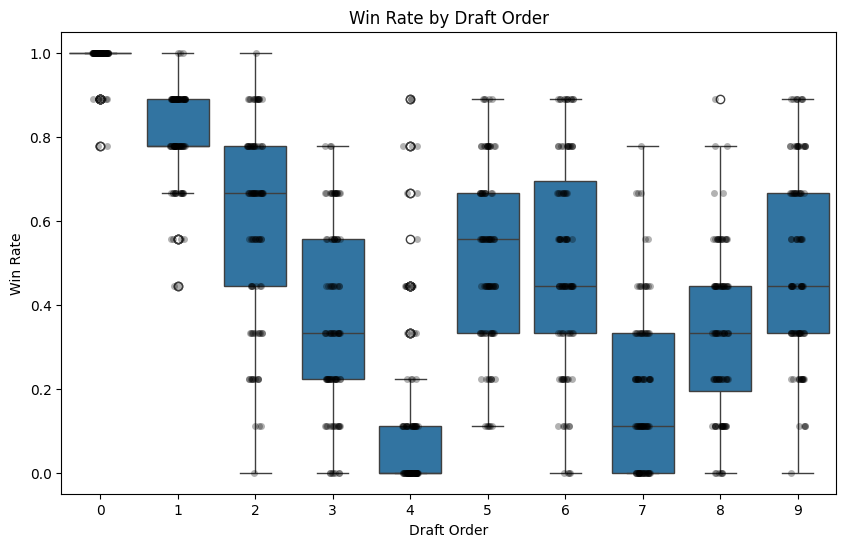

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.DataFrame(regression_data)

plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x="DraftOrder", y="WinRate")
sns.stripplot(data=df, x="DraftOrder", y="WinRate", color='black', alpha=0.3)
plt.title("Win Rate by Draft Order")
plt.xlabel("Draft Order")
plt.ylabel("Win Rate")
plt.show()


In [ ]:
# 確保欄位格式正確
df["DraftOrder"] = df["DraftOrder"].astype(int)
df["WinRate"] = pd.to_numeric(df["WinRate"], errors="coerce")

# Group by DraftOrder and Strategy
grouped = df.groupby(["DraftOrder", "Strategy"]).agg(
    mean_win_rate=("WinRate", "mean"),
    std_win_rate=("WinRate", "std"),
    count=("WinRate", "count")
).reset_index()

# 轉成橫向表格（更好看）
pivot_table = grouped.pivot(index="DraftOrder", columns="Strategy", values="mean_win_rate").round(3)

# 顯示
print(pivot_table)


Strategy    Random     S1     S2     S3     S4
DraftOrder                                    
0            0.988  0.987  0.995  0.966  1.000
1            0.765  0.811  0.839  0.714  0.840
2            0.481  0.639  0.672  0.513  0.600
3            0.235  0.438  0.365  0.411  0.407
4            0.148  0.198  0.105  0.130  0.105
5            0.487  0.556  0.480  0.516  0.523
6            0.456  0.488  0.556  0.525  0.517
7            0.202  0.185  0.209  0.179  0.213
8            0.360  0.278  0.306  0.378  0.323
9            0.523  0.540  0.502  0.491  0.477


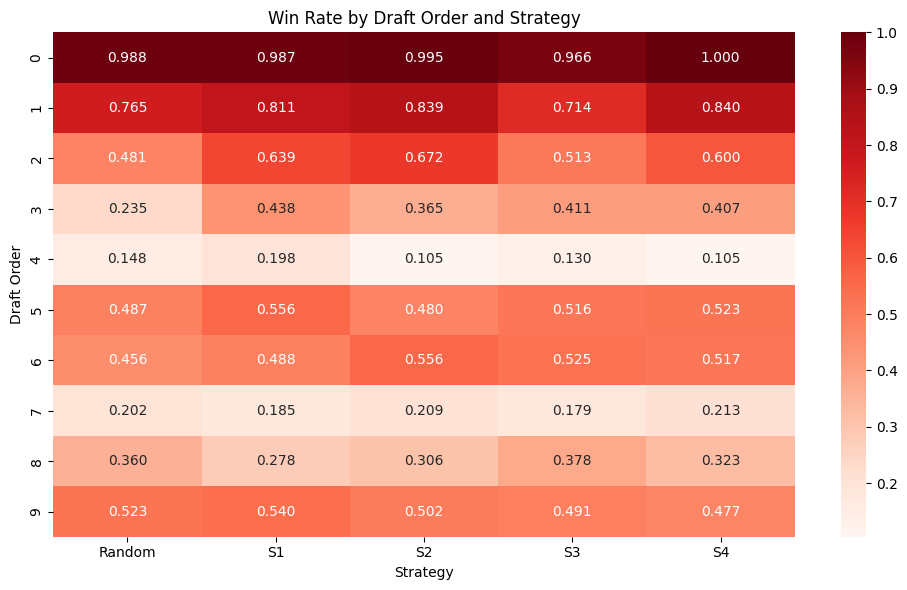

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, annot=True, cmap="Reds", fmt=".3f")
plt.title("Win Rate by Draft Order and Strategy")
plt.xlabel("Strategy")
plt.ylabel("Draft Order")
plt.tight_layout()
plt.show()


### Model 4, Reinforcement Learning to build the best strategy

In [ ]:
import numpy as np
import pandas as pd
from collections import defaultdict
import random
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import pickle
import os

# Position limits for each team (total 23 players per team)
POSITION_LIMITS = {
    "C": 1, "1B": 1, "2B": 1, "3B": 1, "SS": 1, "OF": 3,
    "UTIL": 2, "SP": 2, "RP": 2, "P": 4, "BN": 5
}

# 20 categories for scoring (10 batting, 10 pitching)
batting_stats = ["H_batter", "HR", "RBI", "SB", "BB_batter", "K_batter", "FPCT", "AVG", "OBP", "SLG"]
pitching_stats = ["W", "OUT", "H_pitcher", "ER", "BB_pitcher", "K_pitcher", "ERA", "WHIP", "QS", "SV+H"]
categories = batting_stats + pitching_stats

# DQN class for reinforcement learning
class DQN:
    def __init__(self, state_dim, action_dim, learning_rate=0.001):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.model = self.build_model()
        self.target_model = self.build_model()
        self.target_model.set_weights(self.model.get_weights())
        self.gamma = 0.99
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.memory = []
        self.batch_size = 32
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    def build_model(self):
        model = models.Sequential([
            layers.Input(shape=(self.state_dim,)),
            layers.Dense(64, activation='relu'),
            layers.Dense(128, activation='relu'),
            layers.Dense(64, activation='relu'),
            layers.Dense(self.action_dim, activation='linear')
        ])
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')
        return model

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.randint(self.action_dim)
        state = np.array(state).reshape(1, -1)
        q_values = self.model.predict(state, verbose=0)
        return np.argmax(q_values[0])

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def replay(self):
        if len(self.memory) < self.batch_size:
            return
        batch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        states = np.array(states)
        next_states = np.array(next_states)
        rewards = np.array(rewards)
        dones = np.array(dones)

        targets = self.model.predict(states, verbose=0)
        next_q_values = self.target_model.predict(next_states, verbose=0)
        for i in range(self.batch_size):
            if dones[i]:
                targets[i][actions[i]] = rewards[i]
            else:
                targets[i][actions[i]] = rewards[i] + self.gamma * np.max(next_q_values[i])

        self.model.fit(states, targets, epochs=1, verbose=0)

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

    def save(self, path):
        self.model.save(os.path.join(path, "dqn_model.keras"))
        with open(os.path.join(path, "dqn_memory.pkl"), "wb") as f:
            pickle.dump({
                "memory": self.memory,
                "epsilon": self.epsilon
            }, f)
        print(f"DQN model and memory saved to {path}")

    def load(self, path):
        self.model = tf.keras.models.load_model(os.path.join(path, "dqn_model.keras"))
        self.target_model = tf.keras.models.load_model(os.path.join(path, "dqn_model.keras"))
        with open(os.path.join(path, "dqn_memory.pkl"), "rb") as f:
            data = pickle.load(f)
            self.memory = data["memory"]
            self.epsilon = data["epsilon"]
        print(f"DQN model and memory loaded from {path}")

# FantasyDraftEnv class for managing the draft simulation
class FantasyDraftEnv:
    def __init__(self, df_players, rounds=23, num_teams=10, team_strategies=None):
        df_players = df_players.copy().drop_duplicates(subset=["Name"], keep="first")
        for col in ["PCA_Batter_Score", "PCA_Pitcher_Score"]:
            if col not in df_players.columns:
                df_players[col] = 0.0
        df_players["Max_PCA_Score"] = df_players[["PCA_Batter_Score", "PCA_Pitcher_Score"]].max(axis=1)

        if "Pos" not in df_players.columns:
            raise ValueError("No Pos Data！")

        def parse_positions(pos):
            if pd.isna(pos) or not isinstance(pos, str):
                return ["UTIL"]
            for sep in [", "]:
                if sep in pos:
                    return [p.strip() for p in pos.split(sep) if p.strip()]
            return [pos.strip()]

        df_players["Pos_List"] = df_players["Pos"].apply(parse_positions)
        self.df_players = df_players.reset_index(drop=True)
        self.rounds = rounds
        self.num_teams = num_teams
        self.team_strategies = team_strategies if team_strategies is not None else {i: "Random" for i in range(num_teams)}
        self.standard_positions = ["C", "1B", "2B", "3B", "SS", "OF", "SP", "RP"]
        self.batter_positions = ["C", "1B", "2B", "3B", "SS", "OF"]
        self.pitcher_positions = ["SP", "RP"]
        self.categories = categories

        '''
        # Debug: Check df_players data
        print("df_players columns:", self.df_players.columns)
        for cat in self.categories:
            if cat in self.df_players.columns:
                print(f"Category {cat} stats: min={self.df_players[cat].min()}, max={self.df_players[cat].max()}, mean={self.df_players[cat].mean()}")
            else:
                print(f"Category {cat} is missing in df_players!")
        '''
        self.scaler = StandardScaler()
        self.df_players[self.categories] = self.scaler.fit_transform(self.df_players[self.categories])

    def reset(self):
        self.current_round = 0
        self.current_pick = 0
        self.snake_order = list(range(self.num_teams)) + list(range(self.num_teams - 1, -1, -1))
        self.teams = {i: {"players": [], "position_counts": defaultdict(int)} for i in range(self.num_teams)}
        self.available_players = self.df_players.copy()
        self.team_picks = {i: 0 for i in range(self.num_teams)}
        return self.get_state(0)

    def get_state(self, team_id):
        team_players = pd.DataFrame(self.teams[team_id]["players"])
        if team_players.empty:
            own_stats = np.zeros(len(self.categories))
        else:
            own_stats = team_players[self.categories].sum().values

        other_teams_stats = []
        for other_team_id in range(self.num_teams):
            if other_team_id == team_id:
                continue
            other_team_players = pd.DataFrame(self.teams[other_team_id]["players"])
            if other_team_players.empty:
                other_teams_stats.append(np.zeros(len(self.categories)))
            else:
                other_teams_stats.append(other_team_players[self.categories].sum().values)
        other_teams_stats = np.array(other_teams_stats)
        other_stats_mean = np.mean(other_teams_stats, axis=0) if len(other_teams_stats) > 0 else np.zeros(len(self.categories))
        other_stats_std = np.std(other_teams_stats, axis=0) if len(other_teams_stats) > 0 else np.zeros(len(self.categories))

        available = self.available_players.copy()
        if available.empty:
            available_stats = np.zeros(len(self.categories))
        else:
            available["Sort_Key"] = available.apply(
                lambda row: row["H_batter"] if any(pos in self.batter_positions for pos in row["Pos_List"]) else row["K_pitcher"], axis=1)
            top_5 = available.nlargest(5, "Sort_Key")
            available_stats = top_5[self.categories].mean().values

        round_number = self.current_round
        state = np.concatenate([own_stats, other_stats_mean, other_stats_std, available_stats, [round_number]])
        return state

    def get_team_needs(self, team_id, strategy=None):
        pos_counts = self.teams[team_id]["position_counts"]
        needs = [pos for pos in self.standard_positions if pos_counts[pos] < POSITION_LIMITS[pos]]

        if not needs:
            if pos_counts["UTIL"] < POSITION_LIMITS["UTIL"]:
                needs.append("UTIL")
            if pos_counts["P"] < POSITION_LIMITS["P"]:
                needs.append("P")

        if not needs and pos_counts["BN"] < POSITION_LIMITS["BN"]:
            needs.append("BN")

        if not needs:
            return "BN"

        # Use the provided strategy if available, otherwise use team_strategies
        if strategy is None:
            strategy = self.team_strategies[team_id]

        available_players = self.available_players.copy()
        available_players["Relevant_PCA_Score"] = available_players.apply(
            lambda row: row["PCA_Pitcher_Score"] if any(pos in ["SP", "RP", "P"] for pos in row["Pos_List"]) else row["PCA_Batter_Score"],
            axis=1
        )
        self.available_players = available_players

        def find_max_pca_position(positions):
            max_pos = None
            max_score = -float("inf")
            for pos in positions:
                if pos in ["UTIL", "P", "BN"]:
                    if pos == "UTIL":
                        available_for_pos = self.available_players[self.available_players["Pos_List"].apply(lambda x: any(p in self.batter_positions for p in x))]
                    if pos == "P":
                        available_for_pos = self.available_players[self.available_players["Pos_List"].apply(lambda x: any(p in self.pitcher_positions for p in x))]
                    if pos == "BN":
                        available_for_pos = self.available_players
                else:
                    available_for_pos = self.available_players[self.available_players["Pos_List"].apply(lambda x: pos in x)]
                if not available_for_pos.empty:
                    pos_max_pca = available_for_pos["Relevant_PCA_Score"].max()
                    if pos_max_pca > max_score:
                        max_score = pos_max_pca
                        max_pos = pos
            return max_pos if max_pos else "BN"

        def find_max_weighted_position(positions):
            max_pos = None
            max_weighted_score = -float("inf")
            if not self.available_players.empty:
                top_20_pca = self.available_players["Relevant_PCA_Score"].nlargest(20)
                base_bonus = top_20_pca.mean() if not top_20_pca.empty else 0
            else:
                base_bonus = 0

            remaining_ratios = {}
            for pos in POSITION_LIMITS:
                total_slots = POSITION_LIMITS[pos]
                remaining_slots = max(0, total_slots - pos_counts[pos])
                remaining_ratios[pos] = remaining_slots / total_slots if total_slots > 0 else 0

            for pos in positions:
                if pos in ["UTIL", "P", "BN"]:
                    if pos == "UTIL":
                        available_for_pos = self.available_players[self.available_players["Pos_List"].apply(lambda x: any(p in self.batter_positions for p in x))]
                    if pos == "P":
                        available_for_pos = self.available_players[self.available_players["Pos_List"].apply(lambda x: any(p in self.pitcher_positions for p in x))]
                    if pos == "BN":
                        available_for_pos = self.available_players
                else:
                    available_for_pos = self.available_players[self.available_players["Pos_List"].apply(lambda x: pos in x)]

                if not available_for_pos.empty:
                    for _, row in available_for_pos.iterrows():
                        pca_score = row["Relevant_PCA_Score"]
                        if pos in remaining_ratios:
                            remaining_ratio = remaining_ratios[pos]
                            position_bonus = base_bonus * remaining_ratio if pos in needs else 0
                        else:
                            position_bonus = 0
                        weighted_score = 0.7 * pca_score + 0.3 * position_bonus
                        if weighted_score > max_weighted_score:
                            max_weighted_score = weighted_score
                            max_pos = pos
            return max_pos if max_pos else "BN"

        def find_s4_position(positions):
            pca_stats = {}
            for pos in positions:
                if pos in ["UTIL", "P", "BN"]:
                    if pos == "UTIL":
                        available_for_pos = self.available_players[self.available_players["Pos_List"].apply(lambda x: any(p in self.batter_positions for p in x))]
                    elif pos == "P":
                        available_for_pos = self.available_players[self.available_players["Pos_List"].apply(lambda x: any(p in self.pitcher_positions for p in x))]
                    elif pos == "BN":
                        available_for_pos = self.available_players
                else:
                    available_for_pos = self.available_players[self.available_players["Pos_List"].apply(lambda x: pos in x)]

                if not available_for_pos.empty:
                    sorted_players = available_for_pos.sort_values(by="Relevant_PCA_Score", ascending=False)
                    top_5 = sorted_players.head(5)
                    top_5_avg = top_5["Relevant_PCA_Score"].mean() if not top_5.empty else 0
                    mid_tier = sorted_players.iloc[5:15]
                    mid_tier_avg = mid_tier["Relevant_PCA_Score"].mean() if not mid_tier.empty else 0
                    if top_5_avg > 0 and mid_tier_avg > 0:
                        gap = top_5_avg - mid_tier_avg
                        relative_gap = gap / top_5_avg
                    else:
                        relative_gap = 0
                    pca_stats[pos] = {"relative_gap": relative_gap, "top_5_avg": top_5_avg}
                else:
                    pca_stats[pos] = {"relative_gap": 0, "top_5_avg": 0}

            top_5_avgs = [stats["top_5_avg"] for stats in pca_stats.values()]
            if top_5_avgs and max(top_5_avgs) > min(top_5_avgs):
                top_5_min = min(top_5_avgs)
                top_5_max = max(top_5_avgs)
                top_5_range = top_5_max - top_5_min
            else:
                top_5_min = 0
                top_5_max = 0
                top_5_range = 0

            if self.current_round < 10:
                weight_relative_gap = 0.3
                weight_top_5 = 0.7
            elif self.current_round < 15:
                weight_relative_gap = 0.5
                weight_top_5 = 0.5
            else:
                weight_relative_gap = 0.7
                weight_top_5 = 0.3

            weighted_scores = {}
            for pos in pca_stats.keys():
                top_5_avg = pca_stats[pos].get("top_5_avg", 0)
                normalized_top_5 = (top_5_avg - top_5_min) / top_5_range if top_5_range > 0 else 0
                pca_stats[pos]["normalized_top_5"] = normalized_top_5
                relative_gap = pca_stats[pos].get("relative_gap", 0)
                weighted_score = (weight_relative_gap * relative_gap) + (weight_top_5 * normalized_top_5)
                weighted_scores[pos] = weighted_score

            if weighted_scores:
                max_score_pos = max(weighted_scores, key=weighted_scores.get)
                return max_score_pos
            else:
                return find_max_pca_position(positions)

        if strategy == "S1":
            return find_max_pca_position(needs)
        elif strategy == "S2":
            return find_max_weighted_position(needs)
        elif strategy == "S4":
            return find_s4_position(needs)
        else:  # Random or RL (RL will override strategy in pick_player)
            remaining_ratios = {}
            for pos in POSITION_LIMITS:
                total_slots = POSITION_LIMITS[pos]
                remaining_slots = max(0, total_slots - pos_counts[pos])
                remaining_ratios[pos] = remaining_slots / total_slots if total_slots > 0 else 0
            weights = [remaining_ratios.get(pos, 0) for pos in needs]
            total_weight = sum(weights)
            if total_weight > 0:
                weights = [w / total_weight for w in weights]
                return random.choices(needs, weights=weights, k=1)[0]
            else:
                return random.choice(needs)

    def pick_player(self, team_id, strategy=None):
        if self.team_picks[team_id] >= 23:
            return None, None

        # If strategy is provided (e.g., for RL), use it; otherwise, use team_strategies
        if strategy is None:
            strategy = self.team_strategies[team_id]

        target_pos = self.get_team_needs(team_id, strategy)
        if not target_pos:
            print(f"Team {team_id} (Strategy: {strategy}) - No target position available!")
            return None, None

        pos_counts = self.teams[team_id]["position_counts"]
        batter_positions = ["C", "1B", "2B", "3B", "SS", "OF"]
        pitcher_positions = ["SP", "RP"]

        if not self.available_players.index.is_unique:
            self.available_players = self.available_players.reset_index(drop=True)

        pca_threshold = self.available_players[["PCA_Batter_Score", "PCA_Pitcher_Score"]].max(axis=1).quantile(0.90)
        elite_batter_threshold = max(8.0, pca_threshold)
        elite_batter_players = self.available_players[
            (self.available_players["Pos_List"].apply(lambda x: "DH" in x or any(pos in batter_positions for pos in x))) &
            (self.available_players["PCA_Batter_Score"] >= elite_batter_threshold)
        ].copy().reset_index(drop=True)

        if not elite_batter_players.index.is_unique:
            elite_batter_players = elite_batter_players.reset_index(drop=True)

        pick = None
        assigned_pos = target_pos

        if not elite_batter_players.empty and pos_counts["UTIL"] < POSITION_LIMITS["UTIL"]:
            elite_batter_players["Relevant_PCA_Score"] = elite_batter_players["PCA_Batter_Score"]
            elite_best = elite_batter_players.nlargest(1, "Relevant_PCA_Score").iloc[0]

            available_players = self.available_players.copy()
            if target_pos in ["SP", "RP", "P"]:
                available_players["Relevant_PCA_Score"] = available_players["PCA_Pitcher_Score"]
            elif target_pos in ["C", "1B", "2B", "3B", "SS", "OF", "UTIL"]:
                available_players["Relevant_PCA_Score"] = available_players["PCA_Batter_Score"]
            else:
                available_players["Relevant_PCA_Score"] = available_players[["PCA_Batter_Score", "PCA_Pitcher_Score"]].max(axis=1)
            self.available_players = available_players

            top_players = self.available_players.nlargest(5, "Relevant_PCA_Score")
            max_non_elite_batter_score = top_players[~top_players.index.isin(elite_batter_players.index)]["Relevant_PCA_Score"].max() if not top_players.empty else -float("inf")
            elite_score = elite_best["Relevant_PCA_Score"]

            if max_non_elite_batter_score > elite_score:
                available_top = top_players[
                    top_players["Pos_List"].apply(lambda x: any(pos in x for pos in POSITION_LIMITS if pos_counts[pos] < POSITION_LIMITS[pos]))
                ].copy().reset_index(drop=True)
                if not available_top.empty:
                    pick = available_top.nlargest(1, "Relevant_PCA_Score").iloc[0]
                    player_positions = pick["Pos_List"]
                    player_positions = ["UTIL" if pos == "DH" else pos for pos in player_positions]
                    valid_positions = [pos for pos in player_positions if pos_counts[pos] < POSITION_LIMITS[pos]]
                    if valid_positions:
                        assigned_pos = valid_positions[0]
                    else:
                        if any(pos in batter_positions for pos in player_positions) and pos_counts["UTIL"] < POSITION_LIMITS["UTIL"]:
                            assigned_pos = "UTIL"
                        elif any(pos in pitcher_positions for pos in player_positions) and pos_counts["P"] < POSITION_LIMITS["P"]:
                            assigned_pos = "P"
                        else:
                            assigned_pos = "BN"
            else:
                pick = elite_best
                assigned_pos = "UTIL"

        else:
            available = self.available_players.copy()
            if target_pos in ["UTIL"]:
                mask = available["Pos_List"].apply(lambda x: any(pos in x for pos in batter_positions + ["DH"]))
                available = available[mask].reset_index(drop=True)
            elif target_pos in ["P"]:
                mask = available["Pos_List"].apply(lambda x: any(pos in x for pos in pitcher_positions))
                available = available[mask].reset_index(drop=True)
            elif target_pos == "BN":
                available = available.copy().reset_index(drop=True)
            else:
                mask = available["Pos_List"].apply(lambda x: target_pos in x)
                available = available[mask].reset_index(drop=True)

            if available.empty:
                print(f"Team {team_id} (Strategy: {strategy}) - No players available for {target_pos}!")
                # Fallback: Try to pick any available player
                available = self.available_players.copy()
                if available.empty:
                    print(f"Team {team_id} (Strategy: {strategy}) - No players available at all!")
                    return None, None
                pick = available.nlargest(1, "Relevant_PCA_Score").iloc[0]
                player_positions = pick["Pos_List"]
                player_positions = ["UTIL" if pos == "DH" else pos for pos in player_positions]
                valid_positions = [pos for pos in player_positions if pos_counts[pos] < POSITION_LIMITS[pos]]
                if valid_positions:
                    assigned_pos = valid_positions[0]
                else:
                    if any(pos in batter_positions for pos in player_positions) and pos_counts["UTIL"] < POSITION_LIMITS["UTIL"]:
                        assigned_pos = "UTIL"
                    elif any(pos in pitcher_positions for pos in player_positions) and pos_counts["P"] < POSITION_LIMITS["P"]:
                        assigned_pos = "P"
                    else:
                        assigned_pos = "BN"
            else:
                pick = available.nlargest(1, "Relevant_PCA_Score").iloc[0]
                player_positions = pick["Pos_List"]
                player_positions = ["UTIL" if pos == "DH" else pos for pos in player_positions]

                valid_positions = [pos for pos in player_positions if pos_counts[pos] < POSITION_LIMITS[pos]]
                if valid_positions:
                    assigned_pos = valid_positions[0]
                else:
                    if any(pos in batter_positions for pos in player_positions) and pos_counts["UTIL"] < POSITION_LIMITS["UTIL"]:
                        assigned_pos = "UTIL"
                    elif any(pos in pitcher_positions for pos in player_positions) and pos_counts["P"] < POSITION_LIMITS["P"]:
                        assigned_pos = "P"
                    else:
                        assigned_pos = "BN"

        if pick is not None:
            if isinstance(pick, pd.Series):
                pick_dict = pick.to_dict()
            else:
                raise ValueError(f"Unexpected pick type: {type(pick)}. Expected Series.")
            pick_dict["Assigned_Pos"] = assigned_pos
            self.teams[team_id]["players"].append(pick_dict)
            self.teams[team_id]["position_counts"][assigned_pos] += 1
            self.team_picks[team_id] += 1
            self.available_players = self.available_players[self.available_players["Name"] != pick["Name"]]
            return pick, assigned_pos
        return None, None

    def adjust_positions(self):
        for team_id in range(self.num_teams):
            pos_counts = self.teams[team_id]["position_counts"]
            players = self.teams[team_id]["players"]
            standard_positions = ["C", "1B", "2B", "3B", "SS", "OF", "SP", "RP"]
            batter_positions = ["C", "1B", "2B", "3B", "SS", "OF"]
            pitcher_positions = ["SP", "RP"]

            while True:
                adjusted = False
                for pos in standard_positions:
                    limit = POSITION_LIMITS[pos]
                    if pos_counts[pos] > limit:
                        for i, player in enumerate(players):
                            if player["Assigned_Pos"] == pos:
                                if pos in batter_positions:
                                    if pos_counts["UTIL"] < POSITION_LIMITS["UTIL"]:
                                        pos_counts[pos] -= 1
                                        pos_counts["UTIL"] += 1
                                        player["Assigned_Pos"] = "UTIL"
                                        adjusted = True
                                        break
                                    elif pos_counts["BN"] < POSITION_LIMITS["BN"]:
                                        pos_counts[pos] -= 1
                                        pos_counts["BN"] += 1
                                        player["Assigned_Pos"] = "BN"
                                        adjusted = True
                                        break
                                elif pos in pitcher_positions:
                                    if pos_counts["P"] < POSITION_LIMITS["P"]:
                                        pos_counts[pos] -= 1
                                        pos_counts["P"] += 1
                                        player["Assigned_Pos"] = "P"
                                        adjusted = True
                                        break
                                    elif pos_counts["BN"] < POSITION_LIMITS["BN"]:
                                        pos_counts[pos] -= 1
                                        pos_counts["BN"] += 1
                                        player["Assigned_Pos"] = "BN"
                                        adjusted = True
                                        break

                for pos in ["UTIL", "P"]:
                    limit = POSITION_LIMITS[pos]
                    if pos_counts[pos] < limit:
                        for i, player in enumerate(players):
                            current_pos = player["Assigned_Pos"]
                            if current_pos == "BN":
                                if pos == "UTIL" and any(p in batter_positions for p in player["Pos_List"]):
                                    pos_counts["BN"] -= 1
                                    pos_counts["UTIL"] += 1
                                    player["Assigned_Pos"] = "UTIL"
                                    adjusted = True
                                    break
                                elif pos == "P" and any(p in pitcher_positions for p in player["Pos_List"]):
                                    pos_counts["BN"] -= 1
                                    pos_counts["P"] += 1
                                    player["Assigned_Pos"] = "P"
                                    adjusted = True
                                    break

                if not adjusted:
                    break

    def check_position_limits(self):
        for team_id, team in self.teams.items():
            pos_counts = team["position_counts"]
            player_count = len(team["players"])
            strategy = self.team_strategies[team_id]
            if player_count != 23:
                print(f"Team {team_id} (Strategy: {strategy}) has {player_count} players, expected 23")
                return False
            for pos, limit in POSITION_LIMITS.items():
                if pos_counts[pos] != limit:
                    print(f"Team {team_id} (Strategy: {strategy}) position {pos}: {pos_counts[pos]} players, expected {limit}")
                    return False
        return True

    def simulate_h2h_matchups(self):
        matchup_history = {f"team_{i}_vs_{j}": [0, 0, 0] for i in range(self.num_teams) for j in range(self.num_teams) if i != j}
        categories_dict = {
            "H_batter": "higher", "HR": "higher", "RBI": "higher", "SB": "higher", "BB_batter": "higher", "K_batter": "lower", "AVG": "higher", "OBP": "higher", "SLG": "higher", "FPCT": "higher",
            "W": "higher", "OUT": "higher", "H_pitcher": "lower", "ER": "lower", "K_pitcher": "higher", "ERA": "lower", "WHIP": "lower", "QS": "higher", "SV+H": "higher"
        }
        available_categories = [cat for cat in categories_dict if cat in self.df_players.columns]
        # print("Available categories:", available_categories)
        '''
        # Debug: Print detailed stats for each team
        for team_id in range(self.num_teams):
            team_players = pd.DataFrame(self.teams[team_id]["players"]).reset_index(drop=True)
            if team_players.empty:
                print(f"Team {team_id} (Strategy: {self.team_strategies[team_id]}) has no players!")
            else:
                print(f"Team {team_id} (Strategy: {self.team_strategies[team_id]}) stats:")
                print(team_players[available_categories].sum())
        '''
        for team_i in range(self.num_teams):
            for team_j in range(team_i + 1, self.num_teams):
                team_i_players = pd.DataFrame(self.teams[team_i]["players"]).reset_index(drop=True)
                team_j_players = pd.DataFrame(self.teams[team_j]["players"]).reset_index(drop=True)
                team_i_stats = team_i_players[available_categories].sum() if not team_i_players.empty else pd.Series(0, index=available_categories)
                team_j_stats = team_j_players[available_categories].sum() if not team_j_players.empty else pd.Series(0, index=available_categories)
                wins, losses, ties = 0, 0, 0

                print(f"\nMatchup: Team {team_i} vs Team {team_j}")
                print(f"Team {team_i} stats:", team_i_stats)
                print(f"Team {team_j} stats:", team_j_stats)

                for cat in available_categories:
                    direction = categories_dict[cat]
                    # print(f"Category {cat} (direction: {direction}): Team {team_i} = {team_i_stats[cat]}, Team {team_j} = {team_j_stats[cat]}")
                    if direction == "higher":
                        if team_i_stats[cat] > team_j_stats[cat]:
                            wins += 1
                            # print(f"Team {team_i} wins this category")
                        elif team_i_stats[cat] < team_j_stats[cat]:
                            losses += 1
                            # print(f"Team {team_j} wins this category")
                        else:
                            ties += 1
                            # print("Tie in this category")
                    elif direction == "lower":
                        if team_i_stats[cat] < team_j_stats[cat]:
                            wins += 1
                            # print(f"Team {team_i} wins this category")
                        elif team_i_stats[cat] > team_j_stats[cat]:
                            losses += 1
                            # print(f"Team {team_j} wins this category")
                        else:
                            ties += 1
                            # print("Tie in this category")

                print(f"Result: Wins = {wins}, Losses = {losses}, Ties = {ties}")
                if wins > losses:
                    matchup_history[f"team_{team_i}_vs_{team_j}"][0] += 1
                    matchup_history[f"team_{team_j}_vs_{team_i}"][1] += 1
                    # print(f"Team {team_i} wins the matchup")
                elif wins < losses:
                    matchup_history[f"team_{team_i}_vs_{team_j}"][1] += 1
                    matchup_history[f"team_{team_j}_vs_{team_i}"][0] += 1
                    # print(f"Team {team_j} wins the matchup")
                else:
                    matchup_history[f"team_{team_i}_vs_{team_j}"][2] += 1
                    matchup_history[f"team_{team_j}_vs_{team_i}"][2] += 1
                    # print("Matchup ends in a tie")

        # Debug: Print matchup_history
        print("\nMatchup History:")
        for key, value in matchup_history.items():
            print(f"{key}: Wins={value[0]}, Losses={value[1]}, Ties={value[2]}")

        team_ranks = []
        for team_id in range(self.num_teams):
            wins = sum(matchup_history[f"team_{team_id}_vs_{j}"][0] for j in range(self.num_teams) if j != team_id)
            win_rate = wins / (self.num_teams - 1)
            print(f"Team {team_id} (Strategy: {self.team_strategies[team_id]}) wins: {wins}, win_rate: {win_rate}")
            team_ranks.append((team_id, win_rate))
        team_ranks.sort(key=lambda x: x[1], reverse=True)
        ranks = {team_id: rank + 1 for rank, (team_id, _) in enumerate(team_ranks)}

        return matchup_history, ranks

    def step(self, team_id, action):
        strategy_map = {0: "S1", 1: "S2", 2: "S4"}
        strategy = strategy_map[action]
        pick_result = self.pick_player(team_id, strategy)

        next_state = self.get_state(team_id)
        done = self.team_picks[team_id] >= 23

        reward = 0.0
        if pick_result:
            pick, _ = pick_result
            pca_score = pick["Relevant_PCA_Score"]
            top_pca = self.available_players["Relevant_PCA_Score"].nlargest(5).mean() if not self.available_players.empty else 0
            if pca_score > top_pca:
                reward += 0.1

        if done:
            self.adjust_positions()
            reward = 0.0  # Placeholder; actual reward will be set in run_simulations_with_rl

        return next_state, reward, done, pick_result

def run_simulations_with_rl(df_players, num_episodes=200, num_simulations=50, save_path="/content/drive/My Drive/Sports Analytics/Fantasy Draft Project/"):
    state_dim = 20 + 20 + 20 + 20 + 1
    action_dim = 3
    dqn = DQN(state_dim, action_dim)
    strategies = ["S1", "S2", "S4", "Random", "RL"]
    strategy_wins = {strategy: [] for strategy in strategies}
    regression_data = []

    # Training phase: RL team drafts alongside other teams
    for episode in range(num_episodes):
        print(f"Episode {episode + 1}/{num_episodes}")
        team_strategies = {}
        available_teams = list(range(10))
        for strategy in ["S1", "S1", "S2", "S2", "S4", "S4"]:
            team_id = random.choice(available_teams)
            team_strategies[team_id] = strategy
            available_teams.remove(team_id)
        for _ in range(3):
            team_id = random.choice(available_teams)
            team_strategies[team_id] = "Random"
            available_teams.remove(team_id)
        rl_team_id = available_teams[0]
        team_strategies[rl_team_id] = "RL"

        print("Team strategies:", team_strategies)

        env = FantasyDraftEnv(df_players, team_strategies=team_strategies)
        env.reset()
        active_teams = list(range(env.num_teams))
        total_picks = 0
        pick_index = 0  # Track the index in snake_order
        rl_draft_memory = []  # Store RL team's draft actions to update reward later

        while total_picks < (env.num_teams * env.rounds):
            if not active_teams:
                print("Error: active_teams is empty before reaching total picks!")
                break

            if pick_index % (2 * env.num_teams) == 0:
                forward = [t for t in range(env.num_teams) if t in active_teams]
                backward = [t for t in range(env.num_teams - 1, -1, -1) if t in active_teams]
                env.snake_order = forward + backward
                print(f"Updated snake_order: {env.snake_order}")

            team_id = env.snake_order[pick_index % len(env.snake_order)]
            if team_id not in active_teams:
                print(f"Error: Team {team_id} not in active_teams at pick {env.current_pick}")
                pick_index += 1
                env.current_pick += 1
                continue

            if env.team_picks[team_id] >= 23:
                if team_id in active_teams:
                    active_teams.remove(team_id)
                pick_index += 1
                env.current_pick += 1
                continue

            strategy = team_strategies[team_id]
            if team_id == rl_team_id:
                state = env.get_state(team_id)
                action = dqn.act(state)
                strategy_map = {0: "S1", 1: "S2", 2: "S4"}
                strategy = strategy_map[action]
                next_state, reward, done, pick_result = env.step(team_id, action)
                rl_draft_memory.append((state, action, reward, next_state, done))
                dqn.replay()
                if done:
                    dqn.update_target_model()
                display_strategy = "RL"
            else:
                pick_result = env.pick_player(team_id, strategy)
                display_strategy = strategy

            if pick_result:
                print(f"Team {team_id} (Strategy: {display_strategy}) picked a player at pick {env.current_pick}")
                total_picks += 1
                if env.team_picks[team_id] >= 23:
                    if team_id in active_teams:
                        active_teams.remove(team_id)
            else:
                print(f"Team {team_id} (Strategy: {display_strategy}) failed to pick a player at pick {env.current_pick}")
                break  # Stop the draft if a team cannot pick a player

            pick_index += 1
            env.current_pick += 1
            if env.current_pick % env.num_teams == 0:
                env.current_round += 1

        env.adjust_positions()
        if not env.check_position_limits():
            print("Position limits check failed, skipping episode.")
            continue

        # Calculate final rewards for RL team
        matchup_history, ranks = env.simulate_h2h_matchups()
        for team_id in range(env.num_teams):
            wins = sum(matchup_history[f"team_{team_id}_vs_{j}"][0] for j in range(env.num_teams) if j != team_id)
            total_games = env.num_teams - 1
            win_rate = float(wins / total_games) if total_games > 0 else 0.0
            strategy = team_strategies[team_id]
            strategy_wins[strategy].append(win_rate)
            regression_data.append({
                "Simulation": episode,
                "Team": team_id,
                "Strategy": strategy,
                "WinRate": win_rate,
                "DraftOrder": team_id
            })

            # Update RL team's reward based on win_rate and rank
            if team_id == rl_team_id:
                final_reward = win_rate + (10 - ranks[team_id]) * 0.1
                if rl_draft_memory:
                    last_state, last_action, _, last_next_state, last_done = rl_draft_memory[-1]
                    dqn.remember(last_state, last_action, final_reward, last_next_state, last_done)
                    dqn.replay()

    # Testing phase: RL team drafts alongside other teams
    for sim in range(num_simulations):
        print(f"Simulation {sim + 1}/{num_simulations}")
        team_ids = list(range(10))
        random.shuffle(team_ids)
        team_strategies = {
            team_ids[0]: "S1",
            team_ids[1]: "S1",
            team_ids[2]: "S2",
            team_ids[3]: "S2",
            team_ids[4]: "S4",
            team_ids[5]: "S4",
            team_ids[6]: "Random",
            team_ids[7]: "Random",
            team_ids[8]: "Random",
            team_ids[9]: "RL"
        }

        print("Team strategies:", team_strategies)

        env = FantasyDraftEnv(df_players, team_strategies=team_strategies)
        env.reset()
        active_teams = list(range(env.num_teams))
        total_picks = 0
        pick_index = 0

        while total_picks < (env.num_teams * env.rounds):
            if not active_teams:
                print("Error: active_teams is empty before reaching total picks!")
                break

            if pick_index % (2 * env.num_teams) == 0:
                forward = [t for t in range(env.num_teams) if t in active_teams]
                backward = [t for t in range(env.num_teams - 1, -1, -1) if t in active_teams]
                env.snake_order = forward + backward
                print(f"Updated snake_order: {env.snake_order}")

            team_id = env.snake_order[pick_index % len(env.snake_order)]
            if team_id not in active_teams:
                print(f"Error: Team {team_id} not in active_teams at pick {env.current_pick}")
                pick_index += 1
                env.current_pick += 1
                continue

            if env.team_picks[team_id] >= 23:
                if team_id in active_teams:
                    active_teams.remove(team_id)
                pick_index += 1
                env.current_pick += 1
                continue

            strategy = team_strategies[team_id]
            if team_id == rl_team_id:
                state = env.get_state(team_id)
                action = dqn.act(state)
                strategy_map = {0: "S1", 1: "S2", 2: "S4"}
                strategy = strategy_map[action]
                next_state, reward, done, pick_result = env.step(team_id, action)
                display_strategy = "RL"
            else:
                pick_result = env.pick_player(team_id, strategy)
                display_strategy = strategy

            if pick_result:
                print(f"Team {team_id} (Strategy: {display_strategy}) picked a player at pick {env.current_pick}")
                total_picks += 1
                if env.team_picks[team_id] >= 23:
                    if team_id in active_teams:
                        active_teams.remove(team_id)
            else:
                print(f"Team {team_id} (Strategy: {display_strategy}) failed to pick a player at pick {env.current_pick}")
                break  # Stop the draft if a team cannot pick a player

            pick_index += 1
            env.current_pick += 1
            if env.current_pick % env.num_teams == 0:
                env.current_round += 1

        env.adjust_positions()
        if not env.check_position_limits():
            print("Position limits check failed, skipping simulation.")
            continue

        matchup_history, _ = env.simulate_h2h_matchups()
        for team_id in range(env.num_teams):
            wins = sum(matchup_history[f"team_{team_id}_vs_{j}"][0] for j in range(env.num_teams) if j != team_id)
            total_games = env.num_teams - 1
            win_rate = float(wins / total_games) if total_games > 0 else 0.0
            strategy = team_strategies[team_id]
            strategy_wins[strategy].append(win_rate)
            regression_data.append({
                "Simulation": sim + num_episodes,
                "Team": team_id,
                "Strategy": strategy,
                "WinRate": win_rate,
                "DraftOrder": team_id
            })

    print("\n=== Final Strategy Win Rates (Before Adjusting for Draft Order) ===")
    for strategy, win_rates in strategy_wins.items():
        mean_win_rate = np.mean(win_rates) if win_rates else 0.0
        std_win_rate = np.std(win_rates) if win_rates else 0.0
        print(f"{strategy}: Mean Win Rate = {mean_win_rate:.3f}, Std Dev = {std_win_rate:.3f}")

    os.makedirs(save_path, exist_ok=True)
    dqn.save(save_path)
    with open(os.path.join(save_path, "regression_data.pkl"), "wb") as f:
        pickle.dump(regression_data, f)
    print(f"regression_data saved to {os.path.join(save_path, 'regression_data.pkl')}")

    return regression_data, strategy_wins

def run_regression(regression_data, exclude_rl=False):
    if not regression_data:
        print("Error: regression_data is empty.")
        return None, None

    df_regression = pd.DataFrame(regression_data)
    df_regression["WinRate"] = pd.to_numeric(df_regression["WinRate"], errors="coerce").fillna(0.0)
    df_regression["DraftOrder"] = pd.to_numeric(df_regression["DraftOrder"], errors="coerce").fillna(0.0)

    # Debug: Check the data before filtering
    print("Regression data before filtering:")
    print(df_regression.groupby("Strategy")["WinRate"].describe())

    if exclude_rl:
        print("Excluding RL team from regression analysis.")
        df_regression = df_regression[df_regression["Strategy"] != "RL"]

    if df_regression.empty:
        print("Error: After filtering, regression_data is empty.")
        return None, None

    df_regression["DraftOrder"] = df_regression["DraftOrder"].astype(int)
    df_regression = pd.get_dummies(df_regression, columns=["DraftOrder"], prefix="DraftOrder", dtype=int)
    draft_order_columns = [col for col in df_regression.columns if col.startswith("DraftOrder_")]
    if "DraftOrder_0" in draft_order_columns:
        df_regression = df_regression.drop(columns=["DraftOrder_0"])
        draft_order_columns.remove("DraftOrder_0")

    df_regression = pd.get_dummies(df_regression, columns=["Strategy"], prefix="Strategy", dtype=int)
    strategy_columns = [col for col in df_regression.columns if col.startswith("Strategy_")]
    print("Strategy columns:", strategy_columns)
    if "Strategy_Random" in strategy_columns:
        df_regression = df_regression.drop(columns=["Strategy_Random"])
        strategy_columns.remove("Strategy_Random")

    X = df_regression[draft_order_columns + strategy_columns]
    X = sm.add_constant(X)
    for col in X.columns:
        X[col] = X[col].astype(float)
    y = df_regression["WinRate"].astype(float)

    try:
        model = sm.OLS(y, X).fit()
        print("\n=== Regression Results (Adjusting for Draft Order) ===")
        print(model.summary())

        adjusted_win_rates = {}
        for strategy in [col.replace("Strategy_", "") for col in strategy_columns]:
            X_adjusted = X.copy()
            for col in strategy_columns:
                X_adjusted[col] = 1.0 if col == f"Strategy_{strategy}" else 0.0
            for col in draft_order_columns:
                X_adjusted[col] = 0.0
            predicted_win_rate = model.predict(X_adjusted).mean()
            adjusted_win_rates[strategy] = predicted_win_rate

        print("\n=== Adjusted Win Rates (After Controlling for Draft Order) ===")
        for strategy, win_rate in adjusted_win_rates.items():
            print(f"{strategy}: Adjusted Win Rate = {win_rate:.3f}")

        return model, adjusted_win_rates
    except Exception as e:
        print(f"Regression failed: {e}")
        return None, None

# Main program
if __name__ == "__main__":
    # Replace df_merged_2024 with your actual DataFrame
    df_players = df_merged_2024
    missing_positions = []
    required_positions = ["C", "1B", "2B", "3B", "SS", "OF", "UTIL", "SP", "RP", "P"]
    for pos in required_positions:
        if not df_players["Pos"].str.contains(pos, na=False).any() and not (pos == "UTIL" and df_players["Pos"].str.contains("DH", na=False).any()):
            missing_positions.append(pos)

    if missing_positions:
        print(f"Warning: Lack of position: {missing_positions}")
    else:
        regression_data, strategy_wins = run_simulations_with_rl(
            df_players,
            num_episodes=100,
            num_simulations= 100,
            save_path="/content/drive/My Drive/Sports Analytics/Fantasy Draft Project/"
        )
        if regression_data:
            print("\n=== Running Regression Including RL Team ===")
            model, adjusted_win_rates = run_regression(regression_data, exclude_rl=False)

            print("\n=== Running Regression Excluding RL Team ===")
            model_excl_rl, adjusted_win_rates_excl_rl = run_regression(regression_data, exclude_rl=True)
        else:
            print("Error: regression_data is empty.")

Streaming output truncated to the last 5000 lines.
Result: Wins = 9, Losses = 10, Ties = 0

Matchup: Team 6 vs Team 8
Team 6 stats: H_batter     20.963464
HR           24.903787
RBI          22.763531
SB           16.901788
BB_batter    21.389339
K_batter     19.295785
AVG           5.103620
OBP           4.750967
SLG           7.247033
FPCT         -0.287259
W            24.483409
OUT          24.383434
H_pitcher    26.145804
ER           26.256388
K_pitcher    24.910521
ERA          -3.389119
WHIP         -4.232619
QS           29.463735
SV+H         -8.432954
dtype: float64
Team 8 stats: H_batter     21.093992
HR           18.338904
RBI          19.837371
SB           21.139702
BB_batter    17.606689
K_batter     15.091695
AVG           5.626154
OBP           4.800600
SLG           6.240044
FPCT          1.724961
W            23.835909
OUT          26.733522
H_pitcher    25.838081
ER           24.730047
K_pitcher    26.538175
ERA          -4.013691
WHIP         -5.376731
QS         

### Model 4-2, Immediate Reward

In [ ]:
import numpy as np
import pandas as pd
from collections import defaultdict
import random
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import pickle
import os

# Position limits for each team (total 23 players per team)
POSITION_LIMITS = {
    "C": 1, "1B": 1, "2B": 1, "3B": 1, "SS": 1, "OF": 3,
    "UTIL": 2, "SP": 2, "RP": 2, "P": 4, "BN": 5
}

# 20 categories for scoring (10 batting, 10 pitching)
batting_stats = ["H_batter", "HR", "RBI", "SB", "BB_batter", "K_batter", "FPCT", "AVG", "OBP", "SLG"]
pitching_stats = ["W", "OUT", "H_pitcher", "ER", "BB_pitcher", "K_pitcher", "ERA", "WHIP", "QS", "SV+H"]
categories = batting_stats + pitching_stats

# DQN class for reinforcement learning
class DQN:
    def __init__(self, state_dim, action_dim, learning_rate=0.001):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.model = self.build_model()
        self.target_model = self.build_model()
        self.target_model.set_weights(self.model.get_weights())
        self.gamma = 0.99
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.memory = []
        self.batch_size = 32
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    def build_model(self):
        model = models.Sequential([
            layers.Input(shape=(self.state_dim,)),
            layers.Dense(64, activation='relu'),
            layers.Dense(128, activation='relu'),
            layers.Dense(64, activation='relu'),
            layers.Dense(self.action_dim, activation='linear')
        ])
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')
        return model

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.randint(self.action_dim)
        state = np.array(state).reshape(1, -1)
        q_values = self.model.predict(state, verbose=0)
        return np.argmax(q_values[0])

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def replay(self):
        if len(self.memory) < self.batch_size:
            return
        batch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        states = np.array(states)
        next_states = np.array(next_states)
        rewards = np.array(rewards)
        dones = np.array(dones)

        targets = self.model.predict(states, verbose=0)
        next_q_values = self.target_model.predict(next_states, verbose=0)
        for i in range(self.batch_size):
            if dones[i]:
                targets[i][actions[i]] = rewards[i]
            else:
                targets[i][actions[i]] = rewards[i] + self.gamma * np.max(next_q_values[i])

        self.model.fit(states, targets, epochs=1, verbose=0)

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

    def save(self, path):
        self.model.save(os.path.join(path, "dqn_model_v2.keras"))  # 修改名稱，避免覆蓋
        with open(os.path.join(path, "dqn_memory_v2.pkl"), "wb") as f:  # 修改名稱，避免覆蓋
            pickle.dump({
                "memory": self.memory,
                "epsilon": self.epsilon
            }, f)
        print(f"DQN model and memory saved to {path}")

    def load(self, path):
        self.model = tf.keras.models.load_model(os.path.join(path, "dqn_model_v2.keras"))
        self.target_model = tf.keras.models.load_model(os.path.join(path, "dqn_model_v2.keras"))
        with open(os.path.join(path, "dqn_memory_v2.pkl"), "rb") as f:
            data = pickle.load(f)
            self.memory = data["memory"]
            self.epsilon = data["epsilon"]
        print(f"DQN model and memory loaded from {path}")

# FantasyDraftEnv class for managing the draft simulation
class FantasyDraftEnv:
    def __init__(self, df_players, rounds=23, num_teams=10, team_strategies=None):
        df_players = df_players.copy().drop_duplicates(subset=["Name"], keep="first")
        for col in ["PCA_Batter_Score", "PCA_Pitcher_Score"]:
            if col not in df_players.columns:
                df_players[col] = 0.0
        df_players["Max_PCA_Score"] = df_players[["PCA_Batter_Score", "PCA_Pitcher_Score"]].max(axis=1)

        if "Pos" not in df_players.columns:
            raise ValueError("No Pos Data！")

        def parse_positions(pos):
            if pd.isna(pos) or not isinstance(pos, str):
                return ["UTIL"]
            for sep in [", "]:
                if sep in pos:
                    return [p.strip() for p in pos.split(sep) if p.strip()]
            return [pos.strip()]

        df_players["Pos_List"] = df_players["Pos"].apply(parse_positions)
        self.df_players = df_players.reset_index(drop=True)
        self.rounds = rounds
        self.num_teams = num_teams
        self.team_strategies = team_strategies if team_strategies is not None else {i: "Random" for i in range(num_teams)}
        self.standard_positions = ["C", "1B", "2B", "3B", "SS", "OF", "SP", "RP"]
        self.batter_positions = ["C", "1B", "2B", "3B", "SS", "OF"]
        self.pitcher_positions = ["SP", "RP"]
        self.categories = categories

        print("df_players columns:", self.df_players.columns)
        for cat in self.categories:
            if cat in self.df_players.columns:
                print(f"Category {cat} stats: min={self.df_players[cat].min()}, max={self.df_players[cat].max()}, mean={self.df_players[cat].mean()}")
            else:
                print(f"Category {cat} is missing in df_players!")

        self.scaler = StandardScaler()
        self.df_players[self.categories] = self.scaler.fit_transform(self.df_players[self.categories])

    def reset(self):
        self.current_round = 0
        self.current_pick = 0
        self.snake_order = list(range(self.num_teams)) + list(range(self.num_teams - 1, -1, -1))
        self.teams = {i: {"players": [], "position_counts": defaultdict(int)} for i in range(self.num_teams)}
        self.available_players = self.df_players.copy()
        self.team_picks = {i: 0 for i in range(self.num_teams)}
        return self.get_state(0)

    def get_state(self, team_id):
        team_players = pd.DataFrame(self.teams[team_id]["players"])
        if team_players.empty:
            own_stats = np.zeros(len(self.categories))
        else:
            own_stats = team_players[self.categories].sum().values

        other_teams_stats = []
        for other_team_id in range(self.num_teams):
            if other_team_id == team_id:
                continue
            other_team_players = pd.DataFrame(self.teams[other_team_id]["players"])
            if other_team_players.empty:
                other_teams_stats.append(np.zeros(len(self.categories)))
            else:
                other_teams_stats.append(other_team_players[self.categories].sum().values)
        other_teams_stats = np.array(other_teams_stats)
        other_stats_mean = np.mean(other_teams_stats, axis=0) if len(other_teams_stats) > 0 else np.zeros(len(self.categories))
        other_stats_std = np.std(other_teams_stats, axis=0) if len(other_teams_stats) > 0 else np.zeros(len(self.categories))

        available = self.available_players.copy()
        if available.empty:
            available_stats = np.zeros(len(self.categories))
        else:
            available["Sort_Key"] = available.apply(
                lambda row: row["H_batter"] if any(pos in self.batter_positions for pos in row["Pos_List"]) else row["K_pitcher"], axis=1)
            top_5 = available.nlargest(5, "Sort_Key")
            available_stats = top_5[self.categories].mean().values

        round_number = self.current_round
        draft_order = team_id  # 加入選秀順序
        state = np.concatenate([own_stats, other_stats_mean, other_stats_std, available_stats, [round_number], [draft_order]])
        return state

    def get_team_needs(self, team_id, strategy=None):
        pos_counts = self.teams[team_id]["position_counts"]
        needs = [pos for pos in self.standard_positions if pos_counts[pos] < POSITION_LIMITS[pos]]

        if not needs:
            if pos_counts["UTIL"] < POSITION_LIMITS["UTIL"]:
                needs.append("UTIL")
            if pos_counts["P"] < POSITION_LIMITS["P"]:
                needs.append("P")

        if not needs and pos_counts["BN"] < POSITION_LIMITS["BN"]:
            needs.append("BN")

        if not needs:
            return "BN"

        if strategy is None:
            strategy = self.team_strategies[team_id]

        available_players = self.available_players.copy()
        available_players["Relevant_PCA_Score"] = available_players.apply(
            lambda row: row["PCA_Pitcher_Score"] if any(pos in ["SP", "RP", "P"] for pos in row["Pos_List"]) else row["PCA_Batter_Score"],
            axis=1
        )
        self.available_players = available_players

        def find_max_pca_position(positions):
            max_pos = None
            max_score = -float("inf")
            for pos in positions:
                if pos in ["UTIL", "P", "BN"]:
                    if pos == "UTIL":
                        available_for_pos = self.available_players[self.available_players["Pos_List"].apply(lambda x: any(p in self.batter_positions for p in x))]
                    if pos == "P":
                        available_for_pos = self.available_players[self.available_players["Pos_List"].apply(lambda x: any(p in self.pitcher_positions for p in x))]
                    if pos == "BN":
                        available_for_pos = self.available_players
                else:
                    available_for_pos = self.available_players[self.available_players["Pos_List"].apply(lambda x: pos in x)]
                if not available_for_pos.empty:
                    pos_max_pca = available_for_pos["Relevant_PCA_Score"].max()
                    if pos_max_pca > max_score:
                        max_score = pos_max_pca
                        max_pos = pos
            return max_pos if max_pos else "BN"

        def find_max_weighted_position(positions):
            max_pos = None
            max_weighted_score = -float("inf")
            if not self.available_players.empty:
                top_20_pca = self.available_players["Relevant_PCA_Score"].nlargest(20)
                base_bonus = top_20_pca.mean() if not top_20_pca.empty else 0
            else:
                base_bonus = 0

            remaining_ratios = {}
            for pos in POSITION_LIMITS:
                total_slots = POSITION_LIMITS[pos]
                remaining_slots = max(0, total_slots - pos_counts[pos])
                remaining_ratios[pos] = remaining_slots / total_slots if total_slots > 0 else 0

            for pos in positions:
                if pos in ["UTIL", "P", "BN"]:
                    if pos == "UTIL":
                        available_for_pos = self.available_players[self.available_players["Pos_List"].apply(lambda x: any(p in self.batter_positions for p in x))]
                    if pos == "P":
                        available_for_pos = self.available_players[self.available_players["Pos_List"].apply(lambda x: any(p in self.pitcher_positions for p in x))]
                    if pos == "BN":
                        available_for_pos = self.available_players
                else:
                    available_for_pos = self.available_players[self.available_players["Pos_List"].apply(lambda x: pos in x)]

                if not available_for_pos.empty:
                    for _, row in available_for_pos.iterrows():
                        pca_score = row["Relevant_PCA_Score"]
                        if pos in remaining_ratios:
                            remaining_ratio = remaining_ratios[pos]
                            position_bonus = base_bonus * remaining_ratio if pos in needs else 0
                        else:
                            position_bonus = 0
                        weighted_score = 0.7 * pca_score + 0.3 * position_bonus
                        if weighted_score > max_weighted_score:
                            max_weighted_score = weighted_score
                            max_pos = pos
            return max_pos if max_pos else "BN"

        def find_s4_position(positions):
            pca_stats = {}
            for pos in positions:
                if pos in ["UTIL", "P", "BN"]:
                    if pos == "UTIL":
                        available_for_pos = self.available_players[self.available_players["Pos_List"].apply(lambda x: any(p in self.batter_positions for p in x))]
                    elif pos == "P":
                        available_for_pos = self.available_players[self.available_players["Pos_List"].apply(lambda x: any(p in self.pitcher_positions for p in x))]
                    elif pos == "BN":
                        available_for_pos = self.available_players
                else:
                    available_for_pos = self.available_players[self.available_players["Pos_List"].apply(lambda x: pos in x)]

                if not available_for_pos.empty:
                    sorted_players = available_for_pos.sort_values(by="Relevant_PCA_Score", ascending=False)
                    top_5 = sorted_players.head(5)
                    top_5_avg = top_5["Relevant_PCA_Score"].mean() if not top_5.empty else 0
                    mid_tier = sorted_players.iloc[5:15]
                    mid_tier_avg = mid_tier["Relevant_PCA_Score"].mean() if not mid_tier.empty else 0
                    if top_5_avg > 0 and mid_tier_avg > 0:
                        gap = top_5_avg - mid_tier_avg
                        relative_gap = gap / top_5_avg
                    else:
                        relative_gap = 0
                    pca_stats[pos] = {"relative_gap": relative_gap, "top_5_avg": top_5_avg}
                else:
                    pca_stats[pos] = {"relative_gap": 0, "top_5_avg": 0}

            top_5_avgs = [stats["top_5_avg"] for stats in pca_stats.values()]
            if top_5_avgs and max(top_5_avgs) > min(top_5_avgs):
                top_5_min = min(top_5_avgs)
                top_5_max = max(top_5_avgs)
                top_5_range = top_5_max - top_5_min
            else:
                top_5_min = 0
                top_5_max = 0
                top_5_range = 0

            if self.current_round < 10:
                weight_relative_gap = 0.3
                weight_top_5 = 0.7
            elif self.current_round < 15:
                weight_relative_gap = 0.5
                weight_top_5 = 0.5
            else:
                weight_relative_gap = 0.7
                weight_top_5 = 0.3

            weighted_scores = {}
            for pos in pca_stats.keys():
                top_5_avg = pca_stats[pos].get("top_5_avg", 0)
                normalized_top_5 = (top_5_avg - top_5_min) / top_5_range if top_5_range > 0 else 0
                pca_stats[pos]["normalized_top_5"] = normalized_top_5
                relative_gap = pca_stats[pos].get("relative_gap", 0)
                weighted_score = (weight_relative_gap * relative_gap) + (weight_top_5 * normalized_top_5)
                weighted_scores[pos] = weighted_score

            if weighted_scores:
                max_score_pos = max(weighted_scores, key=weighted_scores.get)
                return max_score_pos
            else:
                return find_max_pca_position(positions)

        if strategy == "S1":
            return find_max_pca_position(needs)
        elif strategy == "S2":
            return find_max_weighted_position(needs)
        elif strategy == "S4":
            return find_s4_position(needs)
        else:  # Random or RL (RL will override strategy in pick_player)
            remaining_ratios = {}
            for pos in POSITION_LIMITS:
                total_slots = POSITION_LIMITS[pos]
                remaining_slots = max(0, total_slots - pos_counts[pos])
                remaining_ratios[pos] = remaining_slots / total_slots if total_slots > 0 else 0
            weights = [remaining_ratios.get(pos, 0) for pos in needs]
            total_weight = sum(weights)
            if total_weight > 0:
                weights = [w / total_weight for w in weights]
                return random.choices(needs, weights=weights, k=1)[0]
            else:
                return random.choice(needs)

    def pick_player(self, team_id, strategy=None):
        if self.team_picks[team_id] >= 23:
            return None, None

        if strategy is None:
            strategy = self.team_strategies[team_id]

        target_pos = self.get_team_needs(team_id, strategy)
        if not target_pos:
            return None, None

        pos_counts = self.teams[team_id]["position_counts"]
        batter_positions = ["C", "1B", "2B", "3B", "SS", "OF"]
        pitcher_positions = ["SP", "RP"]

        if not self.available_players.index.is_unique:
            self.available_players = self.available_players.reset_index(drop=True)

        pca_threshold = self.available_players[["PCA_Batter_Score", "PCA_Pitcher_Score"]].max(axis=1).quantile(0.90)
        elite_batter_threshold = max(8.0, pca_threshold)
        elite_batter_players = self.available_players[
            (self.available_players["Pos_List"].apply(lambda x: "DH" in x or any(pos in batter_positions for pos in x))) &
            (self.available_players["PCA_Batter_Score"] >= elite_batter_threshold)
        ].copy().reset_index(drop=True)

        if not elite_batter_players.index.is_unique:
            elite_batter_players = elite_batter_players.reset_index(drop=True)

        pick = None
        assigned_pos = target_pos

        if not elite_batter_players.empty and pos_counts["UTIL"] < POSITION_LIMITS["UTIL"]:
            elite_batter_players["Relevant_PCA_Score"] = elite_batter_players["PCA_Batter_Score"]
            elite_best = elite_batter_players.nlargest(1, "Relevant_PCA_Score").iloc[0]

            available_players = self.available_players.copy()
            if target_pos in ["SP", "RP", "P"]:
                available_players["Relevant_PCA_Score"] = available_players["PCA_Pitcher_Score"]
            elif target_pos in ["C", "1B", "2B", "3B", "SS", "OF", "UTIL"]:
                available_players["Relevant_PCA_Score"] = available_players["PCA_Batter_Score"]
            else:
                available_players["Relevant_PCA_Score"] = available_players[["PCA_Batter_Score", "PCA_Pitcher_Score"]].max(axis=1)
            self.available_players = available_players

            top_players = self.available_players.nlargest(5, "Relevant_PCA_Score")
            max_non_elite_batter_score = top_players[~top_players.index.isin(elite_batter_players.index)]["Relevant_PCA_Score"].max() if not top_players.empty else -float("inf")
            elite_score = elite_best["Relevant_PCA_Score"]

            if max_non_elite_batter_score > elite_score:
                available_top = top_players[
                    top_players["Pos_List"].apply(lambda x: any(pos in x for pos in POSITION_LIMITS if pos_counts[pos] < POSITION_LIMITS[pos]))
                ].copy().reset_index(drop=True)
                if not available_top.empty:
                    pick = available_top.nlargest(1, "Relevant_PCA_Score").iloc[0]
                    player_positions = pick["Pos_List"]
                    player_positions = ["UTIL" if pos == "DH" else pos for pos in player_positions]
                    valid_positions = [pos for pos in player_positions if pos_counts[pos] < POSITION_LIMITS[pos]]
                    if valid_positions:
                        assigned_pos = valid_positions[0]
                    else:
                        if any(pos in batter_positions for pos in player_positions) and pos_counts["UTIL"] < POSITION_LIMITS["UTIL"]:
                            assigned_pos = "UTIL"
                        elif any(pos in pitcher_positions for pos in player_positions) and pos_counts["P"] < POSITION_LIMITS["P"]:
                            assigned_pos = "P"
                        else:
                            assigned_pos = "BN"
            else:
                pick = elite_best
                assigned_pos = "UTIL"

        else:
            available = self.available_players.copy()
            if target_pos in ["UTIL"]:
                mask = available["Pos_List"].apply(lambda x: any(pos in x for pos in batter_positions + ["DH"]))
                available = available[mask].reset_index(drop=True)
            elif target_pos in ["P"]:
                mask = available["Pos_List"].apply(lambda x: any(pos in x for pos in pitcher_positions))
                available = available[mask].reset_index(drop=True)
            elif target_pos == "BN":
                available = available.copy().reset_index(drop=True)
            else:
                mask = available["Pos_List"].apply(lambda x: target_pos in x)
                available = available[mask].reset_index(drop=True)

            if available.empty:
                available = self.available_players.copy()
                if available.empty:
                    return None, None
                pick = available.nlargest(1, "Relevant_PCA_Score").iloc[0]
                player_positions = pick["Pos_List"]
                player_positions = ["UTIL" if pos == "DH" else pos for pos in player_positions]
                valid_positions = [pos for pos in player_positions if pos_counts[pos] < POSITION_LIMITS[pos]]
                if valid_positions:
                    assigned_pos = valid_positions[0]
                else:
                    if any(pos in batter_positions for pos in player_positions) and pos_counts["UTIL"] < POSITION_LIMITS["UTIL"]:
                        assigned_pos = "UTIL"
                    elif any(pos in pitcher_positions for pos in player_positions) and pos_counts["P"] < POSITION_LIMITS["P"]:
                        assigned_pos = "P"
                    else:
                        assigned_pos = "BN"
            else:
                pick = available.nlargest(1, "Relevant_PCA_Score").iloc[0]
                player_positions = pick["Pos_List"]
                player_positions = ["UTIL" if pos == "DH" else pos for pos in player_positions]

                valid_positions = [pos for pos in player_positions if pos_counts[pos] < POSITION_LIMITS[pos]]
                if valid_positions:
                    assigned_pos = valid_positions[0]
                else:
                    if any(pos in batter_positions for pos in player_positions) and pos_counts["UTIL"] < POSITION_LIMITS["UTIL"]:
                        assigned_pos = "UTIL"
                    elif any(pos in pitcher_positions for pos in player_positions) and pos_counts["P"] < POSITION_LIMITS["P"]:
                        assigned_pos = "P"
                    else:
                        assigned_pos = "BN"

        if pick is not None:
            if isinstance(pick, pd.Series):
                pick_dict = pick.to_dict()
            else:
                raise ValueError(f"Unexpected pick type: {type(pick)}. Expected Series.")
            pick_dict["Assigned_Pos"] = assigned_pos
            self.teams[team_id]["players"].append(pick_dict)
            self.teams[team_id]["position_counts"][assigned_pos] += 1
            self.team_picks[team_id] += 1
            self.available_players = self.available_players[self.available_players["Name"] != pick["Name"]]
            return pick, assigned_pos
        return None, None

    def adjust_positions(self):
        for team_id in range(self.num_teams):
            pos_counts = self.teams[team_id]["position_counts"]
            players = self.teams[team_id]["players"]
            standard_positions = ["C", "1B", "2B", "3B", "SS", "OF", "SP", "RP"]
            batter_positions = ["C", "1B", "2B", "3B", "SS", "OF"]
            pitcher_positions = ["SP", "RP"]

            while True:
                adjusted = False
                for pos in standard_positions:
                    limit = POSITION_LIMITS[pos]
                    if pos_counts[pos] > limit:
                        for i, player in enumerate(players):
                            if player["Assigned_Pos"] == pos:
                                if pos in batter_positions:
                                    if pos_counts["UTIL"] < POSITION_LIMITS["UTIL"]:
                                        pos_counts[pos] -= 1
                                        pos_counts["UTIL"] += 1
                                        player["Assigned_Pos"] = "UTIL"
                                        adjusted = True
                                        break
                                    elif pos_counts["BN"] < POSITION_LIMITS["BN"]:
                                        pos_counts[pos] -= 1
                                        pos_counts["BN"] += 1
                                        player["Assigned_Pos"] = "BN"
                                        adjusted = True
                                        break
                                elif pos in pitcher_positions:
                                    if pos_counts["P"] < POSITION_LIMITS["P"]:
                                        pos_counts[pos] -= 1
                                        pos_counts["P"] += 1
                                        player["Assigned_Pos"] = "P"
                                        adjusted = True
                                        break
                                    elif pos_counts["BN"] < POSITION_LIMITS["BN"]:
                                        pos_counts[pos] -= 1
                                        pos_counts["BN"] += 1
                                        player["Assigned_Pos"] = "BN"
                                        adjusted = True
                                        break

                for pos in ["UTIL", "P"]:
                    limit = POSITION_LIMITS[pos]
                    if pos_counts[pos] < limit:
                        for i, player in enumerate(players):
                            current_pos = player["Assigned_Pos"]
                            if current_pos == "BN":
                                if pos == "UTIL" and any(p in batter_positions for p in player["Pos_List"]):
                                    pos_counts["BN"] -= 1
                                    pos_counts["UTIL"] += 1
                                    player["Assigned_Pos"] = "UTIL"
                                    adjusted = True
                                    break
                                elif pos == "P" and any(p in pitcher_positions for p in player["Pos_List"]):
                                    pos_counts["BN"] -= 1
                                    pos_counts["P"] += 1
                                    player["Assigned_Pos"] = "P"
                                    adjusted = True
                                    break

                if not adjusted:
                    break

    def check_position_limits(self):
        for team_id, team in self.teams.items():
            pos_counts = team["position_counts"]
            player_count = len(team["players"])
            strategy = self.team_strategies[team_id]
            if player_count != 23:
                print(f"Team {team_id} (Strategy: {strategy}) has {player_count} players, expected 23")
                return False
            for pos, limit in POSITION_LIMITS.items():
                if pos_counts[pos] != limit:
                    print(f"Team {team_id} (Strategy: {strategy}) position {pos}: {pos_counts[pos]} players, expected {limit}")
                    return False
        return True

    def simulate_h2h_matchups(self):
        matchup_history = {f"team_{i}_vs_{j}": [0, 0, 0] for i in range(self.num_teams) for j in range(self.num_teams) if i != j}
        categories_dict = {
            "H_batter": "higher", "HR": "higher", "RBI": "higher", "SB": "higher", "BB_batter": "higher", "K_batter": "lower", "AVG": "higher", "OBP": "higher", "SLG": "higher", "FPCT": "higher",
            "W": "higher", "OUT": "higher", "H_pitcher": "lower", "ER": "lower", "K_pitcher": "higher", "ERA": "lower", "WHIP": "lower", "QS": "higher", "SV+H": "higher"
        }
        available_categories = [cat for cat in categories_dict if cat in self.df_players.columns]
        print("Available categories:", available_categories)

        for team_id in range(self.num_teams):
            team_players = pd.DataFrame(self.teams[team_id]["players"]).reset_index(drop=True)
            if team_players.empty:
                print(f"Team {team_id} (Strategy: {self.team_strategies[team_id]}) has no players!")
            else:
                print(f"Team {team_id} (Strategy: {self.team_strategies[team_id]}) stats:")
                print(team_players[available_categories].sum())

        for team_i in range(self.num_teams):
            for team_j in range(team_i + 1, self.num_teams):
                team_i_players = pd.DataFrame(self.teams[team_i]["players"]).reset_index(drop=True)
                team_j_players = pd.DataFrame(self.teams[team_j]["players"]).reset_index(drop=True)
                team_i_stats = team_i_players[available_categories].sum() if not team_i_players.empty else pd.Series(0, index=available_categories)
                team_j_stats = team_j_players[available_categories].sum() if not team_j_players.empty else pd.Series(0, index=available_categories)
                wins, losses, ties = 0, 0, 0

                for cat in available_categories:
                    direction = categories_dict[cat]
                    if direction == "higher":
                        if team_i_stats[cat] > team_j_stats[cat]:
                            wins += 1
                        elif team_i_stats[cat] < team_j_stats[cat]:
                            losses += 1
                        else:
                            ties += 1
                    elif direction == "lower":
                        if team_i_stats[cat] < team_j_stats[cat]:
                            wins += 1
                        elif team_i_stats[cat] > team_j_stats[cat]:
                            losses += 1
                        else:
                            ties += 1

                if wins > losses:
                    matchup_history[f"team_{team_i}_vs_{team_j}"][0] += 1
                    matchup_history[f"team_{team_j}_vs_{team_i}"][1] += 1
                elif wins < losses:
                    matchup_history[f"team_{team_i}_vs_{team_j}"][1] += 1
                    matchup_history[f"team_{team_j}_vs_{team_i}"][0] += 1
                else:
                    matchup_history[f"team_{team_i}_vs_{team_j}"][2] += 1
                    matchup_history[f"team_{team_j}_vs_{team_i}"][2] += 1

        print("\nMatchup History:")
        for key, value in matchup_history.items():
            print(f"{key}: Wins={value[0]}, Losses={value[1]}, Ties={value[2]}")

        team_ranks = []
        for team_id in range(self.num_teams):
            wins = sum(matchup_history[f"team_{team_id}_vs_{j}"][0] for j in range(self.num_teams) if j != team_id)
            win_rate = wins / (self.num_teams - 1)
            print(f"Team {team_id} (Strategy: {self.team_strategies[team_id]}) wins: {wins}, win_rate: {win_rate}")
            team_ranks.append((team_id, win_rate))
        team_ranks.sort(key=lambda x: x[1], reverse=True)
        ranks = {team_id: rank + 1 for rank, (team_id, _) in enumerate(team_ranks)}

        return matchup_history, ranks

    def step(self, team_id, action):
        strategy_map = {0: "S1", 1: "S2", 2: "S4"}
        strategy = strategy_map[action]
        pick_result = self.pick_player(team_id, strategy)

        next_state = self.get_state(team_id)
        done = self.team_picks[team_id] >= 23

        reward = 0.0

        if done:
            self.adjust_positions()
            reward = 0.0  # Placeholder; actual reward will be set in run_simulations_with_rl

        return next_state, reward, done, pick_result

def run_simulations_with_rl(df_players, num_episodes=1, num_simulations=1, save_path="/content/drive/My Drive/Sports Analytics/Fantasy Draft Project/"):
    state_dim = 20 + 20 + 20 + 20 + 1 + 1  # 修正 state_dim
    action_dim = 3
    dqn = DQN(state_dim, action_dim)
    strategies = ["S1", "S2", "S4", "Random", "RL"]
    strategy_wins = {strategy: [] for strategy in strategies}
    regression_data = []

    # Training phase: RL team drafts alongside other teams
    for episode in range(num_episodes):
        print(f"Episode {episode + 1}/{num_episodes}")
        team_strategies = {}
        available_teams = list(range(10))
        for strategy in ["S1", "S1", "S2", "S2", "S4", "S4"]:
            team_id = random.choice(available_teams)
            team_strategies[team_id] = strategy
            available_teams.remove(team_id)
        for _ in range(3):
            team_id = random.choice(available_teams)
            team_strategies[team_id] = "Random"
            available_teams.remove(team_id)
        rl_team_id = available_teams[0]
        team_strategies[rl_team_id] = "RL"
        print("Team strategies:", team_strategies)

        env = FantasyDraftEnv(df_players, team_strategies=team_strategies)
        env.reset()
        active_teams = list(range(env.num_teams))
        total_picks = 0
        pick_index = 0
        rl_draft_memory = []
        previous_win_rate = 0.0  # 用於記錄上一輪的模擬 win_rate

        while total_picks < (env.num_teams * env.rounds):
            if not active_teams:
                break

            if pick_index % (2 * env.num_teams) == 0:
                forward = [t for t in range(env.num_teams) if t in active_teams]
                backward = [t for t in range(env.num_teams - 1, -1, -1) if t in active_teams]
                env.snake_order = forward + backward

            team_id = env.snake_order[pick_index % len(env.snake_order)]
            if team_id not in active_teams:
                pick_index += 1
                env.current_pick += 1
                continue

            if env.team_picks[team_id] >= 23:
                if team_id in active_teams:
                    active_teams.remove(team_id)
                pick_index += 1
                env.current_pick += 1
                continue

            strategy = team_strategies[team_id]
            if team_id == rl_team_id:
                state = env.get_state(team_id)
                action = dqn.act(state)
                strategy_map = {0: "S1", 1: "S2", 2: "S4"}
                strategy = strategy_map[action]
                next_state, reward, done, pick_result = env.step(team_id, action)
                rl_draft_memory.append((state, action, reward, next_state, done))
                dqn.replay()
                if done:
                    dqn.update_target_model()
                display_strategy = "RL"
            else:
                pick_result = env.pick_player(team_id, strategy)
                display_strategy = strategy

            if pick_result:
                total_picks += 1
                if env.team_picks[team_id] >= 23:
                    if team_id in active_teams:
                        active_teams.remove(team_id)
            else:
                break

            pick_index += 1
            env.current_pick += 1
            if env.current_pick % env.num_teams == 0:
                env.current_round += 1
                # 每輪結束後，模擬當前隊伍的 win_rate
                matchup_history, ranks = env.simulate_h2h_matchups()
                for team_id in range(env.num_teams):
                    wins = sum(matchup_history[f"team_{team_id}_vs_{j}"][0] for j in range(env.num_teams) if j != team_id)
                    total_games = env.num_teams - 1
                    win_rate = float(wins / total_games) if total_games > 0 else 0.0
                    if team_id == rl_team_id:
                        # 計算 win_rate 的變化，作為中間回報
                        win_rate_change = win_rate - previous_win_rate
                        intermediate_reward = win_rate_change
                        previous_win_rate = win_rate
                        # 更新 rl_draft_memory 中當前輪的 reward
                        if rl_draft_memory:
                            state, action, instant_reward, next_state, done = rl_draft_memory[-1]
                            updated_reward = intermediate_reward  # 結合即時回報和中間回報
                            rl_draft_memory[-1] = (state, action, updated_reward, next_state, done)
                            dqn.replay()

        env.adjust_positions()
        if not env.check_position_limits():
            print("Position limits check failed, skipping episode.")
            continue

        matchup_history, ranks = env.simulate_h2h_matchups()
        for team_id in range(env.num_teams):
            wins = sum(matchup_history[f"team_{team_id}_vs_{j}"][0] for j in range(env.num_teams) if j != team_id)
            total_games = env.num_teams - 1
            win_rate = float(wins / total_games) if total_games > 0 else 0.0
            strategy = team_strategies[team_id]
            strategy_wins[strategy].append(win_rate)
            regression_data.append({
                "Simulation": episode,
                "Team": team_id,
                "Strategy": strategy,
                "WinRate": win_rate,
                "DraftOrder": team_id
            })

            if team_id == rl_team_id:
                final_reward = win_rate + (10 - ranks[team_id]) * 0.1
                if rl_draft_memory:
                    last_state, last_action, _, last_next_state, last_done = rl_draft_memory[-1]
                    dqn.remember(last_state, last_action, final_reward, last_next_state, last_done)
                    dqn.replay()

    # Testing phase: RL team drafts alongside other teams
    for sim in range(num_simulations):
        print(f"Simulation {sim + 1}/{num_simulations}")
        team_strategies = {}
        available_teams = list(range(10))
        for strategy in ["S1", "S1", "S2", "S2", "S4", "S4"]:
            team_id = random.choice(available_teams)
            team_strategies[team_id] = strategy
            available_teams.remove(team_id)
        for _ in range(3):
            team_id = random.choice(available_teams)
            team_strategies[team_id] = "Random"
            available_teams.remove(team_id)
        rl_team_id = available_teams[0]
        team_strategies[rl_team_id] = "RL"
        print("Team strategies:", team_strategies)

        env = FantasyDraftEnv(df_players, team_strategies=team_strategies)
        env.reset()
        active_teams = list(range(env.num_teams))
        total_picks = 0
        pick_index = 0
        rl_draft_memory = []
        previous_win_rate = 0.0

        while total_picks < (env.num_teams * env.rounds):
            if not active_teams:
                break

            if pick_index % (2 * env.num_teams) == 0:
                forward = [t for t in range(env.num_teams) if t in active_teams]
                backward = [t for t in range(env.num_teams - 1, -1, -1) if t in active_teams]
                env.snake_order = forward + backward

            team_id = env.snake_order[pick_index % len(env.snake_order)]
            if team_id not in active_teams:
                pick_index += 1
                env.current_pick += 1
                continue

            if env.team_picks[team_id] >= 23:
                if team_id in active_teams:
                    active_teams.remove(team_id)
                pick_index += 1
                env.current_pick += 1
                continue

            strategy = team_strategies[team_id]
            if team_id == rl_team_id:
                state = env.get_state(team_id)
                action = dqn.act(state)
                strategy_map = {0: "S1", 1: "S2", 2: "S4"}
                strategy = strategy_map[action]
                next_state, reward, done, pick_result = env.step(team_id, action)
                rl_draft_memory.append((state, action, reward, next_state, done))
                dqn.replay()
                if done:
                    dqn.update_target_model()
                display_strategy = "RL"
            else:
                pick_result = env.pick_player(team_id, strategy)
                display_strategy = strategy

            if pick_result:
                total_picks += 1
                if env.team_picks[team_id] >= 23:
                    if team_id in active_teams:
                        active_teams.remove(team_id)
            else:
                break

            pick_index += 1
            env.current_pick += 1
            if env.current_pick % env.num_teams == 0:
                env.current_round += 1
                matchup_history, ranks = env.simulate_h2h_matchups()
                for team_id in range(env.num_teams):
                    wins = sum(matchup_history[f"team_{team_id}_vs_{j}"][0] for j in range(env.num_teams) if j != team_id)
                    total_games = env.num_teams - 1
                    win_rate = float(wins / total_games) if total_games > 0 else 0.0
                    if team_id == rl_team_id:
                        win_rate_change = win_rate - previous_win_rate
                        intermediate_reward = win_rate_change
                        previous_win_rate = win_rate
                        if rl_draft_memory:
                            state, action, instant_reward, next_state, done = rl_draft_memory[-1]
                            updated_reward = intermediate_reward
                            rl_draft_memory[-1] = (state, action, updated_reward, next_state, done)
                            dqn.replay()

        env.adjust_positions()
        if not env.check_position_limits():
            print("Position limits check failed, skipping simulation.")
            continue

        matchup_history, _ = env.simulate_h2h_matchups()
        for team_id in range(env.num_teams):
            wins = sum(matchup_history[f"team_{team_id}_vs_{j}"][0] for j in range(env.num_teams) if j != team_id)
            total_games = env.num_teams - 1
            win_rate = float(wins / total_games) if total_games > 0 else 0.0
            strategy = team_strategies[team_id]
            strategy_wins[strategy].append(win_rate)
            regression_data.append({
                "Simulation": sim + num_episodes,
                "Team": team_id,
                "Strategy": strategy,
                "WinRate": win_rate,
                "DraftOrder": team_id
            })

    print("\n=== Final Strategy Win Rates (Before Adjusting for Draft Order) ===")
    for strategy, win_rates in strategy_wins.items():
        mean_win_rate = np.mean(win_rates) if win_rates else 0.0
        std_win_rate = np.std(win_rates) if win_rates else 0.0
        print(f"{strategy}: Mean Win Rate = {mean_win_rate:.3f}, Std Dev = {std_win_rate:.3f}")

    os.makedirs(save_path, exist_ok=True)
    dqn.save(save_path)
    with open(os.path.join(save_path, "regression_data.pkl"), "wb") as f:
        pickle.dump(regression_data, f)
    print(f"regression_data saved to {os.path.join(save_path, 'regression_data_immediate_return.pkl')}")

    return regression_data, strategy_wins

def run_regression(regression_data, exclude_rl=False):
    if not regression_data:
        print("Error: regression_data is empty.")
        return None, None

    df_regression = pd.DataFrame(regression_data)
    df_regression["WinRate"] = pd.to_numeric(df_regression["WinRate"], errors="coerce").fillna(0.0)
    df_regression["DraftOrder"] = pd.to_numeric(df_regression["DraftOrder"], errors="coerce").fillna(0.0)

    # Debug: Check the data before filtering
    print("Regression data before filtering:")
    print(df_regression.groupby("Strategy")["WinRate"].describe())

    if exclude_rl:
        print("Excluding RL team from regression analysis.")
        df_regression = df_regression[df_regression["Strategy"] != "RL"]

    if df_regression.empty:
        print("Error: After filtering, regression_data is empty.")
        return None, None

    df_regression["DraftOrder"] = df_regression["DraftOrder"].astype(int)
    df_regression = pd.get_dummies(df_regression, columns=["DraftOrder"], prefix="DraftOrder", dtype=int)
    draft_order_columns = [col for col in df_regression.columns if col.startswith("DraftOrder_")]
    if "DraftOrder_0" in draft_order_columns:
        df_regression = df_regression.drop(columns=["DraftOrder_0"])
        draft_order_columns.remove("DraftOrder_0")

    df_regression = pd.get_dummies(df_regression, columns=["Strategy"], prefix="Strategy", dtype=int)
    strategy_columns = [col for col in df_regression.columns if col.startswith("Strategy_")]
    print("Strategy columns:", strategy_columns)
    if "Strategy_Random" in strategy_columns:
        df_regression = df_regression.drop(columns=["Strategy_Random"])
        strategy_columns.remove("Strategy_Random")

    X = df_regression[draft_order_columns + strategy_columns]
    X = sm.add_constant(X)
    for col in X.columns:
        X[col] = X[col].astype(float)
    y = df_regression["WinRate"].astype(float)

    try:
        model = sm.OLS(y, X).fit()
        print("\n=== Regression Results (Adjusting for Draft Order) ===")
        print(model.summary())

        adjusted_win_rates = {}
        for strategy in [col.replace("Strategy_", "") for col in strategy_columns]:
            X_adjusted = X.copy()
            for col in strategy_columns:
                X_adjusted[col] = 1.0 if col == f"Strategy_{strategy}" else 0.0
            for col in draft_order_columns:
                X_adjusted[col] = 0.0
            predicted_win_rate = model.predict(X_adjusted).mean()
            adjusted_win_rates[strategy] = predicted_win_rate

        print("\n=== Adjusted Win Rates (After Controlling for Draft Order) ===")
        for strategy, win_rate in adjusted_win_rates.items():
            print(f"{strategy}: Adjusted Win Rate = {win_rate:.3f}")

        return model, adjusted_win_rates
    except Exception as e:
        print(f"Regression failed: {e}")
        return None, None

# Main program
if __name__ == "__main__":
    # Replace df_merged_2024 with your actual DataFrame
    df_players = df_merged_2024
    missing_positions = []
    required_positions = ["C", "1B", "2B", "3B", "SS", "OF", "UTIL", "SP", "RP", "P"]
    for pos in required_positions:
        if not df_players["Pos"].str.contains(pos, na=False).any() and not (pos == "UTIL" and df_players["Pos"].str.contains("DH", na=False).any()):
            missing_positions.append(pos)

    if missing_positions:
        print(f"Warning: Lack of position: {missing_positions}")
    else:
        regression_data, strategy_wins = run_simulations_with_rl(
            df_players,
            num_episodes=500,
            num_simulations= 100,
            save_path="/content/drive/My Drive/Sports Analytics/Fantasy Draft Project/"
        )
        if regression_data:
            print("\n=== Running Regression Including RL Team ===")
            model, adjusted_win_rates = run_regression(regression_data, exclude_rl=False)

            print("\n=== Running Regression Excluding RL Team ===")
            model_excl_rl, adjusted_win_rates_excl_rl = run_regression(regression_data, exclude_rl=True)
        else:
            print("Error: regression_data is empty.")

Streaming output truncated to the last 5000 lines.
ERA          -3.595849
WHIP         -5.905188
QS           -1.610156
SV+H         -3.473442
dtype: float64
Team 2 (Strategy: Random) stats:
H_batter     17.941619
HR           19.199091
RBI          18.249623
SB           18.610930
BB_batter    20.103822
K_batter     17.611440
AVG           8.489647
OBP           8.557873
SLG           9.558360
FPCT          6.007824
W             1.289646
OUT           0.382043
H_pitcher     0.915925
ER            0.255617
K_pitcher    -0.469105
ERA          -3.270186
WHIP         -4.905091
QS            2.236117
SV+H         -3.177695
dtype: float64
Team 3 (Strategy: S4) stats:
H_batter     18.115656
HR           18.395228
RBI          16.339490
SB            8.251584
BB_batter    16.869382
K_batter     19.086173
AVG           7.782766
OBP           7.572808
SLG           8.831129
FPCT          6.162437
W             6.145898
OUT           2.732131
H_pitcher     0.821241
ER           -0.630645
K_pitc

<ipython-input-13-c40969b922eb>:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_players["Max_PCA_Score"] = df_players[["PCA_Batter_Score", "PCA_Pitcher_Score"]].max(axis=1)
<ipython-input-13-c40969b922eb>:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_players["Pos_List"] = df_players["Pos"].apply(parse_positions)


Streaming output truncated to the last 5000 lines.
H_batter     16.288264
HR           17.591364
RBI          17.071030
SB           11.390780
BB_batter    18.239908
K_batter     16.819046
AVG           7.917364
OBP           8.228916
SLG           8.969425
FPCT          6.126395
W             5.174647
OUT           2.833992
H_pitcher     2.312512
ER            0.452565
K_pitcher     3.232134
ERA          -3.605341
WHIP         -5.266483
QS            8.554995
SV+H         -3.473442
dtype: float64
Team 7 (Strategy: S2) stats:
H_batter     18.354957
HR           21.208749
RBI          20.119114
SB            4.484550
BB_batter    21.200243
K_batter     14.463875
AVG           8.683882
OBP           8.688312
SLG           9.940322
FPCT          6.127009
W             4.850897
OUT           2.542960
H_pitcher     2.430867
ER            1.535775
K_pitcher     1.715964
ERA          -3.400270
WHIP         -5.203291
QS            8.280261
SV+H         -3.473442
dtype: float64
Team 8 (Strategy

In [ ]:
import pickle
import pandas as pd
import statsmodels.api as sm

# Load regression data
with open("/content/drive/My Drive/Sports Analytics/Fantasy Draft Project/regression_data.pkl", "rb") as f:
    regression_data = pickle.load(f)

df = pd.DataFrame(regression_data)
df["WinRate"] = pd.to_numeric(df["WinRate"], errors="coerce").fillna(0.0)
df["DraftOrder"] = pd.to_numeric(df["DraftOrder"], errors="coerce").astype(int)

# Get dummies for categorical variables
df = pd.get_dummies(df, columns=["Strategy"], prefix="Strategy", dtype=int)
df = pd.get_dummies(df, columns=["DraftOrder"], prefix="DraftOrder", dtype=int)

# Drop a base category to avoid multicollinearity
if "Strategy_Random" in df.columns:
    df = df.drop(columns=["Strategy_Random"])
if "DraftOrder_0" in df.columns:
    df = df.drop(columns=["DraftOrder_0"])

# Define regression inputs
y = df["WinRate"]
X = df.drop(columns=["WinRate", "Team", "Simulation"], errors="ignore")
X = sm.add_constant(X)

# Fit the model
model = sm.OLS(y, X).fit()

# Print full summary
print("=== Regression Results (Adjusting for Draft Order) ===")
print(model.summary())


=== Regression Results (Adjusting for Draft Order) ===
                            OLS Regression Results                            
Dep. Variable:                WinRate   R-squared:                       0.619
Model:                            OLS   Adj. R-squared:                  0.614
Method:                 Least Squares   F-statistic:                     123.1
Date:                Fri, 28 Mar 2025   Prob (F-statistic):          5.31e-196
Time:                        16:47:41   Log-Likelihood:                 243.30
No. Observations:                1000   AIC:                            -458.6
Df Residuals:                     986   BIC:                            -389.9
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------

In [ ]:
# Recover original 'Strategy' from one-hot encoded columns
strategy_cols = [col for col in df.columns if col.startswith("Strategy_")]
df["Strategy"] = df[strategy_cols].idxmax(axis=1).str.replace("Strategy_", "")

# Recover original 'DraftOrder' from one-hot encoded columns
draft_order_cols = [col for col in df.columns if col.startswith("DraftOrder_")]
df["DraftOrder"] = 0  # Default to 0 (because DraftOrder_0 was dropped before get_dummies)
for col in draft_order_cols:
    df.loc[df[col] == 1, "DraftOrder"] = int(col.replace("DraftOrder_", ""))
df["DraftOrder"] = df["DraftOrder"].astype(int)


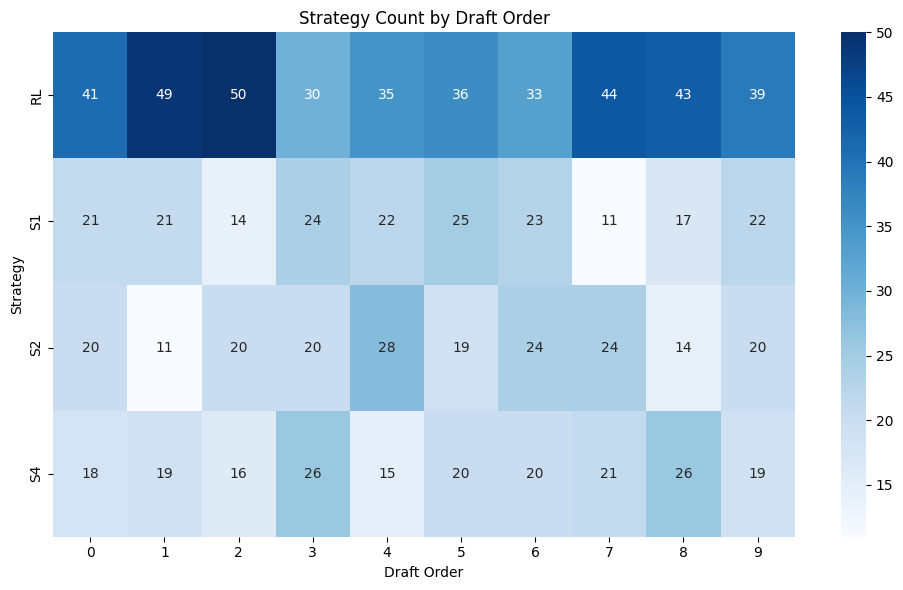

In [ ]:
# Strategy frequency by draft order
order_counts = pd.crosstab(df["Strategy"], df["DraftOrder"])

plt.figure(figsize=(10, 6))
sns.heatmap(order_counts, annot=True, fmt="d", cmap="Blues")
plt.title("Strategy Count by Draft Order")
plt.xlabel("Draft Order")
plt.ylabel("Strategy")
plt.tight_layout()
plt.show()


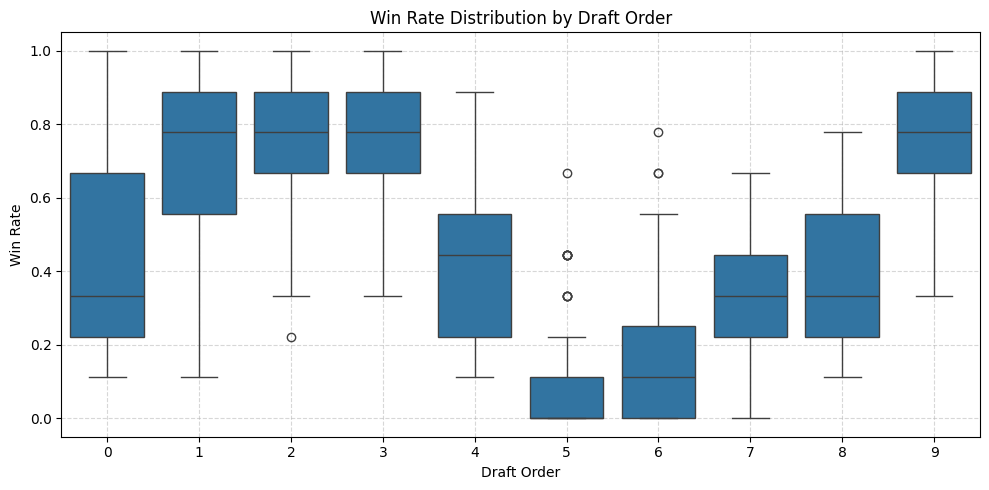

In [ ]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x="DraftOrder", y="WinRate")
plt.title("Win Rate Distribution by Draft Order")
plt.xlabel("Draft Order")
plt.ylabel("Win Rate")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()
